# DCGANs Pytorch implementation

## Generative Adversarial Network (GAN)
GANs are a framework for teaching a deep learning models to learn the training data's distribution so that it can generate new data with the same distribution.

They were invented by Ian Goodfellow in 2014, described in the paper [Generative Adversarial Nets](https://papers.nips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf). They are made up of two  distinct models, a *generator* and a *discriminator*. Where the job of the generator is to create 'fake' images that look like the training data, whilst the discriminators job is to look at the generated image and output whether or not is a real training image or a fake image. During the training phase, the generator is constantly trying to outsmart the discrimintator and produce better and better fakes, while the discriminator is working to be come a better detective and correctly classify the real and fake images. The equilibrium to this game is when the generatror is generating perfect fakes that look as if they have came directly from the training data, whilst the discriminator is left to always guess at 50% confidence that the generator output is real or fake. 

### Notation

#### Discriminator Notation
*x* = data representing an image, it can be real or fake.
*D(x)* = discriminator network (i.e. function) which outputs a probability that *x* came from the training data rather than the generator. The function *D(x)8 can be thought of a traditional *binary classifier* such that *D(x)* should be HIGH i.e. 1 when *x* is real, and LOW i.e. 0 when *x* is fake.

#### Generator Notation
*z* = latent space vector sampled from a standard normal distribution, where the latent space is a representation of compressed data
*G(x)* = generator network (i.e. function) which maps the latent vector *z* to data-space. 

**Finsh understanding this from papers**

## Deep Convolutional Generatiev Adversarial Network (DCGAN)
Direct extension of the GAN described above, except that it explicitly uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively. **What are convolution and convolutional-transpose layers?**

Described by Radford et. al. in the paper [Unsupervised Representation Learning With Deep Convolutional Generative Advarsarial Networks](https://arxiv.org/pdf/1511.06434.pdf). The discriminator is made up of strided convolution layers, batch norm layers, and LeakyReLU activations. The inout is a 3x64x64 input image and the output is a scalar probability that the input is from the real data distribution.
The generator is comprised of convolutional-transpose layers, batch norm layers, and ReLU activation. The input is a latent vector *z* that is drawn from a standard normal distribution and the putput is a 3x64x64 RGB image. The strided conv-transpose layers allow the latent vector to be transformed into a volume with the same shape as an image 

**Understand this more**


In [49]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)

# Seed() method used to initialise a random number generator
# The random number generator requires a number to start with (seed value) to be able to generate a random number
# If you the same seed value you'll get the same set of random numbers
random.seed(manualSeed)

# Sets the seed for randomly generating values with pytorch
# TODO where is this used
torch.manual_seed(manualSeed)

Random Seed:  999


In [50]:
# Dataset size
! ls /home/a/Projects/dggan-pytorch-2d-images/data/downloaded-images/ | wc -l

66756


## Define inputs

**dataroot** - path to the root of the dataset folder. Needs to have sub directories in the dataset's root folder for ImageFolder to work.
**workers** - number of worker threads for loading the data with the DataLoader
**batch_size** - the batch size used in training, where the batch size refers to number of data points used in each round of training. The DCGAN paper uses a batch size of 128
**image_size** - the spatial size of the images used for training. All images will be resized to this size using a transformer. It is set to a default of 64x64, if another size is desired, the structures of D and G must be changed. See [here](https://github.com/pytorch/examples/issues/70) for details.
**nc** - number of color channels in the input images. For color images this is 3
**nz** - size of z latent vector (i.e. size of generator input)
**ngf** - relates to the depth of feature maps carried through the generator
**ndf** - sets the depth of feature maps propagated through the discriminator
**num_epochs** - number of training epochs to run. Training for longer will probably lead to beter results but will also take much longer

**lr** - learning rate for training. As described in the DCGAN paper, this number should be 0.0002
**beta1** - beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5
**ngpu** - number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs.

In [57]:
dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/"
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 300
ngf = 64
ndf = 64
num_epochs = 300
lr = 0.0002
beta1 = 0.5
ngpu = 1

# Prepare the dataset

We begin by loading in the dataset using *ImageFolder* which is aa pytorch method to help with transforming datasets. 
It takes as parameters the root to the dataset directory as well as a transform, which is a function which describes the transformation that need to be performed on the original image
In this case it takes each image and resizes to the given *image_size*, then crops the given image at the center, converts it to a tensor and then normalises it
**TODO whta is a tensor, why normalise**

Then we create a dataloader for the dataset, where a dataloader is a class that helps to parallelize the data loading process with the support of automatic batching as well. We need this as if we were to load in the large datasets into memory all at once we would get memory outages and slowing down of programs.

**Add parameters properly to all of these**

Then set the device we want to train the models on. This will be set to the first GPU i.e. "cuda:0" if pytorch can detect a cuda-enable device and ngpu is greater than 0, else it will run it on the CPU. Note it is considerably faster to run on GPU.

Finally plot some of the transformed dataset points before any training has begun
**Understand matlab plotting better**

/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


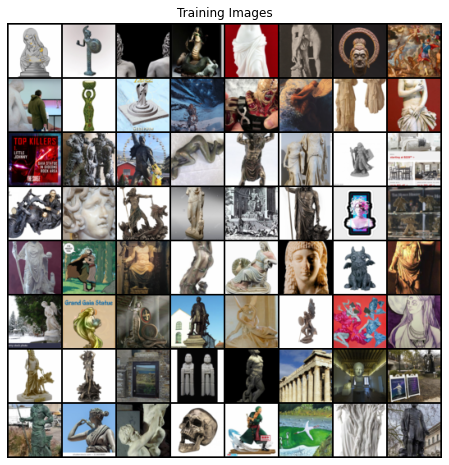

In [58]:
# Create dataset by standardising and normalizing the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader - python iterable over the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images before any training has begun
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Implementation
All functions to be defined
- Weight initialization strategy
- Generator 
- Discriminator
- Loss functions
- Training loop

# Weight Initialization
From the DCGAN paper, the authors specify that all model weights shall be randomly initialiseed from a normal distribution with mean=0, stdev=0.02. The *weight_init* function takes an initialised model as input and reinitalises all convolutional, convolutional-transpose, and batch normalisation layers to meet this criteria. This function is applied to the models immediately after initialisation

**TODO: understand the __class__.name__ syntak amd why we have the line nn.init.constant_(m.bias.data, 0)**

In [59]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Define the generator class
The generator, *G*, is designed to map the latent space vector (z) to data-space. Since our data are images, converting *z* to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of [−1,1]. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training.

**TODO understand convolutional networks and what strided convolutional tranpose, batch norm and relu activation do**

Notice, the how the inputs we set in the input section (nz, ngf, and nc) influence the generator architecture in code. nz is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and nc is the number of channels in the output image (set to 3 for RGB images).

In [60]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Create generator instance and apply weights_init function

Now, we can instantiate the generator and apply the weights_init function. Check out the printed model to see how the generator object is structured.

In [61]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(300, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Define the discrimintator class
As mentioned, the discriminator, *D*, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). Here, D takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both G and D.

**TODO Consider adding a few more layers**

In [62]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create discriminator instance and apply weights_init function

Now, we can instantiate the discriminator and apply the weights_init function. Check out the printed model to see how the discrimintator object is structured.

In [63]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Define Loss functions and Optimizers
With D and G setup, we can specify how they learn through the loss functions and optimizers. We will use the Binary Cross Entropy loss (BCELoss) function.

**TODO understand the loss function better here**
Notice how this function provides the calculation of both log components in the objective function (i.e. log(D(x)) and log(1−D(G(z)))). We can specify what part of the BCE equation to use with the y input. This is accomplished in the training loop which is coming up soon, but it is important to understand how we can choose which component we wish to calculate just by changing y (i.e. GT labels).

Next, we define our real label as 1 and the fake label as 0. These labels will be used when calculating the losses of D and G, and this is also the convention used in the original GAN paper. Finally, we set up two separate optimizers, one for D and one for G. As specified in the DCGAN paper, both are Adam optimizers with learning rate 0.0002 and Beta1 = 0.5. For keeping track of the generator’s learning progression, we will generate a fixed batch of latent vectors that are drawn from a Gaussian distribution (i.e. fixed_noise) . In the training loop, we will periodically input this fixed_noise into G, and over the iterations we will see images form out of the noise.

In [64]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training loop
Finally, now that we have all of the parts of the GAN framework defined, we can train it. Be mindful that training GANs is somewhat of an art form, as incorrect hyperparameter settings lead to mode collapse with little explanation of what went wrong. Here, we will closely follow Algorithm 1 from Goodfellow’s paper, while abiding by some of the best practices shown in ganhacks. Namely, we will “construct different mini-batches for real and fake” images, and also adjust G’s objective function to maximize logD(G(z)). Training is split up into two main parts. Part 1 updates the Discriminator and Part 2 updates the Generator.

Part 1 - Train the Discriminator

Recall, the goal of training the discriminator is to maximize the probability of correctly classifying a given input as real or fake. In terms of Goodfellow, we wish to “update the discriminator by ascending its stochastic gradient”. Practically, we want to maximize log(D(x))+log(1−D(G(z))). Due to the separate mini-batch suggestion from ganhacks, we will calculate this in two steps. First, we will construct a batch of real samples from the training set, forward pass through D, calculate the loss (log(D(x))), then calculate the gradients in a backward pass. Secondly, we will construct a batch of fake samples with the current generator, forward pass this batch through D, calculate the loss (log(1−D(G(z)))), and accumulate the gradients with a backward pass. Now, with the gradients accumulated from both the all-real and all-fake batches, we call a step of the Discriminator’s optimizer.

Part 2 - Train the Generator

As stated in the original paper, we want to train the Generator by minimizing log(1−D(G(z))) in an effort to generate better fakes. As mentioned, this was shown by Goodfellow to not provide sufficient gradients, especially early in the learning process. As a fix, we instead wish to maximize log(D(G(z))). In the code we accomplish this by: classifying the Generator output from Part 1 with the Discriminator, computing G’s loss using real labels as GT, computing G’s gradients in a backward pass, and finally updating G’s parameters with an optimizer step. It may seem counter-intuitive to use the real labels as GT labels for the loss function, but this allows us to use the log(x) part of the BCELoss (rather than the log(1−x) part) which is exactly what we want.

Finally, we will do some statistic reporting and at the end of each epoch we will push our fixed_noise batch through the generator to visually track the progress of G’s training. The training statistics reported are:

Loss_D - discriminator loss calculated as the sum of losses for the all real and all fake batches (log(D(x))+log(D(G(z)))).
Loss_G - generator loss calculated as log(D(G(z)))
D(x) - the average output (across the batch) of the discriminator for the all real batch. This should start close to 1 then theoretically converge to 0.5 when G gets better. Think about why this is.
D(G(z)) - average discriminator outputs for the all fake batch. The first number is before D is updated and the second number is after D is updated. These numbers should start near 0 and converge to 0.5 as G gets better. Think about why this is.
Note: This step might take a while, depending on how many epochs you run and if you removed some data from the dataset.

**TODO read this section over again**

In [65]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/300][0/522]	Loss_D: 1.9985	Loss_G: 6.1905	D(x): 0.8122	D(G(z)): 0.7761 / 0.0031


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[0/300][50/522]	Loss_D: 0.3777	Loss_G: 29.2215	D(x): 0.7647	D(G(z)): 0.0000 / 0.0000
[0/300][100/522]	Loss_D: 0.0019	Loss_G: 39.8409	D(x): 0.9982	D(G(z)): 0.0000 / 0.0000
[0/300][150/522]	Loss_D: 0.0005	Loss_G: 39.3754	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[0/300][200/522]	Loss_D: 0.0004	Loss_G: 39.1552	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[0/300][250/522]	Loss_D: 0.0003	Loss_G: 39.0391	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[0/300][300/522]	Loss_D: 0.0003	Loss_G: 38.9764	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[0/300][350/522]	Loss_D: 0.0002	Loss_G: 38.7898	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[0/300][400/522]	Loss_D: 0.0002	Loss_G: 38.6574	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[0/300][450/522]	Loss_D: 0.0002	Loss_G: 38.5923	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[0/300][500/522]	Loss_D: 0.0001	Loss_G: 38.4949	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[1/300][0/522]	Loss_D: 0.0001	Loss_G: 38.4672	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[1/300][50/522]	Loss_D: 0.0001	Loss_G: 38.3966	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[1/300][100/522]	Loss_D: 0.0001	Loss_G: 38.3182	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[1/300][150/522]	Loss_D: 0.0001	Loss_G: 38.1667	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[1/300][200/522]	Loss_D: 0.0000	Loss_G: 38.0663	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/300][250/522]	Loss_D: 0.0001	Loss_G: 37.9878	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[1/300][300/522]	Loss_D: 0.0000	Loss_G: 37.8242	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/300][350/522]	Loss_D: 0.0000	Loss_G: 37.5802	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/300][400/522]	Loss_D: 0.0000	Loss_G: 37.4035	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/300][450/522]	Loss_D: 0.0001	Loss_G: 37.1269	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[1/300][500/522]	Loss_D: 0.0000	Loss_G: 36.7111	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/300][0/522]	Loss_D: 0.0000	Loss_G: 36.3758	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[2/300][50/522]	Loss_D: 0.0000	Loss_G: 34.9217	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/300][100/522]	Loss_D: 0.4364	Loss_G: 4.4113	D(x): 0.8782	D(G(z)): 0.2268 / 0.0264
[2/300][150/522]	Loss_D: 1.3726	Loss_G: 1.7024	D(x): 0.3487	D(G(z)): 0.1214 / 0.2348
[2/300][200/522]	Loss_D: 0.4604	Loss_G: 4.4179	D(x): 0.8312	D(G(z)): 0.1941 / 0.0246
[2/300][250/522]	Loss_D: 0.2137	Loss_G: 4.0551	D(x): 0.8886	D(G(z)): 0.0788 / 0.0288
[2/300][300/522]	Loss_D: 0.5621	Loss_G: 3.1050	D(x): 0.8595	D(G(z)): 0.3021 / 0.0621
[2/300][350/522]	Loss_D: 0.7726	Loss_G: 1.7549	D(x): 0.6399	D(G(z)): 0.1836 / 0.2126
[2/300][400/522]	Loss_D: 0.5245	Loss_G: 2.7037	D(x): 0.7328	D(G(z)): 0.1411 / 0.0927
[2/300][450/522]	Loss_D: 0.3940	Loss_G: 3.4983	D(x): 0.8056	D(G(z)): 0.1386 / 0.0371
[2/300][500/522]	Loss_D: 0.4864	Loss_G: 2.9807	D(x): 0.7422	D(G(z)): 0.1274 / 0.0694
[3/300][0/522]	Loss_D: 0.5692	Loss_G: 3.6570	D(x): 0.8414	D(G(z)): 0.2976 / 0.0378


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[3/300][50/522]	Loss_D: 0.5161	Loss_G: 2.9747	D(x): 0.8457	D(G(z)): 0.2593 / 0.0679
[3/300][100/522]	Loss_D: 0.7105	Loss_G: 2.7628	D(x): 0.9285	D(G(z)): 0.4099 / 0.1288
[3/300][150/522]	Loss_D: 0.3421	Loss_G: 5.2313	D(x): 0.8473	D(G(z)): 0.1226 / 0.0093
[3/300][200/522]	Loss_D: 0.5441	Loss_G: 3.0709	D(x): 0.7570	D(G(z)): 0.1660 / 0.0741
[3/300][250/522]	Loss_D: 0.8143	Loss_G: 4.4078	D(x): 0.8505	D(G(z)): 0.4306 / 0.0235
[3/300][300/522]	Loss_D: 0.8501	Loss_G: 2.2961	D(x): 0.6172	D(G(z)): 0.1859 / 0.1686
[3/300][350/522]	Loss_D: 0.8356	Loss_G: 4.8509	D(x): 0.9002	D(G(z)): 0.4619 / 0.0116
[3/300][400/522]	Loss_D: 0.5061	Loss_G: 2.6321	D(x): 0.7793	D(G(z)): 0.1728 / 0.0911
[3/300][450/522]	Loss_D: 0.6440	Loss_G: 2.8349	D(x): 0.7285	D(G(z)): 0.2016 / 0.0936
[3/300][500/522]	Loss_D: 0.7363	Loss_G: 4.9720	D(x): 0.8510	D(G(z)): 0.3737 / 0.0126


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[4/300][0/522]	Loss_D: 1.2973	Loss_G: 6.3696	D(x): 0.8715	D(G(z)): 0.6160 / 0.0039


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[4/300][50/522]	Loss_D: 0.1968	Loss_G: 4.1070	D(x): 0.8679	D(G(z)): 0.0353 / 0.0272
[4/300][100/522]	Loss_D: 0.4438	Loss_G: 4.0233	D(x): 0.8963	D(G(z)): 0.2478 / 0.0302
[4/300][150/522]	Loss_D: 0.5636	Loss_G: 3.2901	D(x): 0.8348	D(G(z)): 0.2677 / 0.0575
[4/300][200/522]	Loss_D: 0.6049	Loss_G: 5.3552	D(x): 0.9060	D(G(z)): 0.3605 / 0.0072
[4/300][250/522]	Loss_D: 0.5181	Loss_G: 3.1606	D(x): 0.7730	D(G(z)): 0.1818 / 0.0632
[4/300][300/522]	Loss_D: 0.6213	Loss_G: 3.5645	D(x): 0.8446	D(G(z)): 0.3193 / 0.0438
[4/300][350/522]	Loss_D: 1.0106	Loss_G: 6.3226	D(x): 0.9121	D(G(z)): 0.5304 / 0.0030
[4/300][400/522]	Loss_D: 0.3493	Loss_G: 3.3157	D(x): 0.8572	D(G(z)): 0.1455 / 0.0558
[4/300][450/522]	Loss_D: 1.4085	Loss_G: 2.7192	D(x): 0.3662	D(G(z)): 0.0078 / 0.1503
[4/300][500/522]	Loss_D: 0.3785	Loss_G: 2.8945	D(x): 0.8372	D(G(z)): 0.1508 / 0.0840


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[5/300][0/522]	Loss_D: 0.9689	Loss_G: 1.9973	D(x): 0.5044	D(G(z)): 0.0978 / 0.2133


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[5/300][50/522]	Loss_D: 0.4091	Loss_G: 3.4440	D(x): 0.8635	D(G(z)): 0.2092 / 0.0465
[5/300][100/522]	Loss_D: 0.4728	Loss_G: 4.7872	D(x): 0.8843	D(G(z)): 0.2595 / 0.0145
[5/300][150/522]	Loss_D: 1.0065	Loss_G: 6.3854	D(x): 0.9068	D(G(z)): 0.5016 / 0.0059
[5/300][200/522]	Loss_D: 0.5574	Loss_G: 3.6244	D(x): 0.8053	D(G(z)): 0.2272 / 0.0491
[5/300][250/522]	Loss_D: 0.5095	Loss_G: 4.0027	D(x): 0.6972	D(G(z)): 0.0373 / 0.0688
[5/300][300/522]	Loss_D: 0.3932	Loss_G: 3.1665	D(x): 0.8237	D(G(z)): 0.1521 / 0.0623
[5/300][350/522]	Loss_D: 0.6116	Loss_G: 5.7310	D(x): 0.9136	D(G(z)): 0.3538 / 0.0063
[5/300][400/522]	Loss_D: 0.3696	Loss_G: 4.8027	D(x): 0.9558	D(G(z)): 0.2472 / 0.0142
[5/300][450/522]	Loss_D: 0.8207	Loss_G: 2.5675	D(x): 0.6235	D(G(z)): 0.1462 / 0.1612
[5/300][500/522]	Loss_D: 0.3989	Loss_G: 3.3898	D(x): 0.8694	D(G(z)): 0.1980 / 0.0515


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[6/300][0/522]	Loss_D: 0.3591	Loss_G: 5.4248	D(x): 0.9822	D(G(z)): 0.2612 / 0.0074
[6/300][50/522]	Loss_D: 0.4257	Loss_G: 3.0908	D(x): 0.8240	D(G(z)): 0.1685 / 0.0685
[6/300][100/522]	Loss_D: 0.5418	Loss_G: 5.2985	D(x): 0.9594	D(G(z)): 0.3525 / 0.0092
[6/300][150/522]	Loss_D: 0.6772	Loss_G: 2.5111	D(x): 0.6263	D(G(z)): 0.0555 / 0.1388
[6/300][200/522]	Loss_D: 0.3197	Loss_G: 3.8050	D(x): 0.7852	D(G(z)): 0.0430 / 0.0504
[6/300][250/522]	Loss_D: 0.5891	Loss_G: 4.2110	D(x): 0.8036	D(G(z)): 0.2469 / 0.0279
[6/300][300/522]	Loss_D: 0.3489	Loss_G: 3.0970	D(x): 0.8746	D(G(z)): 0.1673 / 0.0689
[6/300][350/522]	Loss_D: 0.4207	Loss_G: 2.2504	D(x): 0.7525	D(G(z)): 0.0801 / 0.1491
[6/300][400/522]	Loss_D: 0.6231	Loss_G: 4.3269	D(x): 0.8999	D(G(z)): 0.3479 / 0.0211
[6/300][450/522]	Loss_D: 2.0898	Loss_G: 8.3005	D(x): 0.9759	D(G(z)): 0.7719 / 0.0008
[6/300][500/522]	Loss_D: 0.3137	Loss_G: 3.5969	D(x): 0.8170	D(G(z)): 0.0653 / 0.0491


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[7/300][0/522]	Loss_D: 0.5336	Loss_G: 4.9589	D(x): 0.9714	D(G(z)): 0.3483 / 0.0151


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[7/300][50/522]	Loss_D: 0.8810	Loss_G: 5.6042	D(x): 0.9433	D(G(z)): 0.4608 / 0.0103
[7/300][100/522]	Loss_D: 0.2490	Loss_G: 2.6815	D(x): 0.8929	D(G(z)): 0.1137 / 0.0961
[7/300][150/522]	Loss_D: 0.3635	Loss_G: 3.2896	D(x): 0.8305	D(G(z)): 0.1164 / 0.0679
[7/300][200/522]	Loss_D: 0.4376	Loss_G: 3.5550	D(x): 0.8361	D(G(z)): 0.1806 / 0.0460
[7/300][250/522]	Loss_D: 1.2142	Loss_G: 0.9628	D(x): 0.3936	D(G(z)): 0.0278 / 0.4687
[7/300][300/522]	Loss_D: 0.2963	Loss_G: 4.2284	D(x): 0.9748	D(G(z)): 0.2151 / 0.0228
[7/300][350/522]	Loss_D: 0.3432	Loss_G: 4.1881	D(x): 0.9073	D(G(z)): 0.1876 / 0.0240
[7/300][400/522]	Loss_D: 1.4104	Loss_G: 0.9350	D(x): 0.3481	D(G(z)): 0.0086 / 0.5039
[7/300][450/522]	Loss_D: 0.4295	Loss_G: 3.3515	D(x): 0.8525	D(G(z)): 0.2108 / 0.0545
[7/300][500/522]	Loss_D: 0.5439	Loss_G: 2.3108	D(x): 0.6634	D(G(z)): 0.0380 / 0.1669


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[8/300][0/522]	Loss_D: 0.5526	Loss_G: 2.4819	D(x): 0.6450	D(G(z)): 0.0343 / 0.1420


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[8/300][50/522]	Loss_D: 0.2903	Loss_G: 3.8480	D(x): 0.8067	D(G(z)): 0.0397 / 0.0400
[8/300][100/522]	Loss_D: 0.4079	Loss_G: 2.6205	D(x): 0.7741	D(G(z)): 0.0950 / 0.1064
[8/300][150/522]	Loss_D: 0.2989	Loss_G: 3.2213	D(x): 0.8526	D(G(z)): 0.1053 / 0.0606
[8/300][200/522]	Loss_D: 0.3155	Loss_G: 3.0772	D(x): 0.8639	D(G(z)): 0.1252 / 0.0787
[8/300][250/522]	Loss_D: 0.3732	Loss_G: 4.0405	D(x): 0.9331	D(G(z)): 0.2309 / 0.0308
[8/300][300/522]	Loss_D: 0.3046	Loss_G: 4.6834	D(x): 0.9326	D(G(z)): 0.1920 / 0.0142
[8/300][350/522]	Loss_D: 0.8448	Loss_G: 2.9005	D(x): 0.5318	D(G(z)): 0.0145 / 0.1248
[8/300][400/522]	Loss_D: 0.3676	Loss_G: 4.0309	D(x): 0.8765	D(G(z)): 0.1766 / 0.0291
[8/300][450/522]	Loss_D: 0.4831	Loss_G: 2.4416	D(x): 0.7505	D(G(z)): 0.1251 / 0.1438
[8/300][500/522]	Loss_D: 0.4348	Loss_G: 3.6912	D(x): 0.9310	D(G(z)): 0.2661 / 0.0402


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[9/300][0/522]	Loss_D: 0.3837	Loss_G: 2.4721	D(x): 0.8001	D(G(z)): 0.1171 / 0.1267
[9/300][50/522]	Loss_D: 0.5780	Loss_G: 2.2578	D(x): 0.7175	D(G(z)): 0.1316 / 0.1569
[9/300][100/522]	Loss_D: 0.4870	Loss_G: 4.7184	D(x): 0.9415	D(G(z)): 0.3092 / 0.0137
[9/300][150/522]	Loss_D: 0.2628	Loss_G: 2.8343	D(x): 0.8739	D(G(z)): 0.1026 / 0.0896
[9/300][200/522]	Loss_D: 0.2670	Loss_G: 4.0921	D(x): 0.9080	D(G(z)): 0.1373 / 0.0306
[9/300][250/522]	Loss_D: 0.5126	Loss_G: 2.3976	D(x): 0.7966	D(G(z)): 0.1927 / 0.1460
[9/300][300/522]	Loss_D: 0.4483	Loss_G: 4.1772	D(x): 0.9280	D(G(z)): 0.2745 / 0.0244
[9/300][350/522]	Loss_D: 0.4483	Loss_G: 4.6302	D(x): 0.9162	D(G(z)): 0.2556 / 0.0190
[9/300][400/522]	Loss_D: 0.2223	Loss_G: 3.6262	D(x): 0.9121	D(G(z)): 0.1090 / 0.0416
[9/300][450/522]	Loss_D: 0.2912	Loss_G: 3.8882	D(x): 0.8681	D(G(z)): 0.1083 / 0.0420
[9/300][500/522]	Loss_D: 0.5786	Loss_G: 4.8178	D(x): 0.9646	D(G(z)): 0.3541 / 0.0147


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/300][0/522]	Loss_D: 0.4307	Loss_G: 3.1044	D(x): 0.8108	D(G(z)): 0.1556 / 0.0975


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[10/300][50/522]	Loss_D: 0.2781	Loss_G: 4.0154	D(x): 0.9225	D(G(z)): 0.1576 / 0.0277
[10/300][100/522]	Loss_D: 0.3255	Loss_G: 3.6178	D(x): 0.9325	D(G(z)): 0.1956 / 0.0463
[10/300][150/522]	Loss_D: 0.3496	Loss_G: 4.4741	D(x): 0.9080	D(G(z)): 0.1942 / 0.0217
[10/300][200/522]	Loss_D: 0.2807	Loss_G: 3.3940	D(x): 0.8109	D(G(z)): 0.0473 / 0.0607
[10/300][250/522]	Loss_D: 0.1929	Loss_G: 4.5316	D(x): 0.9610	D(G(z)): 0.1311 / 0.0174
[10/300][300/522]	Loss_D: 0.5009	Loss_G: 3.9216	D(x): 0.8762	D(G(z)): 0.2407 / 0.0409
[10/300][350/522]	Loss_D: 0.2409	Loss_G: 3.0797	D(x): 0.8635	D(G(z)): 0.0710 / 0.0733
[10/300][400/522]	Loss_D: 0.2922	Loss_G: 2.9900	D(x): 0.8626	D(G(z)): 0.1153 / 0.0769
[10/300][450/522]	Loss_D: 0.3162	Loss_G: 3.1931	D(x): 0.8603	D(G(z)): 0.1259 / 0.0652
[10/300][500/522]	Loss_D: 0.3271	Loss_G: 2.3837	D(x): 0.8111	D(G(z)): 0.0834 / 0.1439


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[11/300][0/522]	Loss_D: 0.3462	Loss_G: 5.3946	D(x): 0.9480	D(G(z)): 0.2262 / 0.0071
[11/300][50/522]	Loss_D: 0.5099	Loss_G: 4.7624	D(x): 0.9599	D(G(z)): 0.3125 / 0.0154
[11/300][100/522]	Loss_D: 0.3115	Loss_G: 3.1224	D(x): 0.7758	D(G(z)): 0.0275 / 0.0786
[11/300][150/522]	Loss_D: 0.3794	Loss_G: 3.8813	D(x): 0.8963	D(G(z)): 0.1992 / 0.0328
[11/300][200/522]	Loss_D: 0.2346	Loss_G: 4.2167	D(x): 0.9536	D(G(z)): 0.1532 / 0.0242
[11/300][250/522]	Loss_D: 0.2638	Loss_G: 3.3183	D(x): 0.8689	D(G(z)): 0.0913 / 0.0561
[11/300][300/522]	Loss_D: 0.2294	Loss_G: 4.0698	D(x): 0.9451	D(G(z)): 0.1460 / 0.0250
[11/300][350/522]	Loss_D: 0.3514	Loss_G: 4.8063	D(x): 0.9673	D(G(z)): 0.2436 / 0.0143
[11/300][400/522]	Loss_D: 0.2523	Loss_G: 2.9285	D(x): 0.8876	D(G(z)): 0.1036 / 0.0857
[11/300][450/522]	Loss_D: 0.3384	Loss_G: 2.4776	D(x): 0.8240	D(G(z)): 0.0985 / 0.1325
[11/300][500/522]	Loss_D: 0.2883	Loss_G: 4.0093	D(x): 0.9383	D(G(z)): 0.1718 / 0.0281
[12/300][0/522]	Loss_D: 0.2345	Loss_G: 3.4782	D(x): 0.919

/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[12/300][50/522]	Loss_D: 0.2652	Loss_G: 4.7583	D(x): 0.9618	D(G(z)): 0.1749 / 0.0142
[12/300][100/522]	Loss_D: 0.1812	Loss_G: 3.7491	D(x): 0.9316	D(G(z)): 0.0948 / 0.0359
[12/300][150/522]	Loss_D: 0.3098	Loss_G: 2.3909	D(x): 0.8246	D(G(z)): 0.0692 / 0.1658
[12/300][200/522]	Loss_D: 0.2098	Loss_G: 3.6454	D(x): 0.9148	D(G(z)): 0.1005 / 0.0480
[12/300][250/522]	Loss_D: 0.1912	Loss_G: 3.6135	D(x): 0.9046	D(G(z)): 0.0750 / 0.0442
[12/300][300/522]	Loss_D: 0.3083	Loss_G: 3.8293	D(x): 0.9439	D(G(z)): 0.1937 / 0.0358
[12/300][350/522]	Loss_D: 0.2067	Loss_G: 3.4314	D(x): 0.9297	D(G(z)): 0.1109 / 0.0536
[12/300][400/522]	Loss_D: 0.2525	Loss_G: 2.5762	D(x): 0.8203	D(G(z)): 0.0282 / 0.1128
[12/300][450/522]	Loss_D: 0.2615	Loss_G: 2.9837	D(x): 0.8360	D(G(z)): 0.0580 / 0.0828
[12/300][500/522]	Loss_D: 1.6480	Loss_G: 5.2499	D(x): 0.8226	D(G(z)): 0.5053 / 0.0722


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[13/300][0/522]	Loss_D: 0.4585	Loss_G: 2.9460	D(x): 0.8284	D(G(z)): 0.1879 / 0.0901


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[13/300][50/522]	Loss_D: 0.2678	Loss_G: 3.2812	D(x): 0.8798	D(G(z)): 0.1090 / 0.0677
[13/300][100/522]	Loss_D: 0.2115	Loss_G: 2.9450	D(x): 0.8779	D(G(z)): 0.0666 / 0.0788
[13/300][150/522]	Loss_D: 0.2339	Loss_G: 3.1198	D(x): 0.8901	D(G(z)): 0.0963 / 0.0750
[13/300][200/522]	Loss_D: 0.2223	Loss_G: 4.4445	D(x): 0.9606	D(G(z)): 0.1520 / 0.0178
[13/300][250/522]	Loss_D: 0.2241	Loss_G: 2.6493	D(x): 0.8801	D(G(z)): 0.0780 / 0.1074
[13/300][300/522]	Loss_D: 0.1442	Loss_G: 4.5100	D(x): 0.9702	D(G(z)): 0.0993 / 0.0173
[13/300][350/522]	Loss_D: 0.9306	Loss_G: 0.0881	D(x): 0.4954	D(G(z)): 0.0104 / 0.9232
[13/300][400/522]	Loss_D: 0.2343	Loss_G: 3.6907	D(x): 0.8857	D(G(z)): 0.0790 / 0.0472
[13/300][450/522]	Loss_D: 0.1661	Loss_G: 3.9150	D(x): 0.9036	D(G(z)): 0.0526 / 0.0378
[13/300][500/522]	Loss_D: 0.1246	Loss_G: 3.4900	D(x): 0.9561	D(G(z)): 0.0701 / 0.0505
[14/300][0/522]	Loss_D: 0.1131	Loss_G: 3.9747	D(x): 0.9365	D(G(z)): 0.0422 / 0.0345


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[14/300][50/522]	Loss_D: 1.0362	Loss_G: 7.8098	D(x): 0.9778	D(G(z)): 0.5328 / 0.0012
[14/300][100/522]	Loss_D: 0.2109	Loss_G: 2.9672	D(x): 0.8639	D(G(z)): 0.0422 / 0.0831
[14/300][150/522]	Loss_D: 0.1848	Loss_G: 3.4388	D(x): 0.9362	D(G(z)): 0.1018 / 0.0503
[14/300][200/522]	Loss_D: 0.1293	Loss_G: 3.5056	D(x): 0.9257	D(G(z)): 0.0429 / 0.0551
[14/300][250/522]	Loss_D: 2.3596	Loss_G: 4.1395	D(x): 0.8982	D(G(z)): 0.7390 / 0.0630
[14/300][300/522]	Loss_D: 1.6517	Loss_G: 1.4140	D(x): 0.2675	D(G(z)): 0.0064 / 0.3489
[14/300][350/522]	Loss_D: 0.2331	Loss_G: 3.4514	D(x): 0.9218	D(G(z)): 0.1245 / 0.0563
[14/300][400/522]	Loss_D: 0.1903	Loss_G: 3.1030	D(x): 0.8896	D(G(z)): 0.0563 / 0.0714
[14/300][450/522]	Loss_D: 0.1591	Loss_G: 3.7798	D(x): 0.8984	D(G(z)): 0.0356 / 0.0445
[14/300][500/522]	Loss_D: 0.1358	Loss_G: 4.0124	D(x): 0.9548	D(G(z)): 0.0775 / 0.0314


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[15/300][0/522]	Loss_D: 0.1936	Loss_G: 3.5216	D(x): 0.9417	D(G(z)): 0.1097 / 0.0463
[15/300][50/522]	Loss_D: 0.1746	Loss_G: 3.2477	D(x): 0.8870	D(G(z)): 0.0416 / 0.0706
[15/300][100/522]	Loss_D: 0.1557	Loss_G: 3.5725	D(x): 0.8884	D(G(z)): 0.0265 / 0.0482
[15/300][150/522]	Loss_D: 0.1711	Loss_G: 3.6280	D(x): 0.8895	D(G(z)): 0.0381 / 0.0458
[15/300][200/522]	Loss_D: 0.0785	Loss_G: 4.9566	D(x): 0.9598	D(G(z)): 0.0345 / 0.0137
[15/300][250/522]	Loss_D: 0.3401	Loss_G: 2.1538	D(x): 0.7522	D(G(z)): 0.0129 / 0.1898
[15/300][300/522]	Loss_D: 0.3422	Loss_G: 2.9160	D(x): 0.8233	D(G(z)): 0.0869 / 0.1035
[15/300][350/522]	Loss_D: 0.2544	Loss_G: 3.1957	D(x): 0.8746	D(G(z)): 0.0921 / 0.0703
[15/300][400/522]	Loss_D: 0.2154	Loss_G: 3.1635	D(x): 0.8948	D(G(z)): 0.0840 / 0.0653
[15/300][450/522]	Loss_D: 0.1864	Loss_G: 3.2366	D(x): 0.9190	D(G(z)): 0.0727 / 0.0629
[15/300][500/522]	Loss_D: 0.2194	Loss_G: 2.7830	D(x): 0.8547	D(G(z)): 0.0439 / 0.0924


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[16/300][0/522]	Loss_D: 0.0622	Loss_G: 4.0644	D(x): 0.9802	D(G(z)): 0.0399 / 0.0300


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[16/300][50/522]	Loss_D: 1.3821	Loss_G: 6.7163	D(x): 0.9180	D(G(z)): 0.5939 / 0.0038
[16/300][100/522]	Loss_D: 0.3287	Loss_G: 2.4164	D(x): 0.7720	D(G(z)): 0.0323 / 0.1523
[16/300][150/522]	Loss_D: 0.1087	Loss_G: 4.4583	D(x): 0.9543	D(G(z)): 0.0542 / 0.0245
[16/300][200/522]	Loss_D: 0.1565	Loss_G: 3.5660	D(x): 0.9100	D(G(z)): 0.0485 / 0.0468
[16/300][250/522]	Loss_D: 0.2018	Loss_G: 3.3518	D(x): 0.8733	D(G(z)): 0.0352 / 0.0737
[16/300][300/522]	Loss_D: 0.1645	Loss_G: 3.5993	D(x): 0.8984	D(G(z)): 0.0423 / 0.0507
[16/300][350/522]	Loss_D: 0.1347	Loss_G: 4.0475	D(x): 0.9409	D(G(z)): 0.0611 / 0.0318
[16/300][400/522]	Loss_D: 0.1560	Loss_G: 4.4799	D(x): 0.9465	D(G(z)): 0.0811 / 0.0254
[16/300][450/522]	Loss_D: 0.1023	Loss_G: 4.4009	D(x): 0.9527	D(G(z)): 0.0469 / 0.0232
[16/300][500/522]	Loss_D: 0.1375	Loss_G: 3.5297	D(x): 0.9097	D(G(z)): 0.0320 / 0.0553


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[17/300][0/522]	Loss_D: 0.2130	Loss_G: 5.4814	D(x): 0.9864	D(G(z)): 0.1592 / 0.0078


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[17/300][50/522]	Loss_D: 0.2636	Loss_G: 2.2038	D(x): 0.8157	D(G(z)): 0.0229 / 0.1573
[17/300][100/522]	Loss_D: 0.1246	Loss_G: 4.2386	D(x): 0.9586	D(G(z)): 0.0707 / 0.0236
[17/300][150/522]	Loss_D: 0.1155	Loss_G: 4.3141	D(x): 0.9703	D(G(z)): 0.0742 / 0.0235
[17/300][200/522]	Loss_D: 0.1445	Loss_G: 4.8116	D(x): 0.9835	D(G(z)): 0.1108 / 0.0137
[17/300][250/522]	Loss_D: 6.2770	Loss_G: 0.3219	D(x): 0.0096	D(G(z)): 0.0005 / 0.8701
[17/300][300/522]	Loss_D: 0.5253	Loss_G: 2.3773	D(x): 0.7196	D(G(z)): 0.0842 / 0.1662
[17/300][350/522]	Loss_D: 0.1618	Loss_G: 3.6109	D(x): 0.9178	D(G(z)): 0.0620 / 0.0475
[17/300][400/522]	Loss_D: 0.0867	Loss_G: 4.8873	D(x): 0.9441	D(G(z)): 0.0249 / 0.0152
[17/300][450/522]	Loss_D: 0.1144	Loss_G: 4.4521	D(x): 0.9573	D(G(z)): 0.0588 / 0.0214
[17/300][500/522]	Loss_D: 0.1141	Loss_G: 4.3313	D(x): 0.9522	D(G(z)): 0.0554 / 0.0239
[18/300][0/522]	Loss_D: 4.3550	Loss_G: 0.0305	D(x): 0.0593	D(G(z)): 0.0029 / 0.9718


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[18/300][50/522]	Loss_D: 0.1700	Loss_G: 3.2793	D(x): 0.9159	D(G(z)): 0.0668 / 0.0635
[18/300][100/522]	Loss_D: 0.1772	Loss_G: 3.6474	D(x): 0.8955	D(G(z)): 0.0506 / 0.0499
[18/300][150/522]	Loss_D: 0.1485	Loss_G: 3.3619	D(x): 0.9512	D(G(z)): 0.0865 / 0.0597
[18/300][200/522]	Loss_D: 0.0984	Loss_G: 4.4165	D(x): 0.9610	D(G(z)): 0.0508 / 0.0250
[18/300][250/522]	Loss_D: 0.1007	Loss_G: 4.0246	D(x): 0.9384	D(G(z)): 0.0328 / 0.0290
[18/300][300/522]	Loss_D: 0.1259	Loss_G: 4.3152	D(x): 0.9513	D(G(z)): 0.0636 / 0.0225
[18/300][350/522]	Loss_D: 0.0907	Loss_G: 4.4455	D(x): 0.9533	D(G(z)): 0.0368 / 0.0242
[18/300][400/522]	Loss_D: 0.1599	Loss_G: 4.6033	D(x): 0.9500	D(G(z)): 0.0913 / 0.0185
[18/300][450/522]	Loss_D: 0.3378	Loss_G: 4.9125	D(x): 0.8730	D(G(z)): 0.1213 / 0.0209
[18/300][500/522]	Loss_D: 0.1547	Loss_G: 3.6164	D(x): 0.9395	D(G(z)): 0.0715 / 0.0473


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[19/300][0/522]	Loss_D: 0.0835	Loss_G: 4.8460	D(x): 0.9554	D(G(z)): 0.0320 / 0.0178


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[19/300][50/522]	Loss_D: 0.0982	Loss_G: 4.4275	D(x): 0.9711	D(G(z)): 0.0617 / 0.0212
[19/300][100/522]	Loss_D: 0.1101	Loss_G: 4.3916	D(x): 0.9811	D(G(z)): 0.0753 / 0.0203
[19/300][150/522]	Loss_D: 0.0970	Loss_G: 4.9824	D(x): 0.9816	D(G(z)): 0.0667 / 0.0120
[19/300][200/522]	Loss_D: 0.0462	Loss_G: 4.8279	D(x): 0.9895	D(G(z)): 0.0341 / 0.0135
[19/300][250/522]	Loss_D: 0.0841	Loss_G: 4.4232	D(x): 0.9940	D(G(z)): 0.0688 / 0.0216
[19/300][300/522]	Loss_D: 0.0615	Loss_G: 5.0108	D(x): 0.9659	D(G(z)): 0.0243 / 0.0131
[19/300][350/522]	Loss_D: 1.2247	Loss_G: 2.3420	D(x): 0.5703	D(G(z)): 0.2798 / 0.2774
[19/300][400/522]	Loss_D: 0.2012	Loss_G: 3.8339	D(x): 0.9445	D(G(z)): 0.1104 / 0.0380
[19/300][450/522]	Loss_D: 0.2482	Loss_G: 3.2378	D(x): 0.8560	D(G(z)): 0.0558 / 0.0756
[19/300][500/522]	Loss_D: 0.1354	Loss_G: 3.8681	D(x): 0.9103	D(G(z)): 0.0194 / 0.0395
[20/300][0/522]	Loss_D: 0.0991	Loss_G: 4.6600	D(x): 0.9345	D(G(z)): 0.0261 / 0.0180


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[20/300][50/522]	Loss_D: 0.1191	Loss_G: 4.3073	D(x): 0.9697	D(G(z)): 0.0795 / 0.0207
[20/300][100/522]	Loss_D: 0.1443	Loss_G: 3.5604	D(x): 0.8951	D(G(z)): 0.0235 / 0.0502
[20/300][150/522]	Loss_D: 0.1032	Loss_G: 4.6188	D(x): 0.9700	D(G(z)): 0.0622 / 0.0202
[20/300][200/522]	Loss_D: 0.1191	Loss_G: 4.2676	D(x): 0.9847	D(G(z)): 0.0896 / 0.0218
[20/300][250/522]	Loss_D: 0.2746	Loss_G: 5.0141	D(x): 0.9441	D(G(z)): 0.1595 / 0.0130
[20/300][300/522]	Loss_D: 0.1602	Loss_G: 3.7498	D(x): 0.8909	D(G(z)): 0.0313 / 0.0464
[20/300][350/522]	Loss_D: 0.0512	Loss_G: 4.6802	D(x): 0.9752	D(G(z)): 0.0243 / 0.0171
[20/300][400/522]	Loss_D: 0.1427	Loss_G: 3.5121	D(x): 0.9010	D(G(z)): 0.0287 / 0.0568
[20/300][450/522]	Loss_D: 0.1296	Loss_G: 3.9253	D(x): 0.9079	D(G(z)): 0.0207 / 0.0383
[20/300][500/522]	Loss_D: 0.0865	Loss_G: 4.4175	D(x): 0.9362	D(G(z)): 0.0175 / 0.0233


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[21/300][0/522]	Loss_D: 0.0704	Loss_G: 4.4067	D(x): 0.9702	D(G(z)): 0.0362 / 0.0245


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[21/300][50/522]	Loss_D: 0.0746	Loss_G: 4.6708	D(x): 0.9938	D(G(z)): 0.0620 / 0.0170
[21/300][100/522]	Loss_D: 0.0755	Loss_G: 4.6617	D(x): 0.9645	D(G(z)): 0.0358 / 0.0175
[21/300][150/522]	Loss_D: 0.0446	Loss_G: 5.5012	D(x): 0.9720	D(G(z)): 0.0144 / 0.0103
[21/300][200/522]	Loss_D: 0.1473	Loss_G: 3.2376	D(x): 0.8924	D(G(z)): 0.0152 / 0.0894
[21/300][250/522]	Loss_D: 0.7102	Loss_G: 3.0136	D(x): 0.7204	D(G(z)): 0.1728 / 0.1120
[21/300][300/522]	Loss_D: 0.0918	Loss_G: 5.1567	D(x): 0.9723	D(G(z)): 0.0535 / 0.0124
[21/300][350/522]	Loss_D: 0.1267	Loss_G: 4.5488	D(x): 0.9719	D(G(z)): 0.0850 / 0.0181
[21/300][400/522]	Loss_D: 0.0793	Loss_G: 4.7655	D(x): 0.9414	D(G(z)): 0.0146 / 0.0162
[21/300][450/522]	Loss_D: 0.0895	Loss_G: 4.3385	D(x): 0.9728	D(G(z)): 0.0566 / 0.0251
[21/300][500/522]	Loss_D: 0.1231	Loss_G: 4.7476	D(x): 0.9670	D(G(z)): 0.0746 / 0.0158
[22/300][0/522]	Loss_D: 0.0679	Loss_G: 4.6901	D(x): 0.9839	D(G(z)): 0.0476 / 0.0187


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[22/300][50/522]	Loss_D: 0.0705	Loss_G: 4.4148	D(x): 0.9617	D(G(z)): 0.0297 / 0.0214
[22/300][100/522]	Loss_D: 0.0705	Loss_G: 4.6972	D(x): 0.9534	D(G(z)): 0.0207 / 0.0177
[22/300][150/522]	Loss_D: 0.1069	Loss_G: 4.6879	D(x): 0.9735	D(G(z)): 0.0690 / 0.0156
[22/300][200/522]	Loss_D: 0.0501	Loss_G: 4.9374	D(x): 0.9842	D(G(z)): 0.0317 / 0.0138
[22/300][250/522]	Loss_D: 0.0394	Loss_G: 5.0744	D(x): 0.9844	D(G(z)): 0.0218 / 0.0125
[22/300][300/522]	Loss_D: 0.0284	Loss_G: 5.6855	D(x): 0.9822	D(G(z)): 0.0101 / 0.0076
[22/300][350/522]	Loss_D: 0.0635	Loss_G: 4.2646	D(x): 0.9686	D(G(z)): 0.0295 / 0.0248
[22/300][400/522]	Loss_D: 5.6254	Loss_G: 0.0225	D(x): 0.0956	D(G(z)): 0.0131 / 0.9808
[22/300][450/522]	Loss_D: 0.4482	Loss_G: 3.5387	D(x): 0.8320	D(G(z)): 0.1485 / 0.0574
[22/300][500/522]	Loss_D: 0.2618	Loss_G: 5.2195	D(x): 0.9630	D(G(z)): 0.1633 / 0.0110


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[23/300][0/522]	Loss_D: 0.2024	Loss_G: 3.6070	D(x): 0.8952	D(G(z)): 0.0588 / 0.0536


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[23/300][50/522]	Loss_D: 0.0952	Loss_G: 4.3088	D(x): 0.9545	D(G(z)): 0.0428 / 0.0252
[23/300][100/522]	Loss_D: 0.0993	Loss_G: 5.0315	D(x): 0.9270	D(G(z)): 0.0133 / 0.0164
[23/300][150/522]	Loss_D: 0.0591	Loss_G: 5.0675	D(x): 0.9721	D(G(z)): 0.0269 / 0.0137
[23/300][200/522]	Loss_D: 0.0574	Loss_G: 4.6170	D(x): 0.9640	D(G(z)): 0.0190 / 0.0208
[23/300][250/522]	Loss_D: 0.3992	Loss_G: 1.4240	D(x): 0.7811	D(G(z)): 0.0592 / 0.4203
[23/300][300/522]	Loss_D: 0.2343	Loss_G: 3.7932	D(x): 0.8721	D(G(z)): 0.0641 / 0.0430
[23/300][350/522]	Loss_D: 0.0751	Loss_G: 4.5925	D(x): 0.9818	D(G(z)): 0.0512 / 0.0209
[23/300][400/522]	Loss_D: 0.0615	Loss_G: 4.5508	D(x): 0.9770	D(G(z)): 0.0353 / 0.0246
[23/300][450/522]	Loss_D: 0.0996	Loss_G: 4.1906	D(x): 0.9313	D(G(z)): 0.0223 / 0.0311
[23/300][500/522]	Loss_D: 0.0762	Loss_G: 5.0638	D(x): 0.9677	D(G(z)): 0.0388 / 0.0130


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[24/300][0/522]	Loss_D: 0.0375	Loss_G: 5.5928	D(x): 0.9849	D(G(z)): 0.0213 / 0.0087


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[24/300][50/522]	Loss_D: 0.0964	Loss_G: 4.6895	D(x): 0.9971	D(G(z)): 0.0822 / 0.0159
[24/300][100/522]	Loss_D: 0.0377	Loss_G: 5.4716	D(x): 0.9984	D(G(z)): 0.0346 / 0.0079
[24/300][150/522]	Loss_D: 0.0583	Loss_G: 4.7951	D(x): 0.9720	D(G(z)): 0.0277 / 0.0154
[24/300][200/522]	Loss_D: 0.0658	Loss_G: 4.7870	D(x): 0.9640	D(G(z)): 0.0263 / 0.0176
[24/300][250/522]	Loss_D: 0.0331	Loss_G: 5.5180	D(x): 0.9872	D(G(z)): 0.0195 / 0.0097
[24/300][300/522]	Loss_D: 0.1192	Loss_G: 5.4467	D(x): 0.9917	D(G(z)): 0.0983 / 0.0069
[24/300][350/522]	Loss_D: 0.0573	Loss_G: 4.8171	D(x): 0.9677	D(G(z)): 0.0192 / 0.0146
[24/300][400/522]	Loss_D: 1.2269	Loss_G: 2.3661	D(x): 0.5329	D(G(z)): 0.1039 / 0.2310
[24/300][450/522]	Loss_D: 0.1336	Loss_G: 4.8928	D(x): 0.9473	D(G(z)): 0.0677 / 0.0158
[24/300][500/522]	Loss_D: 0.0894	Loss_G: 5.0877	D(x): 0.9741	D(G(z)): 0.0534 / 0.0146
[25/300][0/522]	Loss_D: 0.1464	Loss_G: 3.2938	D(x): 0.9258	D(G(z)): 0.0564 / 0.0656


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[25/300][50/522]	Loss_D: 0.1109	Loss_G: 4.1826	D(x): 0.9349	D(G(z)): 0.0356 / 0.0308
[25/300][100/522]	Loss_D: 0.0381	Loss_G: 5.5863	D(x): 0.9812	D(G(z)): 0.0182 / 0.0085
[25/300][150/522]	Loss_D: 0.0302	Loss_G: 5.2914	D(x): 0.9884	D(G(z)): 0.0179 / 0.0099
[25/300][200/522]	Loss_D: 0.1128	Loss_G: 4.4851	D(x): 0.9401	D(G(z)): 0.0407 / 0.0209
[25/300][250/522]	Loss_D: 0.0704	Loss_G: 4.8751	D(x): 0.9732	D(G(z)): 0.0397 / 0.0161
[25/300][300/522]	Loss_D: 0.0762	Loss_G: 4.7401	D(x): 0.9566	D(G(z)): 0.0279 / 0.0211
[25/300][350/522]	Loss_D: 0.0985	Loss_G: 4.7504	D(x): 0.9784	D(G(z)): 0.0655 / 0.0148
[25/300][400/522]	Loss_D: 0.0796	Loss_G: 5.1816	D(x): 0.9953	D(G(z)): 0.0671 / 0.0113
[25/300][450/522]	Loss_D: 0.0314	Loss_G: 5.1534	D(x): 0.9848	D(G(z)): 0.0152 / 0.0116
[25/300][500/522]	Loss_D: 0.0515	Loss_G: 5.5432	D(x): 0.9715	D(G(z)): 0.0192 / 0.0107


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[26/300][0/522]	Loss_D: 0.0385	Loss_G: 5.5423	D(x): 0.9937	D(G(z)): 0.0307 / 0.0074


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[26/300][50/522]	Loss_D: 0.0428	Loss_G: 5.4601	D(x): 0.9872	D(G(z)): 0.0269 / 0.0099
[26/300][100/522]	Loss_D: 0.4456	Loss_G: 4.4476	D(x): 0.8783	D(G(z)): 0.1870 / 0.0299
[26/300][150/522]	Loss_D: 0.0720	Loss_G: 4.9770	D(x): 0.9676	D(G(z)): 0.0353 / 0.0140
[26/300][200/522]	Loss_D: 0.1053	Loss_G: 4.7530	D(x): 0.9370	D(G(z)): 0.0290 / 0.0205
[26/300][250/522]	Loss_D: 0.2871	Loss_G: 1.7745	D(x): 0.7967	D(G(z)): 0.0162 / 0.2702
[26/300][300/522]	Loss_D: 0.0875	Loss_G: 4.9480	D(x): 0.9900	D(G(z)): 0.0697 / 0.0124
[26/300][350/522]	Loss_D: 0.0316	Loss_G: 4.8438	D(x): 0.9904	D(G(z)): 0.0206 / 0.0143
[26/300][400/522]	Loss_D: 0.0609	Loss_G: 4.5108	D(x): 0.9611	D(G(z)): 0.0186 / 0.0226
[26/300][450/522]	Loss_D: 0.0609	Loss_G: 5.3194	D(x): 0.9499	D(G(z)): 0.0073 / 0.0120
[26/300][500/522]	Loss_D: 0.0478	Loss_G: 5.6806	D(x): 0.9919	D(G(z)): 0.0369 / 0.0078


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[27/300][0/522]	Loss_D: 0.0567	Loss_G: 4.7972	D(x): 0.9939	D(G(z)): 0.0454 / 0.0138


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[27/300][50/522]	Loss_D: 0.0413	Loss_G: 5.2415	D(x): 0.9958	D(G(z)): 0.0345 / 0.0111
[27/300][100/522]	Loss_D: 0.0850	Loss_G: 4.4330	D(x): 0.9845	D(G(z)): 0.0642 / 0.0207
[27/300][150/522]	Loss_D: 0.0567	Loss_G: 4.9999	D(x): 0.9558	D(G(z)): 0.0100 / 0.0151
[27/300][200/522]	Loss_D: 0.0244	Loss_G: 6.0083	D(x): 0.9907	D(G(z)): 0.0140 / 0.0073
[27/300][250/522]	Loss_D: 0.1091	Loss_G: 6.1113	D(x): 0.9837	D(G(z)): 0.0773 / 0.0084
[27/300][300/522]	Loss_D: 0.0998	Loss_G: 3.9910	D(x): 0.9317	D(G(z)): 0.0175 / 0.0545
[27/300][350/522]	Loss_D: 0.6622	Loss_G: 3.8427	D(x): 0.7664	D(G(z)): 0.2017 / 0.0530
[27/300][400/522]	Loss_D: 0.1332	Loss_G: 6.5860	D(x): 0.9059	D(G(z)): 0.0131 / 0.0048
[27/300][450/522]	Loss_D: 0.0535	Loss_G: 5.6499	D(x): 0.9720	D(G(z)): 0.0226 / 0.0088
[27/300][500/522]	Loss_D: 0.0649	Loss_G: 5.2299	D(x): 0.9786	D(G(z)): 0.0393 / 0.0108


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[28/300][0/522]	Loss_D: 0.0844	Loss_G: 3.9995	D(x): 0.9530	D(G(z)): 0.0276 / 0.0367
[28/300][50/522]	Loss_D: 0.0422	Loss_G: 5.1651	D(x): 0.9932	D(G(z)): 0.0335 / 0.0114
[28/300][100/522]	Loss_D: 0.0546	Loss_G: 4.6532	D(x): 0.9915	D(G(z)): 0.0432 / 0.0174
[28/300][150/522]	Loss_D: 0.0386	Loss_G: 5.2591	D(x): 0.9925	D(G(z)): 0.0279 / 0.0103
[28/300][200/522]	Loss_D: 0.0291	Loss_G: 5.3263	D(x): 0.9822	D(G(z)): 0.0107 / 0.0103
[28/300][250/522]	Loss_D: 0.0155	Loss_G: 6.3767	D(x): 0.9923	D(G(z)): 0.0075 / 0.0044
[28/300][300/522]	Loss_D: 12.6198	Loss_G: 7.0037	D(x): 0.9993	D(G(z)): 0.9924 / 0.0588
[28/300][350/522]	Loss_D: 0.4305	Loss_G: 3.6329	D(x): 0.7966	D(G(z)): 0.1011 / 0.0682
[28/300][400/522]	Loss_D: 0.1011	Loss_G: 5.1897	D(x): 0.9622	D(G(z)): 0.0544 / 0.0142
[28/300][450/522]	Loss_D: 0.0424	Loss_G: 5.3546	D(x): 0.9899	D(G(z)): 0.0306 / 0.0100
[28/300][500/522]	Loss_D: 0.0734	Loss_G: 5.0699	D(x): 0.9491	D(G(z)): 0.0160 / 0.0145
[29/300][0/522]	Loss_D: 0.0777	Loss_G: 4.8037	D(x): 0.99

/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[29/300][50/522]	Loss_D: 0.0414	Loss_G: 5.0240	D(x): 0.9886	D(G(z)): 0.0283 / 0.0139
[29/300][100/522]	Loss_D: 0.0434	Loss_G: 5.1899	D(x): 0.9863	D(G(z)): 0.0276 / 0.0125
[29/300][150/522]	Loss_D: 0.1140	Loss_G: 3.6672	D(x): 0.9193	D(G(z)): 0.0224 / 0.0530
[29/300][200/522]	Loss_D: 0.0489	Loss_G: 5.3027	D(x): 0.9856	D(G(z)): 0.0324 / 0.0098
[29/300][250/522]	Loss_D: 0.0843	Loss_G: 5.1519	D(x): 0.9915	D(G(z)): 0.0673 / 0.0104
[29/300][300/522]	Loss_D: 0.0379	Loss_G: 5.5671	D(x): 0.9944	D(G(z)): 0.0307 / 0.0085
[29/300][350/522]	Loss_D: 0.0445	Loss_G: 5.4663	D(x): 0.9753	D(G(z)): 0.0181 / 0.0127
[29/300][400/522]	Loss_D: 0.0286	Loss_G: 5.4118	D(x): 0.9938	D(G(z)): 0.0213 / 0.0084
[29/300][450/522]	Loss_D: 0.0233	Loss_G: 5.7632	D(x): 0.9955	D(G(z)): 0.0182 / 0.0070
[29/300][500/522]	Loss_D: 0.0249	Loss_G: 5.8701	D(x): 0.9941	D(G(z)): 0.0181 / 0.0062
[30/300][0/522]	Loss_D: 0.0260	Loss_G: 5.6400	D(x): 0.9967	D(G(z)): 0.0206 / 0.0094


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[30/300][50/522]	Loss_D: 0.0196	Loss_G: 6.2680	D(x): 0.9915	D(G(z)): 0.0108 / 0.0041
[30/300][100/522]	Loss_D: 0.0173	Loss_G: 5.8521	D(x): 0.9926	D(G(z)): 0.0097 / 0.0061
[30/300][150/522]	Loss_D: 0.0591	Loss_G: 4.7111	D(x): 0.9521	D(G(z)): 0.0071 / 0.0184
[30/300][200/522]	Loss_D: 0.0242	Loss_G: 6.3455	D(x): 0.9906	D(G(z)): 0.0144 / 0.0042
[30/300][250/522]	Loss_D: 0.0642	Loss_G: 6.1338	D(x): 0.9920	D(G(z)): 0.0487 / 0.0055
[30/300][300/522]	Loss_D: 0.0187	Loss_G: 5.6742	D(x): 0.9968	D(G(z)): 0.0151 / 0.0079
[30/300][350/522]	Loss_D: 0.0655	Loss_G: 4.3217	D(x): 0.9518	D(G(z)): 0.0113 / 0.0334
[30/300][400/522]	Loss_D: 0.5476	Loss_G: 5.2740	D(x): 0.8861	D(G(z)): 0.1986 / 0.0193
[30/300][450/522]	Loss_D: 0.1754	Loss_G: 4.2153	D(x): 0.8822	D(G(z)): 0.0233 / 0.0387
[30/300][500/522]	Loss_D: 0.0883	Loss_G: 5.4638	D(x): 0.9963	D(G(z)): 0.0752 / 0.0084


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[31/300][0/522]	Loss_D: 0.1337	Loss_G: 4.6197	D(x): 0.9568	D(G(z)): 0.0697 / 0.0233


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[31/300][50/522]	Loss_D: 0.0433	Loss_G: 4.9188	D(x): 0.9774	D(G(z)): 0.0191 / 0.0143
[31/300][100/522]	Loss_D: 0.0304	Loss_G: 5.3138	D(x): 0.9950	D(G(z)): 0.0244 / 0.0103
[31/300][150/522]	Loss_D: 0.1100	Loss_G: 4.5157	D(x): 0.9169	D(G(z)): 0.0131 / 0.0244
[31/300][200/522]	Loss_D: 0.0205	Loss_G: 5.7369	D(x): 0.9920	D(G(z)): 0.0121 / 0.0073
[31/300][250/522]	Loss_D: 0.0214	Loss_G: 5.5116	D(x): 0.9900	D(G(z)): 0.0111 / 0.0078
[31/300][300/522]	Loss_D: 0.0294	Loss_G: 5.4425	D(x): 0.9974	D(G(z)): 0.0255 / 0.0107
[31/300][350/522]	Loss_D: 0.0172	Loss_G: 6.0285	D(x): 0.9913	D(G(z)): 0.0082 / 0.0053
[31/300][400/522]	Loss_D: 0.0831	Loss_G: 4.8629	D(x): 0.9365	D(G(z)): 0.0109 / 0.0192
[31/300][450/522]	Loss_D: 0.0418	Loss_G: 5.2711	D(x): 0.9719	D(G(z)): 0.0124 / 0.0110
[31/300][500/522]	Loss_D: 0.0299	Loss_G: 6.4257	D(x): 0.9791	D(G(z)): 0.0080 / 0.0044


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[32/300][0/522]	Loss_D: 0.0179	Loss_G: 5.9056	D(x): 0.9953	D(G(z)): 0.0129 / 0.0069


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[32/300][50/522]	Loss_D: 0.0190	Loss_G: 6.1355	D(x): 0.9958	D(G(z)): 0.0145 / 0.0053
[32/300][100/522]	Loss_D: 0.0357	Loss_G: 5.8782	D(x): 0.9990	D(G(z)): 0.0324 / 0.0063
[32/300][150/522]	Loss_D: 0.0162	Loss_G: 5.7291	D(x): 0.9967	D(G(z)): 0.0125 / 0.0075
[32/300][200/522]	Loss_D: 0.0581	Loss_G: 5.1891	D(x): 0.9865	D(G(z)): 0.0410 / 0.0146
[32/300][250/522]	Loss_D: 0.0283	Loss_G: 5.8636	D(x): 0.9969	D(G(z)): 0.0240 / 0.0060
[32/300][300/522]	Loss_D: 0.0226	Loss_G: 6.6839	D(x): 0.9961	D(G(z)): 0.0167 / 0.0033
[32/300][350/522]	Loss_D: 0.0368	Loss_G: 5.7191	D(x): 0.9810	D(G(z)): 0.0155 / 0.0086
[32/300][400/522]	Loss_D: 0.0793	Loss_G: 4.0531	D(x): 0.9368	D(G(z)): 0.0070 / 0.0384
[32/300][450/522]	Loss_D: 0.0286	Loss_G: 6.1833	D(x): 0.9793	D(G(z)): 0.0073 / 0.0055
[32/300][500/522]	Loss_D: 0.0120	Loss_G: 6.1232	D(x): 0.9974	D(G(z)): 0.0092 / 0.0060


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[33/300][0/522]	Loss_D: 0.0200	Loss_G: 5.7829	D(x): 0.9957	D(G(z)): 0.0153 / 0.0059


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[33/300][50/522]	Loss_D: 2.9929	Loss_G: 2.1447	D(x): 0.7556	D(G(z)): 0.7506 / 0.2347
[33/300][100/522]	Loss_D: 1.2412	Loss_G: 1.5324	D(x): 0.6230	D(G(z)): 0.4420 / 0.2922
[33/300][150/522]	Loss_D: 1.6517	Loss_G: 2.3141	D(x): 0.7464	D(G(z)): 0.4910 / 0.2181
[33/300][200/522]	Loss_D: 0.6579	Loss_G: 6.5132	D(x): 0.8841	D(G(z)): 0.2840 / 0.0063
[33/300][250/522]	Loss_D: 0.2961	Loss_G: 5.1527	D(x): 0.9445	D(G(z)): 0.1622 / 0.0140
[33/300][300/522]	Loss_D: 0.1039	Loss_G: 4.9129	D(x): 0.9299	D(G(z)): 0.0188 / 0.0218
[33/300][350/522]	Loss_D: 0.1014	Loss_G: 4.4796	D(x): 0.9353	D(G(z)): 0.0237 / 0.0264
[33/300][400/522]	Loss_D: 0.0567	Loss_G: 4.8990	D(x): 0.9756	D(G(z)): 0.0288 / 0.0191
[33/300][450/522]	Loss_D: 0.0949	Loss_G: 4.6746	D(x): 0.9446	D(G(z)): 0.0299 / 0.0253
[33/300][500/522]	Loss_D: 0.0341	Loss_G: 5.3430	D(x): 0.9837	D(G(z)): 0.0168 / 0.0127
[34/300][0/522]	Loss_D: 0.0804	Loss_G: 4.9962	D(x): 0.9348	D(G(z)): 0.0096 / 0.0155


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[34/300][50/522]	Loss_D: 0.0293	Loss_G: 5.5472	D(x): 0.9827	D(G(z)): 0.0114 / 0.0092
[34/300][100/522]	Loss_D: 0.0228	Loss_G: 5.5211	D(x): 0.9909	D(G(z)): 0.0132 / 0.0104
[34/300][150/522]	Loss_D: 0.0348	Loss_G: 6.0781	D(x): 0.9926	D(G(z)): 0.0224 / 0.0060
[34/300][200/522]	Loss_D: 0.0538	Loss_G: 4.6423	D(x): 0.9672	D(G(z)): 0.0186 / 0.0217
[34/300][250/522]	Loss_D: 0.1537	Loss_G: 4.4443	D(x): 0.9055	D(G(z)): 0.0295 / 0.0333
[34/300][300/522]	Loss_D: 0.1025	Loss_G: 4.9305	D(x): 0.9428	D(G(z)): 0.0284 / 0.0166
[34/300][350/522]	Loss_D: 0.0411	Loss_G: 5.6664	D(x): 0.9740	D(G(z)): 0.0129 / 0.0095
[34/300][400/522]	Loss_D: 0.0153	Loss_G: 6.0526	D(x): 0.9938	D(G(z)): 0.0089 / 0.0054
[34/300][450/522]	Loss_D: 0.0440	Loss_G: 4.6888	D(x): 0.9985	D(G(z)): 0.0396 / 0.0173
[34/300][500/522]	Loss_D: 0.0363	Loss_G: 5.4802	D(x): 0.9733	D(G(z)): 0.0083 / 0.0101
[35/300][0/522]	Loss_D: 0.0924	Loss_G: 5.4040	D(x): 0.9993	D(G(z)): 0.0780 / 0.0084


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[35/300][50/522]	Loss_D: 0.0437	Loss_G: 5.0724	D(x): 0.9676	D(G(z)): 0.0097 / 0.0133
[35/300][100/522]	Loss_D: 0.0340	Loss_G: 5.1497	D(x): 0.9878	D(G(z)): 0.0208 / 0.0134
[35/300][150/522]	Loss_D: 0.0570	Loss_G: 4.9933	D(x): 0.9559	D(G(z)): 0.0066 / 0.0146
[35/300][200/522]	Loss_D: 0.0164	Loss_G: 5.9260	D(x): 0.9951	D(G(z)): 0.0112 / 0.0060
[35/300][250/522]	Loss_D: 0.0274	Loss_G: 5.0652	D(x): 0.9987	D(G(z)): 0.0250 / 0.0131
[35/300][300/522]	Loss_D: 0.0288	Loss_G: 5.3245	D(x): 0.9884	D(G(z)): 0.0166 / 0.0096
[35/300][350/522]	Loss_D: 0.0743	Loss_G: 5.0778	D(x): 0.9366	D(G(z)): 0.0046 / 0.0173
[35/300][400/522]	Loss_D: 0.0171	Loss_G: 5.5952	D(x): 0.9945	D(G(z)): 0.0113 / 0.0075
[35/300][450/522]	Loss_D: 0.0214	Loss_G: 5.6612	D(x): 0.9985	D(G(z)): 0.0192 / 0.0088
[35/300][500/522]	Loss_D: 0.0394	Loss_G: 5.1528	D(x): 0.9699	D(G(z)): 0.0077 / 0.0137


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[36/300][0/522]	Loss_D: 0.0123	Loss_G: 5.8148	D(x): 0.9989	D(G(z)): 0.0110 / 0.0064


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[36/300][50/522]	Loss_D: 2.8554	Loss_G: 3.3783	D(x): 0.6062	D(G(z)): 0.3909 / 0.2269
[36/300][100/522]	Loss_D: 0.2813	Loss_G: 6.1337	D(x): 0.9796	D(G(z)): 0.1828 / 0.0050
[36/300][150/522]	Loss_D: 0.0377	Loss_G: 4.9665	D(x): 0.9903	D(G(z)): 0.0268 / 0.0128
[36/300][200/522]	Loss_D: 0.0714	Loss_G: 4.6372	D(x): 0.9506	D(G(z)): 0.0147 / 0.0218
[36/300][250/522]	Loss_D: 0.0413	Loss_G: 5.1024	D(x): 0.9783	D(G(z)): 0.0183 / 0.0125
[36/300][300/522]	Loss_D: 0.0232	Loss_G: 5.8372	D(x): 0.9926	D(G(z)): 0.0150 / 0.0063
[36/300][350/522]	Loss_D: 0.0404	Loss_G: 5.5210	D(x): 0.9920	D(G(z)): 0.0301 / 0.0081
[36/300][400/522]	Loss_D: 0.0199	Loss_G: 6.2383	D(x): 0.9850	D(G(z)): 0.0045 / 0.0048
[36/300][450/522]	Loss_D: 0.0183	Loss_G: 5.8561	D(x): 0.9953	D(G(z)): 0.0133 / 0.0067
[36/300][500/522]	Loss_D: 0.0507	Loss_G: 5.4942	D(x): 0.9934	D(G(z)): 0.0409 / 0.0082
[37/300][0/522]	Loss_D: 0.0279	Loss_G: 5.5722	D(x): 0.9829	D(G(z)): 0.0102 / 0.0086


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[37/300][50/522]	Loss_D: 0.0308	Loss_G: 5.5808	D(x): 0.9948	D(G(z)): 0.0243 / 0.0071
[37/300][100/522]	Loss_D: 0.0245	Loss_G: 5.6919	D(x): 0.9975	D(G(z)): 0.0209 / 0.0073
[37/300][150/522]	Loss_D: 0.0324	Loss_G: 5.7043	D(x): 0.9828	D(G(z)): 0.0145 / 0.0073
[37/300][200/522]	Loss_D: 0.0135	Loss_G: 5.9613	D(x): 0.9956	D(G(z)): 0.0090 / 0.0057
[37/300][250/522]	Loss_D: 0.0226	Loss_G: 5.8413	D(x): 0.9959	D(G(z)): 0.0180 / 0.0065
[37/300][300/522]	Loss_D: 0.0235	Loss_G: 6.0775	D(x): 0.9847	D(G(z)): 0.0076 / 0.0063
[37/300][350/522]	Loss_D: 0.0081	Loss_G: 6.6606	D(x): 0.9961	D(G(z)): 0.0041 / 0.0027
[37/300][400/522]	Loss_D: 0.0197	Loss_G: 5.9300	D(x): 0.9871	D(G(z)): 0.0064 / 0.0065
[37/300][450/522]	Loss_D: 0.0343	Loss_G: 5.7085	D(x): 0.9752	D(G(z)): 0.0083 / 0.0094
[37/300][500/522]	Loss_D: 2.8687	Loss_G: 1.7460	D(x): 0.3768	D(G(z)): 0.2935 / 0.2962


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[38/300][0/522]	Loss_D: 1.5177	Loss_G: 0.9057	D(x): 0.4101	D(G(z)): 0.2955 / 0.4866


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[38/300][50/522]	Loss_D: 1.0208	Loss_G: 7.6347	D(x): 0.9561	D(G(z)): 0.4421 / 0.0016
[38/300][100/522]	Loss_D: 0.2804	Loss_G: 4.1961	D(x): 0.8513	D(G(z)): 0.0530 / 0.0491
[38/300][150/522]	Loss_D: 0.0712	Loss_G: 5.1355	D(x): 0.9599	D(G(z)): 0.0224 / 0.0150
[38/300][200/522]	Loss_D: 0.0564	Loss_G: 5.5103	D(x): 0.9666	D(G(z)): 0.0198 / 0.0096
[38/300][250/522]	Loss_D: 0.0766	Loss_G: 4.6387	D(x): 0.9633	D(G(z)): 0.0343 / 0.0248
[38/300][300/522]	Loss_D: 0.0588	Loss_G: 4.6256	D(x): 0.9675	D(G(z)): 0.0192 / 0.0217
[38/300][350/522]	Loss_D: 0.0771	Loss_G: 4.7920	D(x): 0.9475	D(G(z)): 0.0166 / 0.0214
[38/300][400/522]	Loss_D: 0.0382	Loss_G: 5.6330	D(x): 0.9928	D(G(z)): 0.0279 / 0.0106
[38/300][450/522]	Loss_D: 0.0252	Loss_G: 5.7521	D(x): 0.9931	D(G(z)): 0.0168 / 0.0075
[38/300][500/522]	Loss_D: 0.0343	Loss_G: 6.6511	D(x): 0.9695	D(G(z)): 0.0027 / 0.0032
[39/300][0/522]	Loss_D: 0.0564	Loss_G: 4.6246	D(x): 0.9896	D(G(z)): 0.0431 / 0.0156


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[39/300][50/522]	Loss_D: 0.0454	Loss_G: 5.2688	D(x): 0.9816	D(G(z)): 0.0257 / 0.0095
[39/300][100/522]	Loss_D: 0.0550	Loss_G: 5.8534	D(x): 0.9925	D(G(z)): 0.0415 / 0.0077
[39/300][150/522]	Loss_D: 0.1415	Loss_G: 3.4264	D(x): 0.8913	D(G(z)): 0.0103 / 0.0746
[39/300][200/522]	Loss_D: 0.0291	Loss_G: 5.9001	D(x): 0.9810	D(G(z)): 0.0094 / 0.0082
[39/300][250/522]	Loss_D: 0.0214	Loss_G: 5.6695	D(x): 0.9980	D(G(z)): 0.0188 / 0.0078
[39/300][300/522]	Loss_D: 0.0259	Loss_G: 6.1115	D(x): 0.9841	D(G(z)): 0.0094 / 0.0074
[39/300][350/522]	Loss_D: 0.0065	Loss_G: 6.4395	D(x): 0.9987	D(G(z)): 0.0052 / 0.0037
[39/300][400/522]	Loss_D: 0.0110	Loss_G: 6.2228	D(x): 0.9972	D(G(z)): 0.0081 / 0.0047
[39/300][450/522]	Loss_D: 0.0343	Loss_G: 5.8509	D(x): 0.9827	D(G(z)): 0.0140 / 0.0066
[39/300][500/522]	Loss_D: 0.0109	Loss_G: 6.2198	D(x): 0.9956	D(G(z)): 0.0063 / 0.0047


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[40/300][0/522]	Loss_D: 0.0107	Loss_G: 5.8263	D(x): 0.9988	D(G(z)): 0.0093 / 0.0067


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[40/300][50/522]	Loss_D: 0.0225	Loss_G: 5.6911	D(x): 0.9854	D(G(z)): 0.0073 / 0.0080
[40/300][100/522]	Loss_D: 0.0755	Loss_G: 3.6078	D(x): 0.9450	D(G(z)): 0.0155 / 0.0640
[40/300][150/522]	Loss_D: 0.0959	Loss_G: 5.0982	D(x): 0.9498	D(G(z)): 0.0376 / 0.0152
[40/300][200/522]	Loss_D: 0.0275	Loss_G: 5.4784	D(x): 0.9817	D(G(z)): 0.0086 / 0.0110
[40/300][250/522]	Loss_D: 0.0131	Loss_G: 6.3358	D(x): 0.9937	D(G(z)): 0.0065 / 0.0044
[40/300][300/522]	Loss_D: 0.0111	Loss_G: 5.9801	D(x): 0.9986	D(G(z)): 0.0093 / 0.0054
[40/300][350/522]	Loss_D: 0.0109	Loss_G: 6.6084	D(x): 0.9996	D(G(z)): 0.0103 / 0.0040
[40/300][400/522]	Loss_D: 0.0120	Loss_G: 6.3447	D(x): 0.9944	D(G(z)): 0.0062 / 0.0041
[40/300][450/522]	Loss_D: 0.0149	Loss_G: 5.8116	D(x): 0.9967	D(G(z)): 0.0113 / 0.0061
[40/300][500/522]	Loss_D: 0.0181	Loss_G: 6.5292	D(x): 0.9975	D(G(z)): 0.0151 / 0.0041
[41/300][0/522]	Loss_D: 0.0265	Loss_G: 5.9836	D(x): 0.9798	D(G(z)): 0.0058 / 0.0075


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[41/300][50/522]	Loss_D: 0.0132	Loss_G: 5.8498	D(x): 0.9914	D(G(z)): 0.0044 / 0.0074
[41/300][100/522]	Loss_D: 0.0322	Loss_G: 5.3681	D(x): 0.9740	D(G(z)): 0.0052 / 0.0104
[41/300][150/522]	Loss_D: 0.0172	Loss_G: 6.3894	D(x): 0.9952	D(G(z)): 0.0120 / 0.0038
[41/300][200/522]	Loss_D: 0.0110	Loss_G: 6.2484	D(x): 0.9983	D(G(z)): 0.0091 / 0.0044
[41/300][250/522]	Loss_D: 0.0077	Loss_G: 6.5436	D(x): 0.9994	D(G(z)): 0.0070 / 0.0034
[41/300][300/522]	Loss_D: 0.0088	Loss_G: 7.1164	D(x): 0.9946	D(G(z)): 0.0033 / 0.0020
[41/300][350/522]	Loss_D: 0.0239	Loss_G: 7.0092	D(x): 0.9890	D(G(z)): 0.0117 / 0.0036
[41/300][400/522]	Loss_D: 1.5083	Loss_G: 1.6803	D(x): 0.6377	D(G(z)): 0.4225 / 0.2765
[41/300][450/522]	Loss_D: 1.0679	Loss_G: 3.0668	D(x): 0.7434	D(G(z)): 0.2903 / 0.1484
[41/300][500/522]	Loss_D: 0.7096	Loss_G: 6.1628	D(x): 0.9475	D(G(z)): 0.3569 / 0.0060


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[42/300][0/522]	Loss_D: 0.4378	Loss_G: 4.3860	D(x): 0.7551	D(G(z)): 0.0136 / 0.0363


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[42/300][50/522]	Loss_D: 0.1092	Loss_G: 4.7805	D(x): 0.9327	D(G(z)): 0.0252 / 0.0285
[42/300][100/522]	Loss_D: 0.0431	Loss_G: 5.8225	D(x): 0.9915	D(G(z)): 0.0324 / 0.0068
[42/300][150/522]	Loss_D: 0.0354	Loss_G: 5.2963	D(x): 0.9923	D(G(z)): 0.0258 / 0.0141
[42/300][200/522]	Loss_D: 0.0224	Loss_G: 5.9098	D(x): 0.9941	D(G(z)): 0.0160 / 0.0075
[42/300][250/522]	Loss_D: 0.0602	Loss_G: 5.1036	D(x): 0.9589	D(G(z)): 0.0159 / 0.0181
[42/300][300/522]	Loss_D: 0.0326	Loss_G: 6.1890	D(x): 0.9875	D(G(z)): 0.0188 / 0.0054
[42/300][350/522]	Loss_D: 0.1088	Loss_G: 4.0175	D(x): 0.9119	D(G(z)): 0.0099 / 0.0399
[42/300][400/522]	Loss_D: 0.0349	Loss_G: 5.4612	D(x): 0.9851	D(G(z)): 0.0186 / 0.0085
[42/300][450/522]	Loss_D: 0.1194	Loss_G: 4.5294	D(x): 0.9022	D(G(z)): 0.0026 / 0.0302
[42/300][500/522]	Loss_D: 0.0741	Loss_G: 5.3994	D(x): 0.9974	D(G(z)): 0.0623 / 0.0081


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[43/300][0/522]	Loss_D: 0.0260	Loss_G: 5.8153	D(x): 0.9859	D(G(z)): 0.0114 / 0.0069


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[43/300][50/522]	Loss_D: 0.0243	Loss_G: 5.8220	D(x): 0.9893	D(G(z)): 0.0129 / 0.0073
[43/300][100/522]	Loss_D: 0.0154	Loss_G: 6.2413	D(x): 0.9943	D(G(z)): 0.0095 / 0.0051
[43/300][150/522]	Loss_D: 0.0174	Loss_G: 5.8426	D(x): 0.9917	D(G(z)): 0.0087 / 0.0068
[43/300][200/522]	Loss_D: 0.0115	Loss_G: 6.8442	D(x): 0.9989	D(G(z)): 0.0102 / 0.0029
[43/300][250/522]	Loss_D: 0.0114	Loss_G: 6.5707	D(x): 0.9930	D(G(z)): 0.0043 / 0.0039
[43/300][300/522]	Loss_D: 0.0159	Loss_G: 6.2460	D(x): 0.9936	D(G(z)): 0.0093 / 0.0049
[43/300][350/522]	Loss_D: 0.0459	Loss_G: 5.0698	D(x): 0.9616	D(G(z)): 0.0056 / 0.0169
[43/300][400/522]	Loss_D: 0.0104	Loss_G: 6.0927	D(x): 0.9952	D(G(z)): 0.0056 / 0.0049
[43/300][450/522]	Loss_D: 0.0200	Loss_G: 6.1621	D(x): 0.9992	D(G(z)): 0.0181 / 0.0044
[43/300][500/522]	Loss_D: 0.0076	Loss_G: 6.8697	D(x): 0.9964	D(G(z)): 0.0039 / 0.0028


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[44/300][0/522]	Loss_D: 0.0111	Loss_G: 5.6892	D(x): 0.9980	D(G(z)): 0.0089 / 0.0076


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[44/300][50/522]	Loss_D: 0.0543	Loss_G: 4.2110	D(x): 0.9548	D(G(z)): 0.0056 / 0.0376
[44/300][100/522]	Loss_D: 0.0234	Loss_G: 5.8584	D(x): 0.9985	D(G(z)): 0.0210 / 0.0059
[44/300][150/522]	Loss_D: 0.0100	Loss_G: 6.1867	D(x): 0.9976	D(G(z)): 0.0074 / 0.0044
[44/300][200/522]	Loss_D: 0.0072	Loss_G: 6.7310	D(x): 0.9970	D(G(z)): 0.0042 / 0.0030
[44/300][250/522]	Loss_D: 0.0153	Loss_G: 6.0410	D(x): 0.9977	D(G(z)): 0.0126 / 0.0056
[44/300][300/522]	Loss_D: 0.0139	Loss_G: 6.3645	D(x): 0.9892	D(G(z)): 0.0030 / 0.0036
[44/300][350/522]	Loss_D: 0.0056	Loss_G: 7.1901	D(x): 0.9970	D(G(z)): 0.0026 / 0.0020
[44/300][400/522]	Loss_D: 0.0109	Loss_G: 6.7330	D(x): 0.9999	D(G(z)): 0.0106 / 0.0025
[44/300][450/522]	Loss_D: 0.0107	Loss_G: 6.4271	D(x): 0.9981	D(G(z)): 0.0086 / 0.0036
[44/300][500/522]	Loss_D: 0.0060	Loss_G: 6.9758	D(x): 0.9979	D(G(z)): 0.0039 / 0.0025
[45/300][0/522]	Loss_D: 0.0067	Loss_G: 6.7871	D(x): 0.9984	D(G(z)): 0.0050 / 0.0027


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[45/300][50/522]	Loss_D: 0.0120	Loss_G: 6.1386	D(x): 0.9965	D(G(z)): 0.0083 / 0.0046
[45/300][100/522]	Loss_D: 1.7655	Loss_G: 2.2438	D(x): 0.6381	D(G(z)): 0.4991 / 0.2950
[45/300][150/522]	Loss_D: 1.2092	Loss_G: 2.4215	D(x): 0.6568	D(G(z)): 0.3413 / 0.1586
[45/300][200/522]	Loss_D: 1.9249	Loss_G: 0.5845	D(x): 0.3657	D(G(z)): 0.0277 / 0.7061
[45/300][250/522]	Loss_D: 0.2903	Loss_G: 4.5888	D(x): 0.8061	D(G(z)): 0.0125 / 0.0701
[45/300][300/522]	Loss_D: 0.1012	Loss_G: 6.1122	D(x): 0.9651	D(G(z)): 0.0514 / 0.0070
[45/300][350/522]	Loss_D: 0.0878	Loss_G: 4.9519	D(x): 0.9527	D(G(z)): 0.0320 / 0.0212
[45/300][400/522]	Loss_D: 0.0558	Loss_G: 5.7867	D(x): 0.9609	D(G(z)): 0.0134 / 0.0097
[45/300][450/522]	Loss_D: 0.0344	Loss_G: 5.9180	D(x): 0.9896	D(G(z)): 0.0227 / 0.0071
[45/300][500/522]	Loss_D: 0.0495	Loss_G: 5.0411	D(x): 0.9698	D(G(z)): 0.0163 / 0.0156


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[46/300][0/522]	Loss_D: 0.0623	Loss_G: 5.1894	D(x): 0.9975	D(G(z)): 0.0538 / 0.0112
[46/300][50/522]	Loss_D: 0.0405	Loss_G: 5.5339	D(x): 0.9707	D(G(z)): 0.0096 / 0.0110
[46/300][100/522]	Loss_D: 0.0293	Loss_G: 5.8714	D(x): 0.9828	D(G(z)): 0.0113 / 0.0073
[46/300][150/522]	Loss_D: 0.0349	Loss_G: 5.6796	D(x): 0.9755	D(G(z)): 0.0092 / 0.0113
[46/300][200/522]	Loss_D: 0.0284	Loss_G: 5.4865	D(x): 0.9889	D(G(z)): 0.0163 / 0.0094
[46/300][250/522]	Loss_D: 0.0184	Loss_G: 6.0593	D(x): 0.9935	D(G(z)): 0.0115 / 0.0051
[46/300][300/522]	Loss_D: 0.0129	Loss_G: 6.2433	D(x): 0.9969	D(G(z)): 0.0095 / 0.0051
[46/300][350/522]	Loss_D: 0.0156	Loss_G: 5.6706	D(x): 0.9995	D(G(z)): 0.0146 / 0.0088
[46/300][400/522]	Loss_D: 0.1946	Loss_G: 5.4405	D(x): 0.9137	D(G(z)): 0.0532 / 0.0192
[46/300][450/522]	Loss_D: 0.0515	Loss_G: 5.8736	D(x): 0.9624	D(G(z)): 0.0098 / 0.0078
[46/300][500/522]	Loss_D: 0.1112	Loss_G: 4.7885	D(x): 0.9388	D(G(z)): 0.0197 / 0.0214
[47/300][0/522]	Loss_D: 0.0417	Loss_G: 5.5465	D(x): 0.982

/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[47/300][50/522]	Loss_D: 0.0591	Loss_G: 4.6936	D(x): 0.9809	D(G(z)): 0.0364 / 0.0236
[47/300][100/522]	Loss_D: 0.0535	Loss_G: 5.2647	D(x): 0.9633	D(G(z)): 0.0130 / 0.0124
[47/300][150/522]	Loss_D: 0.0126	Loss_G: 6.0043	D(x): 0.9964	D(G(z)): 0.0089 / 0.0056
[47/300][200/522]	Loss_D: 0.0312	Loss_G: 5.4473	D(x): 0.9880	D(G(z)): 0.0181 / 0.0097
[47/300][250/522]	Loss_D: 0.0360	Loss_G: 5.5837	D(x): 0.9746	D(G(z)): 0.0091 / 0.0096
[47/300][300/522]	Loss_D: 0.0106	Loss_G: 6.9806	D(x): 0.9923	D(G(z)): 0.0028 / 0.0024
[47/300][350/522]	Loss_D: 0.0281	Loss_G: 5.6362	D(x): 0.9820	D(G(z)): 0.0089 / 0.0082
[47/300][400/522]	Loss_D: 0.0156	Loss_G: 5.9487	D(x): 0.9969	D(G(z)): 0.0122 / 0.0063
[47/300][450/522]	Loss_D: 0.0205	Loss_G: 5.7878	D(x): 0.9968	D(G(z)): 0.0169 / 0.0077
[47/300][500/522]	Loss_D: 0.0431	Loss_G: 5.7250	D(x): 0.9654	D(G(z)): 0.0062 / 0.0121


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[48/300][0/522]	Loss_D: 0.0181	Loss_G: 5.8861	D(x): 0.9953	D(G(z)): 0.0129 / 0.0075


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[48/300][50/522]	Loss_D: 0.0090	Loss_G: 6.4998	D(x): 0.9990	D(G(z)): 0.0079 / 0.0040
[48/300][100/522]	Loss_D: 0.0200	Loss_G: 5.7411	D(x): 0.9961	D(G(z)): 0.0156 / 0.0062
[48/300][150/522]	Loss_D: 0.0095	Loss_G: 6.6244	D(x): 0.9968	D(G(z)): 0.0062 / 0.0029
[48/300][200/522]	Loss_D: 0.0110	Loss_G: 5.6645	D(x): 0.9998	D(G(z)): 0.0106 / 0.0078
[48/300][250/522]	Loss_D: 0.0076	Loss_G: 6.1386	D(x): 0.9981	D(G(z)): 0.0057 / 0.0057
[48/300][300/522]	Loss_D: 0.0201	Loss_G: 5.8990	D(x): 0.9851	D(G(z)): 0.0049 / 0.0070
[48/300][350/522]	Loss_D: 0.0116	Loss_G: 6.3903	D(x): 0.9943	D(G(z)): 0.0058 / 0.0041
[48/300][400/522]	Loss_D: 0.0107	Loss_G: 6.6108	D(x): 0.9957	D(G(z)): 0.0062 / 0.0036
[48/300][450/522]	Loss_D: 0.0137	Loss_G: 6.8344	D(x): 0.9898	D(G(z)): 0.0033 / 0.0031
[48/300][500/522]	Loss_D: 0.0052	Loss_G: 6.7735	D(x): 0.9993	D(G(z)): 0.0044 / 0.0032


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[49/300][0/522]	Loss_D: 0.0172	Loss_G: 6.8274	D(x): 0.9955	D(G(z)): 0.0123 / 0.0034


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[49/300][50/522]	Loss_D: 0.0081	Loss_G: 6.5522	D(x): 0.9964	D(G(z)): 0.0045 / 0.0033
[49/300][100/522]	Loss_D: 0.0091	Loss_G: 6.7984	D(x): 0.9981	D(G(z)): 0.0068 / 0.0029
[49/300][150/522]	Loss_D: 0.0064	Loss_G: 6.8964	D(x): 0.9974	D(G(z)): 0.0038 / 0.0025
[49/300][200/522]	Loss_D: 0.0037	Loss_G: 7.1334	D(x): 0.9993	D(G(z)): 0.0029 / 0.0020
[49/300][250/522]	Loss_D: 0.0114	Loss_G: 6.3721	D(x): 0.9967	D(G(z)): 0.0081 / 0.0035
[49/300][300/522]	Loss_D: 0.0052	Loss_G: 7.0489	D(x): 0.9997	D(G(z)): 0.0048 / 0.0019
[49/300][350/522]	Loss_D: 0.0647	Loss_G: 7.0495	D(x): 0.9996	D(G(z)): 0.0412 / 0.0044
[49/300][400/522]	Loss_D: 0.0064	Loss_G: 7.1262	D(x): 0.9976	D(G(z)): 0.0039 / 0.0021
[49/300][450/522]	Loss_D: 0.0111	Loss_G: 6.8301	D(x): 0.9977	D(G(z)): 0.0086 / 0.0029
[49/300][500/522]	Loss_D: 0.0264	Loss_G: 5.6161	D(x): 0.9794	D(G(z)): 0.0050 / 0.0094


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[50/300][0/522]	Loss_D: 0.0062	Loss_G: 7.2405	D(x): 0.9990	D(G(z)): 0.0051 / 0.0017


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[50/300][50/522]	Loss_D: 0.0093	Loss_G: 6.9142	D(x): 0.9933	D(G(z)): 0.0025 / 0.0028
[50/300][100/522]	Loss_D: 0.0042	Loss_G: 7.2158	D(x): 0.9986	D(G(z)): 0.0027 / 0.0019
[50/300][150/522]	Loss_D: 0.0091	Loss_G: 6.4525	D(x): 0.9977	D(G(z)): 0.0067 / 0.0040
[50/300][200/522]	Loss_D: 22.7692	Loss_G: 0.1102	D(x): 0.5033	D(G(z)): 0.4457 / 0.9253
[50/300][250/522]	Loss_D: 0.9044	Loss_G: 2.6673	D(x): 0.6886	D(G(z)): 0.2220 / 0.1637
[50/300][300/522]	Loss_D: 0.5949	Loss_G: 8.3774	D(x): 0.9011	D(G(z)): 0.2588 / 0.0016
[50/300][350/522]	Loss_D: 0.2445	Loss_G: 8.1933	D(x): 0.9867	D(G(z)): 0.1634 / 0.0011
[50/300][400/522]	Loss_D: 0.0645	Loss_G: 5.4623	D(x): 0.9907	D(G(z)): 0.0483 / 0.0111
[50/300][450/522]	Loss_D: 0.0411	Loss_G: 5.5944	D(x): 0.9842	D(G(z)): 0.0215 / 0.0098
[50/300][500/522]	Loss_D: 0.0913	Loss_G: 6.1141	D(x): 0.9652	D(G(z)): 0.0346 / 0.0077
[51/300][0/522]	Loss_D: 0.0436	Loss_G: 6.0939	D(x): 0.9871	D(G(z)): 0.0264 / 0.0073


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[51/300][50/522]	Loss_D: 0.0539	Loss_G: 5.4754	D(x): 0.9583	D(G(z)): 0.0087 / 0.0109
[51/300][100/522]	Loss_D: 0.0482	Loss_G: 5.8658	D(x): 0.9927	D(G(z)): 0.0352 / 0.0097
[51/300][150/522]	Loss_D: 0.0800	Loss_G: 4.7513	D(x): 0.9440	D(G(z)): 0.0140 / 0.0251
[51/300][200/522]	Loss_D: 0.0228	Loss_G: 6.1746	D(x): 0.9967	D(G(z)): 0.0182 / 0.0050
[51/300][250/522]	Loss_D: 0.0248	Loss_G: 5.7721	D(x): 0.9917	D(G(z)): 0.0158 / 0.0079
[51/300][300/522]	Loss_D: 0.3670	Loss_G: 2.4777	D(x): 0.7987	D(G(z)): 0.0419 / 0.3545
[51/300][350/522]	Loss_D: 0.0517	Loss_G: 5.4865	D(x): 0.9656	D(G(z)): 0.0140 / 0.0131
[51/300][400/522]	Loss_D: 0.0223	Loss_G: 5.8276	D(x): 0.9893	D(G(z)): 0.0111 / 0.0072
[51/300][450/522]	Loss_D: 0.0423	Loss_G: 5.6498	D(x): 0.9729	D(G(z)): 0.0132 / 0.0118
[51/300][500/522]	Loss_D: 0.0160	Loss_G: 6.5845	D(x): 0.9959	D(G(z)): 0.0103 / 0.0035
[52/300][0/522]	Loss_D: 0.0196	Loss_G: 6.4089	D(x): 0.9882	D(G(z)): 0.0075 / 0.0055


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[52/300][50/522]	Loss_D: 0.0151	Loss_G: 5.8926	D(x): 0.9982	D(G(z)): 0.0129 / 0.0077
[52/300][100/522]	Loss_D: 0.0189	Loss_G: 6.6762	D(x): 0.9943	D(G(z)): 0.0123 / 0.0035
[52/300][150/522]	Loss_D: 0.0078	Loss_G: 7.1870	D(x): 0.9989	D(G(z)): 0.0060 / 0.0022
[52/300][200/522]	Loss_D: 0.0152	Loss_G: 5.9655	D(x): 0.9972	D(G(z)): 0.0117 / 0.0058
[52/300][250/522]	Loss_D: 0.0191	Loss_G: 6.0868	D(x): 0.9890	D(G(z)): 0.0077 / 0.0057
[52/300][300/522]	Loss_D: 0.0080	Loss_G: 6.6630	D(x): 0.9976	D(G(z)): 0.0055 / 0.0034
[52/300][350/522]	Loss_D: 0.0155	Loss_G: 6.3571	D(x): 0.9954	D(G(z)): 0.0106 / 0.0048
[52/300][400/522]	Loss_D: 0.0303	Loss_G: 5.1328	D(x): 0.9871	D(G(z)): 0.0161 / 0.0150
[52/300][450/522]	Loss_D: 0.0050	Loss_G: 7.6093	D(x): 0.9973	D(G(z)): 0.0023 / 0.0018
[52/300][500/522]	Loss_D: 0.3445	Loss_G: 4.0180	D(x): 0.8130	D(G(z)): 0.0158 / 0.0971
[53/300][0/522]	Loss_D: 0.0237	Loss_G: 7.6838	D(x): 0.9879	D(G(z)): 0.0105 / 0.0024


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[53/300][50/522]	Loss_D: 0.0503	Loss_G: 5.9587	D(x): 0.9843	D(G(z)): 0.0318 / 0.0067
[53/300][100/522]	Loss_D: 0.0111	Loss_G: 6.4041	D(x): 0.9964	D(G(z)): 0.0072 / 0.0043
[53/300][150/522]	Loss_D: 0.0154	Loss_G: 5.7729	D(x): 0.9990	D(G(z)): 0.0141 / 0.0074
[53/300][200/522]	Loss_D: 0.0106	Loss_G: 6.5964	D(x): 0.9970	D(G(z)): 0.0074 / 0.0037
[53/300][250/522]	Loss_D: 0.0152	Loss_G: 6.6101	D(x): 0.9927	D(G(z)): 0.0077 / 0.0038
[53/300][300/522]	Loss_D: 0.0342	Loss_G: 5.9111	D(x): 0.9826	D(G(z)): 0.0143 / 0.0079
[53/300][350/522]	Loss_D: 0.0163	Loss_G: 6.3379	D(x): 0.9955	D(G(z)): 0.0114 / 0.0048
[53/300][400/522]	Loss_D: 0.0603	Loss_G: 5.4003	D(x): 0.9499	D(G(z)): 0.0034 / 0.0133
[53/300][450/522]	Loss_D: 0.0096	Loss_G: 6.8303	D(x): 0.9961	D(G(z)): 0.0056 / 0.0031
[53/300][500/522]	Loss_D: 0.0089	Loss_G: 6.9923	D(x): 0.9966	D(G(z)): 0.0052 / 0.0025
[54/300][0/522]	Loss_D: 0.0119	Loss_G: 6.4875	D(x): 0.9954	D(G(z)): 0.0071 / 0.0042


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[54/300][50/522]	Loss_D: 0.0189	Loss_G: 7.9054	D(x): 0.9934	D(G(z)): 0.0108 / 0.0023
[54/300][100/522]	Loss_D: 0.0126	Loss_G: 6.5079	D(x): 0.9923	D(G(z)): 0.0047 / 0.0034
[54/300][150/522]	Loss_D: 0.0089	Loss_G: 7.7111	D(x): 0.9954	D(G(z)): 0.0042 / 0.0017
[54/300][200/522]	Loss_D: 0.0102	Loss_G: 6.8724	D(x): 0.9934	D(G(z)): 0.0034 / 0.0028
[54/300][250/522]	Loss_D: 0.0094	Loss_G: 7.3494	D(x): 0.9955	D(G(z)): 0.0049 / 0.0017
[54/300][300/522]	Loss_D: 0.0104	Loss_G: 7.0978	D(x): 0.9953	D(G(z)): 0.0055 / 0.0022
[54/300][350/522]	Loss_D: 0.4297	Loss_G: 6.2780	D(x): 0.9302	D(G(z)): 0.2176 / 0.0073
[54/300][400/522]	Loss_D: 0.0897	Loss_G: 7.0037	D(x): 0.9678	D(G(z)): 0.0418 / 0.0045
[54/300][450/522]	Loss_D: 0.1426	Loss_G: 6.2990	D(x): 0.9790	D(G(z)): 0.0691 / 0.0063
[54/300][500/522]	Loss_D: 0.0551	Loss_G: 6.4949	D(x): 0.9749	D(G(z)): 0.0249 / 0.0050
[55/300][0/522]	Loss_D: 0.0417	Loss_G: 7.0071	D(x): 0.9690	D(G(z)): 0.0078 / 0.0062


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[55/300][50/522]	Loss_D: 0.0296	Loss_G: 6.3363	D(x): 0.9818	D(G(z)): 0.0087 / 0.0052
[55/300][100/522]	Loss_D: 0.0941	Loss_G: 10.3587	D(x): 0.9981	D(G(z)): 0.0715 / 0.0039
[55/300][150/522]	Loss_D: 0.0154	Loss_G: 7.0509	D(x): 0.9882	D(G(z)): 0.0030 / 0.0026
[55/300][200/522]	Loss_D: 0.0276	Loss_G: 6.7131	D(x): 0.9819	D(G(z)): 0.0071 / 0.0041
[55/300][250/522]	Loss_D: 0.0122	Loss_G: 6.8521	D(x): 0.9924	D(G(z)): 0.0042 / 0.0030
[55/300][300/522]	Loss_D: 0.0546	Loss_G: 5.7887	D(x): 0.9981	D(G(z)): 0.0451 / 0.0084
[55/300][350/522]	Loss_D: 0.0102	Loss_G: 6.9539	D(x): 0.9948	D(G(z)): 0.0049 / 0.0031
[55/300][400/522]	Loss_D: 0.0211	Loss_G: 6.8096	D(x): 0.9866	D(G(z)): 0.0063 / 0.0035
[55/300][450/522]	Loss_D: 0.0305	Loss_G: 6.6250	D(x): 0.9991	D(G(z)): 0.0283 / 0.0030
[55/300][500/522]	Loss_D: 0.0126	Loss_G: 6.3521	D(x): 0.9968	D(G(z)): 0.0092 / 0.0047
[56/300][0/522]	Loss_D: 0.0432	Loss_G: 6.8129	D(x): 0.9963	D(G(z)): 0.0337 / 0.0024


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[56/300][50/522]	Loss_D: 0.0223	Loss_G: 6.6739	D(x): 0.9821	D(G(z)): 0.0032 / 0.0035
[56/300][100/522]	Loss_D: 0.0097	Loss_G: 7.1119	D(x): 0.9962	D(G(z)): 0.0057 / 0.0022
[56/300][150/522]	Loss_D: 0.0050	Loss_G: 7.5601	D(x): 0.9979	D(G(z)): 0.0029 / 0.0016
[56/300][200/522]	Loss_D: 0.0185	Loss_G: 6.9871	D(x): 0.9965	D(G(z)): 0.0137 / 0.0033
[56/300][250/522]	Loss_D: 0.0072	Loss_G: 7.2905	D(x): 0.9958	D(G(z)): 0.0030 / 0.0018
[56/300][300/522]	Loss_D: 0.0146	Loss_G: 7.1461	D(x): 0.9915	D(G(z)): 0.0056 / 0.0024
[56/300][350/522]	Loss_D: 0.0073	Loss_G: 7.1948	D(x): 0.9980	D(G(z)): 0.0052 / 0.0021
[56/300][400/522]	Loss_D: 0.0168	Loss_G: 7.3758	D(x): 0.9860	D(G(z)): 0.0023 / 0.0025
[56/300][450/522]	Loss_D: 0.0068	Loss_G: 7.2370	D(x): 0.9993	D(G(z)): 0.0061 / 0.0029
[56/300][500/522]	Loss_D: 0.0153	Loss_G: 6.6703	D(x): 0.9936	D(G(z)): 0.0087 / 0.0038


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[57/300][0/522]	Loss_D: 0.0050	Loss_G: 7.6462	D(x): 0.9970	D(G(z)): 0.0020 / 0.0015


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[57/300][50/522]	Loss_D: 0.0165	Loss_G: 6.7493	D(x): 0.9878	D(G(z)): 0.0039 / 0.0039
[57/300][100/522]	Loss_D: 0.0113	Loss_G: 7.4631	D(x): 0.9913	D(G(z)): 0.0024 / 0.0016
[57/300][150/522]	Loss_D: 0.5740	Loss_G: 4.3133	D(x): 0.7825	D(G(z)): 0.0837 / 0.1025
[57/300][200/522]	Loss_D: 0.0590	Loss_G: 7.7376	D(x): 0.9974	D(G(z)): 0.0421 / 0.0021
[57/300][250/522]	Loss_D: 0.0751	Loss_G: 6.0119	D(x): 0.9684	D(G(z)): 0.0312 / 0.0084
[57/300][300/522]	Loss_D: 0.0309	Loss_G: 6.5808	D(x): 0.9861	D(G(z)): 0.0147 / 0.0054
[57/300][350/522]	Loss_D: 0.0147	Loss_G: 7.0627	D(x): 0.9944	D(G(z)): 0.0088 / 0.0048
[57/300][400/522]	Loss_D: 0.0057	Loss_G: 8.0544	D(x): 0.9976	D(G(z)): 0.0032 / 0.0021
[57/300][450/522]	Loss_D: 0.0419	Loss_G: 6.0178	D(x): 0.9792	D(G(z)): 0.0161 / 0.0076
[57/300][500/522]	Loss_D: 0.0706	Loss_G: 5.5015	D(x): 0.9474	D(G(z)): 0.0040 / 0.0120


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[58/300][0/522]	Loss_D: 0.0948	Loss_G: 6.3669	D(x): 0.9999	D(G(z)): 0.0754 / 0.0047
[58/300][50/522]	Loss_D: 0.0131	Loss_G: 6.5978	D(x): 0.9979	D(G(z)): 0.0106 / 0.0042
[58/300][100/522]	Loss_D: 0.0065	Loss_G: 7.5140	D(x): 0.9970	D(G(z)): 0.0034 / 0.0020
[58/300][150/522]	Loss_D: 0.0082	Loss_G: 7.1696	D(x): 0.9990	D(G(z)): 0.0067 / 0.0022
[58/300][200/522]	Loss_D: 0.0674	Loss_G: 6.6737	D(x): 0.9956	D(G(z)): 0.0507 / 0.0028
[58/300][250/522]	Loss_D: 0.0149	Loss_G: 6.5660	D(x): 0.9922	D(G(z)): 0.0068 / 0.0051
[58/300][300/522]	Loss_D: 0.0134	Loss_G: 6.3826	D(x): 0.9968	D(G(z)): 0.0101 / 0.0043
[58/300][350/522]	Loss_D: 0.0118	Loss_G: 6.7097	D(x): 0.9924	D(G(z)): 0.0041 / 0.0034
[58/300][400/522]	Loss_D: 0.0425	Loss_G: 5.5760	D(x): 0.9740	D(G(z)): 0.0130 / 0.0099
[58/300][450/522]	Loss_D: 0.0108	Loss_G: 6.4329	D(x): 0.9988	D(G(z)): 0.0094 / 0.0041
[58/300][500/522]	Loss_D: 0.0087	Loss_G: 6.8830	D(x): 0.9950	D(G(z)): 0.0036 / 0.0025
[59/300][0/522]	Loss_D: 0.0507	Loss_G: 7.2368	D(x): 0.979

/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[59/300][50/522]	Loss_D: 0.0335	Loss_G: 6.8171	D(x): 0.9722	D(G(z)): 0.0033 / 0.0043
[59/300][100/522]	Loss_D: 0.0167	Loss_G: 6.1537	D(x): 0.9916	D(G(z)): 0.0080 / 0.0068
[59/300][150/522]	Loss_D: 0.0073	Loss_G: 7.7205	D(x): 0.9976	D(G(z)): 0.0048 / 0.0015
[59/300][200/522]	Loss_D: 0.0087	Loss_G: 7.1888	D(x): 0.9972	D(G(z)): 0.0057 / 0.0024
[59/300][250/522]	Loss_D: 0.0126	Loss_G: 7.0520	D(x): 0.9959	D(G(z)): 0.0081 / 0.0025
[59/300][300/522]	Loss_D: 0.0240	Loss_G: 6.6872	D(x): 0.9808	D(G(z)): 0.0035 / 0.0041
[59/300][350/522]	Loss_D: 0.0165	Loss_G: 8.0044	D(x): 0.9987	D(G(z)): 0.0122 / 0.0016
[59/300][400/522]	Loss_D: 0.0027	Loss_G: 7.7622	D(x): 0.9992	D(G(z)): 0.0018 / 0.0013
[59/300][450/522]	Loss_D: 0.0199	Loss_G: 7.3264	D(x): 0.9977	D(G(z)): 0.0157 / 0.0016
[59/300][500/522]	Loss_D: 0.0116	Loss_G: 7.8564	D(x): 0.9986	D(G(z)): 0.0080 / 0.0013
[60/300][0/522]	Loss_D: 0.0039	Loss_G: 7.8344	D(x): 0.9994	D(G(z)): 0.0033 / 0.0013


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[60/300][50/522]	Loss_D: 0.0107	Loss_G: 7.3955	D(x): 0.9974	D(G(z)): 0.0078 / 0.0016
[60/300][100/522]	Loss_D: 0.0052	Loss_G: 7.2168	D(x): 0.9997	D(G(z)): 0.0047 / 0.0021
[60/300][150/522]	Loss_D: 0.0100	Loss_G: 7.5584	D(x): 0.9925	D(G(z)): 0.0024 / 0.0020
[60/300][200/522]	Loss_D: 0.0024	Loss_G: 7.5195	D(x): 0.9998	D(G(z)): 0.0022 / 0.0015
[60/300][250/522]	Loss_D: 0.8782	Loss_G: 6.6538	D(x): 0.8507	D(G(z)): 0.2444 / 0.1115
[60/300][300/522]	Loss_D: 0.0981	Loss_G: 7.9035	D(x): 0.9446	D(G(z)): 0.0152 / 0.0035
[60/300][350/522]	Loss_D: 0.2622	Loss_G: 3.6700	D(x): 0.8576	D(G(z)): 0.0418 / 0.0697
[60/300][400/522]	Loss_D: 0.0507	Loss_G: 5.8915	D(x): 0.9790	D(G(z)): 0.0222 / 0.0105
[60/300][450/522]	Loss_D: 0.0419	Loss_G: 6.8118	D(x): 0.9905	D(G(z)): 0.0256 / 0.0124
[60/300][500/522]	Loss_D: 0.0240	Loss_G: 6.1891	D(x): 0.9960	D(G(z)): 0.0186 / 0.0078
[61/300][0/522]	Loss_D: 0.5776	Loss_G: 12.5894	D(x): 0.9999	D(G(z)): 0.3092 / 0.0000


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[61/300][50/522]	Loss_D: 0.0460	Loss_G: 6.3940	D(x): 0.9914	D(G(z)): 0.0336 / 0.0047
[61/300][100/522]	Loss_D: 0.0355	Loss_G: 6.3468	D(x): 0.9812	D(G(z)): 0.0074 / 0.0060
[61/300][150/522]	Loss_D: 0.0112	Loss_G: 7.4875	D(x): 0.9942	D(G(z)): 0.0052 / 0.0029
[61/300][200/522]	Loss_D: 0.0128	Loss_G: 6.4359	D(x): 0.9983	D(G(z)): 0.0108 / 0.0048
[61/300][250/522]	Loss_D: 0.0234	Loss_G: 6.5617	D(x): 0.9821	D(G(z)): 0.0046 / 0.0047
[61/300][300/522]	Loss_D: 0.0316	Loss_G: 6.1670	D(x): 0.9886	D(G(z)): 0.0181 / 0.0054
[61/300][350/522]	Loss_D: 0.0219	Loss_G: 6.1507	D(x): 0.9865	D(G(z)): 0.0079 / 0.0054
[61/300][400/522]	Loss_D: 0.0150	Loss_G: 6.2534	D(x): 0.9944	D(G(z)): 0.0092 / 0.0053
[61/300][450/522]	Loss_D: 0.0350	Loss_G: 6.4719	D(x): 0.9989	D(G(z)): 0.0315 / 0.0047
[61/300][500/522]	Loss_D: 0.0079	Loss_G: 8.3406	D(x): 0.9973	D(G(z)): 0.0052 / 0.0011


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[62/300][0/522]	Loss_D: 0.0122	Loss_G: 7.1360	D(x): 0.9970	D(G(z)): 0.0090 / 0.0028
[62/300][50/522]	Loss_D: 0.0193	Loss_G: 7.0234	D(x): 0.9926	D(G(z)): 0.0113 / 0.0033
[62/300][100/522]	Loss_D: 0.0078	Loss_G: 8.1376	D(x): 0.9942	D(G(z)): 0.0019 / 0.0013
[62/300][150/522]	Loss_D: 0.0919	Loss_G: 4.8666	D(x): 0.9206	D(G(z)): 0.0021 / 0.0278
[62/300][200/522]	Loss_D: 0.0415	Loss_G: 5.5381	D(x): 0.9652	D(G(z)): 0.0046 / 0.0126
[62/300][250/522]	Loss_D: 0.0199	Loss_G: 6.1709	D(x): 0.9895	D(G(z)): 0.0086 / 0.0056
[62/300][300/522]	Loss_D: 0.0083	Loss_G: 7.1564	D(x): 0.9990	D(G(z)): 0.0071 / 0.0021
[62/300][350/522]	Loss_D: 0.2112	Loss_G: 6.5466	D(x): 0.8995	D(G(z)): 0.0414 / 0.0147
[62/300][400/522]	Loss_D: 0.0410	Loss_G: 6.3681	D(x): 0.9688	D(G(z)): 0.0072 / 0.0080
[62/300][450/522]	Loss_D: 0.0265	Loss_G: 6.6261	D(x): 0.9947	D(G(z)): 0.0194 / 0.0044
[62/300][500/522]	Loss_D: 0.0455	Loss_G: 6.1428	D(x): 0.9710	D(G(z)): 0.0113 / 0.0076
[63/300][0/522]	Loss_D: 0.0626	Loss_G: 6.2780	D(x): 0.950

/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[63/300][50/522]	Loss_D: 0.0108	Loss_G: 7.3816	D(x): 0.9932	D(G(z)): 0.0034 / 0.0022
[63/300][100/522]	Loss_D: 0.0134	Loss_G: 6.3830	D(x): 0.9988	D(G(z)): 0.0118 / 0.0056
[63/300][150/522]	Loss_D: 0.0103	Loss_G: 6.8382	D(x): 0.9946	D(G(z)): 0.0046 / 0.0029
[63/300][200/522]	Loss_D: 0.0225	Loss_G: 6.2080	D(x): 0.9933	D(G(z)): 0.0152 / 0.0044
[63/300][250/522]	Loss_D: 0.0500	Loss_G: 6.4021	D(x): 0.9688	D(G(z)): 0.0118 / 0.0098
[63/300][300/522]	Loss_D: 0.0261	Loss_G: 6.4780	D(x): 0.9888	D(G(z)): 0.0139 / 0.0048
[63/300][350/522]	Loss_D: 0.0554	Loss_G: 5.8209	D(x): 0.9585	D(G(z)): 0.0060 / 0.0114
[63/300][400/522]	Loss_D: 0.0296	Loss_G: 6.4779	D(x): 0.9757	D(G(z)): 0.0037 / 0.0056
[63/300][450/522]	Loss_D: 0.0172	Loss_G: 6.2978	D(x): 0.9921	D(G(z)): 0.0087 / 0.0054
[63/300][500/522]	Loss_D: 0.0098	Loss_G: 8.0012	D(x): 0.9926	D(G(z)): 0.0024 / 0.0013


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[64/300][0/522]	Loss_D: 0.0189	Loss_G: 6.3063	D(x): 0.9997	D(G(z)): 0.0169 / 0.0052


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[64/300][50/522]	Loss_D: 0.0210	Loss_G: 7.0207	D(x): 0.9933	D(G(z)): 0.0121 / 0.0032
[64/300][100/522]	Loss_D: 0.0142	Loss_G: 6.8809	D(x): 0.9923	D(G(z)): 0.0062 / 0.0037
[64/300][150/522]	Loss_D: 0.0181	Loss_G: 5.7432	D(x): 0.9993	D(G(z)): 0.0169 / 0.0088
[64/300][200/522]	Loss_D: 0.0187	Loss_G: 6.9201	D(x): 0.9891	D(G(z)): 0.0072 / 0.0053
[64/300][250/522]	Loss_D: 0.0074	Loss_G: 7.3874	D(x): 0.9994	D(G(z)): 0.0067 / 0.0025
[64/300][300/522]	Loss_D: 0.0400	Loss_G: 5.9860	D(x): 0.9762	D(G(z)): 0.0140 / 0.0098
[64/300][350/522]	Loss_D: 0.0207	Loss_G: 6.9010	D(x): 0.9988	D(G(z)): 0.0181 / 0.0026
[64/300][400/522]	Loss_D: 0.0064	Loss_G: 7.2120	D(x): 0.9977	D(G(z)): 0.0041 / 0.0025
[64/300][450/522]	Loss_D: 0.0131	Loss_G: 6.9466	D(x): 0.9948	D(G(z)): 0.0076 / 0.0027
[64/300][500/522]	Loss_D: 0.0093	Loss_G: 7.6961	D(x): 0.9939	D(G(z)): 0.0029 / 0.0016


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[65/300][0/522]	Loss_D: 0.0179	Loss_G: 7.0716	D(x): 0.9967	D(G(z)): 0.0127 / 0.0023


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[65/300][50/522]	Loss_D: 0.0116	Loss_G: 7.6756	D(x): 0.9925	D(G(z)): 0.0040 / 0.0016
[65/300][100/522]	Loss_D: 0.0088	Loss_G: 7.0095	D(x): 0.9972	D(G(z)): 0.0059 / 0.0023
[65/300][150/522]	Loss_D: 0.0310	Loss_G: 5.5515	D(x): 0.9752	D(G(z)): 0.0051 / 0.0105
[65/300][200/522]	Loss_D: 0.0065	Loss_G: 7.5180	D(x): 0.9990	D(G(z)): 0.0054 / 0.0020
[65/300][250/522]	Loss_D: 0.0043	Loss_G: 7.9536	D(x): 0.9971	D(G(z)): 0.0014 / 0.0010
[65/300][300/522]	Loss_D: 0.0203	Loss_G: 6.8619	D(x): 0.9963	D(G(z)): 0.0156 / 0.0029
[65/300][350/522]	Loss_D: 0.0127	Loss_G: 7.0024	D(x): 0.9962	D(G(z)): 0.0084 / 0.0027
[65/300][400/522]	Loss_D: 0.0053	Loss_G: 7.9501	D(x): 0.9973	D(G(z)): 0.0025 / 0.0010
[65/300][450/522]	Loss_D: 0.0437	Loss_G: 6.9029	D(x): 0.9842	D(G(z)): 0.0027 / 0.0037
[65/300][500/522]	Loss_D: 0.0130	Loss_G: 6.8480	D(x): 0.9986	D(G(z)): 0.0111 / 0.0030


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[66/300][0/522]	Loss_D: 0.0041	Loss_G: 7.2316	D(x): 0.9992	D(G(z)): 0.0033 / 0.0022


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[66/300][50/522]	Loss_D: 0.0042	Loss_G: 7.5930	D(x): 0.9982	D(G(z)): 0.0024 / 0.0015
[66/300][100/522]	Loss_D: 0.0065	Loss_G: 7.3592	D(x): 0.9974	D(G(z)): 0.0038 / 0.0030
[66/300][150/522]	Loss_D: 0.0078	Loss_G: 7.1684	D(x): 0.9960	D(G(z)): 0.0037 / 0.0019
[66/300][200/522]	Loss_D: 0.0016	Loss_G: 8.6732	D(x): 0.9995	D(G(z)): 0.0011 / 0.0007
[66/300][250/522]	Loss_D: 0.0112	Loss_G: 8.3368	D(x): 0.9904	D(G(z)): 0.0014 / 0.0009
[66/300][300/522]	Loss_D: 0.9533	Loss_G: 3.8229	D(x): 0.7748	D(G(z)): 0.2258 / 0.1087
[66/300][350/522]	Loss_D: 0.2091	Loss_G: 6.2279	D(x): 0.9024	D(G(z)): 0.0401 / 0.0156
[66/300][400/522]	Loss_D: 0.1041	Loss_G: 6.7715	D(x): 0.9586	D(G(z)): 0.0345 / 0.0050
[66/300][450/522]	Loss_D: 0.0392	Loss_G: 7.2434	D(x): 0.9737	D(G(z)): 0.0073 / 0.0048
[66/300][500/522]	Loss_D: 0.0621	Loss_G: 7.1604	D(x): 0.9554	D(G(z)): 0.0109 / 0.0053
[67/300][0/522]	Loss_D: 0.0272	Loss_G: 7.0710	D(x): 0.9882	D(G(z)): 0.0143 / 0.0048


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[67/300][50/522]	Loss_D: 0.0102	Loss_G: 8.0166	D(x): 0.9938	D(G(z)): 0.0037 / 0.0016
[67/300][100/522]	Loss_D: 0.0273	Loss_G: 7.6215	D(x): 0.9975	D(G(z)): 0.0227 / 0.0040
[67/300][150/522]	Loss_D: 0.0268	Loss_G: 6.8514	D(x): 0.9786	D(G(z)): 0.0045 / 0.0042
[67/300][200/522]	Loss_D: 0.0331	Loss_G: 5.8766	D(x): 0.9792	D(G(z)): 0.0108 / 0.0085
[67/300][250/522]	Loss_D: 0.0177	Loss_G: 6.9706	D(x): 0.9967	D(G(z)): 0.0130 / 0.0032
[67/300][300/522]	Loss_D: 0.0108	Loss_G: 6.9538	D(x): 0.9983	D(G(z)): 0.0087 / 0.0035
[67/300][350/522]	Loss_D: 0.0302	Loss_G: 6.8500	D(x): 0.9844	D(G(z)): 0.0062 / 0.0050
[67/300][400/522]	Loss_D: 0.0533	Loss_G: 7.7557	D(x): 0.9619	D(G(z)): 0.0060 / 0.0057
[67/300][450/522]	Loss_D: 0.0284	Loss_G: 6.3596	D(x): 0.9807	D(G(z)): 0.0068 / 0.0061
[67/300][500/522]	Loss_D: 0.0178	Loss_G: 6.4769	D(x): 0.9991	D(G(z)): 0.0163 / 0.0043
[68/300][0/522]	Loss_D: 0.0389	Loss_G: 6.5155	D(x): 0.9678	D(G(z)): 0.0047 / 0.0062


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[68/300][50/522]	Loss_D: 0.0297	Loss_G: 7.1751	D(x): 0.9994	D(G(z)): 0.0250 / 0.0036
[68/300][100/522]	Loss_D: 0.0113	Loss_G: 7.0264	D(x): 0.9951	D(G(z)): 0.0062 / 0.0030
[68/300][150/522]	Loss_D: 0.0052	Loss_G: 7.4269	D(x): 0.9987	D(G(z)): 0.0039 / 0.0021
[68/300][200/522]	Loss_D: 0.0341	Loss_G: 6.4203	D(x): 0.9995	D(G(z)): 0.0313 / 0.0052
[68/300][250/522]	Loss_D: 0.0114	Loss_G: 7.1942	D(x): 0.9943	D(G(z)): 0.0055 / 0.0039
[68/300][300/522]	Loss_D: 0.0064	Loss_G: 9.3392	D(x): 0.9949	D(G(z)): 0.0013 / 0.0012
[68/300][350/522]	Loss_D: 0.0145	Loss_G: 7.1620	D(x): 0.9916	D(G(z)): 0.0057 / 0.0045
[68/300][400/522]	Loss_D: 0.0085	Loss_G: 7.6268	D(x): 0.9982	D(G(z)): 0.0065 / 0.0023
[68/300][450/522]	Loss_D: 0.0055	Loss_G: 7.7705	D(x): 0.9970	D(G(z)): 0.0025 / 0.0019
[68/300][500/522]	Loss_D: 0.0128	Loss_G: 7.4023	D(x): 0.9911	D(G(z)): 0.0035 / 0.0021
[69/300][0/522]	Loss_D: 0.0273	Loss_G: 6.7741	D(x): 0.9784	D(G(z)): 0.0045 / 0.0047


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[69/300][50/522]	Loss_D: 0.0129	Loss_G: 7.3646	D(x): 0.9931	D(G(z)): 0.0058 / 0.0029
[69/300][100/522]	Loss_D: 0.0591	Loss_G: 5.9197	D(x): 0.9655	D(G(z)): 0.0200 / 0.0075
[69/300][150/522]	Loss_D: 0.0106	Loss_G: 6.1861	D(x): 0.9973	D(G(z)): 0.0078 / 0.0046
[69/300][200/522]	Loss_D: 0.0242	Loss_G: 6.6334	D(x): 0.9827	D(G(z)): 0.0059 / 0.0044
[69/300][250/522]	Loss_D: 0.0576	Loss_G: 7.8926	D(x): 0.9964	D(G(z)): 0.0488 / 0.0016
[69/300][300/522]	Loss_D: 0.0052	Loss_G: 7.6576	D(x): 0.9996	D(G(z)): 0.0048 / 0.0020
[69/300][350/522]	Loss_D: 0.0711	Loss_G: 7.1446	D(x): 0.9998	D(G(z)): 0.0523 / 0.0024
[69/300][400/522]	Loss_D: 0.0105	Loss_G: 7.6963	D(x): 0.9978	D(G(z)): 0.0081 / 0.0032
[69/300][450/522]	Loss_D: 0.0062	Loss_G: 7.2524	D(x): 0.9988	D(G(z)): 0.0049 / 0.0022
[69/300][500/522]	Loss_D: 0.0089	Loss_G: 7.4021	D(x): 0.9951	D(G(z)): 0.0040 / 0.0020


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[70/300][0/522]	Loss_D: 0.0082	Loss_G: 6.5764	D(x): 0.9998	D(G(z)): 0.0078 / 0.0073


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[70/300][50/522]	Loss_D: 0.0385	Loss_G: 6.1889	D(x): 0.9709	D(G(z)): 0.0057 / 0.0059
[70/300][100/522]	Loss_D: 0.0164	Loss_G: 9.0256	D(x): 0.9955	D(G(z)): 0.0108 / 0.0021
[70/300][150/522]	Loss_D: 0.0215	Loss_G: 7.2946	D(x): 0.9873	D(G(z)): 0.0033 / 0.0037
[70/300][200/522]	Loss_D: 0.0089	Loss_G: 7.3545	D(x): 0.9961	D(G(z)): 0.0049 / 0.0025
[70/300][250/522]	Loss_D: 0.0034	Loss_G: 7.5533	D(x): 0.9993	D(G(z)): 0.0027 / 0.0019
[70/300][300/522]	Loss_D: 0.1537	Loss_G: 3.9931	D(x): 0.8987	D(G(z)): 0.0024 / 0.1396
[70/300][350/522]	Loss_D: 0.0130	Loss_G: 8.3144	D(x): 0.9998	D(G(z)): 0.0119 / 0.0014
[70/300][400/522]	Loss_D: 0.0025	Loss_G: 8.0229	D(x): 0.9996	D(G(z)): 0.0021 / 0.0011
[70/300][450/522]	Loss_D: 0.0188	Loss_G: 7.5356	D(x): 0.9836	D(G(z)): 0.0015 / 0.0019
[70/300][500/522]	Loss_D: 0.0056	Loss_G: 8.0015	D(x): 0.9966	D(G(z)): 0.0022 / 0.0015


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[71/300][0/522]	Loss_D: 0.0565	Loss_G: 5.3834	D(x): 0.9505	D(G(z)): 0.0030 / 0.0305


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[71/300][50/522]	Loss_D: 0.0139	Loss_G: 7.3467	D(x): 0.9915	D(G(z)): 0.0047 / 0.0031
[71/300][100/522]	Loss_D: 0.7229	Loss_G: 9.4238	D(x): 0.9402	D(G(z)): 0.3174 / 0.0019
[71/300][150/522]	Loss_D: 0.2912	Loss_G: 4.9018	D(x): 0.8454	D(G(z)): 0.0221 / 0.0557
[71/300][200/522]	Loss_D: 0.1993	Loss_G: 6.9840	D(x): 0.9549	D(G(z)): 0.0749 / 0.0040
[71/300][250/522]	Loss_D: 0.0215	Loss_G: 7.6811	D(x): 0.9926	D(G(z)): 0.0112 / 0.0025
[71/300][300/522]	Loss_D: 0.0214	Loss_G: 7.4360	D(x): 0.9943	D(G(z)): 0.0145 / 0.0045
[71/300][350/522]	Loss_D: 0.0143	Loss_G: 7.3574	D(x): 0.9935	D(G(z)): 0.0075 / 0.0052
[71/300][400/522]	Loss_D: 0.0577	Loss_G: 6.4011	D(x): 0.9612	D(G(z)): 0.0116 / 0.0058
[71/300][450/522]	Loss_D: 0.0166	Loss_G: 7.2537	D(x): 0.9916	D(G(z)): 0.0077 / 0.0029
[71/300][500/522]	Loss_D: 0.0113	Loss_G: 6.6850	D(x): 0.9988	D(G(z)): 0.0097 / 0.0038
[72/300][0/522]	Loss_D: 0.0369	Loss_G: 6.2103	D(x): 0.9711	D(G(z)): 0.0060 / 0.0083


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[72/300][50/522]	Loss_D: 0.0106	Loss_G: 9.7327	D(x): 0.9981	D(G(z)): 0.0080 / 0.0004
[72/300][100/522]	Loss_D: 0.0122	Loss_G: 6.8723	D(x): 0.9922	D(G(z)): 0.0042 / 0.0034
[72/300][150/522]	Loss_D: 0.0177	Loss_G: 7.5896	D(x): 0.9967	D(G(z)): 0.0138 / 0.0030
[72/300][200/522]	Loss_D: 0.0204	Loss_G: 6.5221	D(x): 0.9845	D(G(z)): 0.0045 / 0.0045
[72/300][250/522]	Loss_D: 0.0073	Loss_G: 7.1561	D(x): 0.9994	D(G(z)): 0.0065 / 0.0026
[72/300][300/522]	Loss_D: 0.0058	Loss_G: 7.8481	D(x): 0.9965	D(G(z)): 0.0023 / 0.0017
[72/300][350/522]	Loss_D: 0.0093	Loss_G: 6.8357	D(x): 0.9983	D(G(z)): 0.0075 / 0.0031
[72/300][400/522]	Loss_D: 0.0155	Loss_G: 7.3738	D(x): 0.9885	D(G(z)): 0.0034 / 0.0023
[72/300][450/522]	Loss_D: 0.0203	Loss_G: 7.1689	D(x): 0.9834	D(G(z)): 0.0030 / 0.0033
[72/300][500/522]	Loss_D: 0.0052	Loss_G: 7.5518	D(x): 0.9979	D(G(z)): 0.0031 / 0.0021
[73/300][0/522]	Loss_D: 0.0131	Loss_G: 6.9201	D(x): 0.9957	D(G(z)): 0.0086 / 0.0037


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[73/300][50/522]	Loss_D: 0.0259	Loss_G: 7.3555	D(x): 0.9898	D(G(z)): 0.0119 / 0.0029
[73/300][100/522]	Loss_D: 0.0277	Loss_G: 7.0272	D(x): 0.9976	D(G(z)): 0.0192 / 0.0033
[73/300][150/522]	Loss_D: 0.0412	Loss_G: 6.3842	D(x): 0.9672	D(G(z)): 0.0059 / 0.0075
[73/300][200/522]	Loss_D: 0.0163	Loss_G: 7.9995	D(x): 0.9857	D(G(z)): 0.0016 / 0.0013
[73/300][250/522]	Loss_D: 0.0277	Loss_G: 6.2821	D(x): 0.9780	D(G(z)): 0.0045 / 0.0061
[73/300][300/522]	Loss_D: 0.0069	Loss_G: 8.3738	D(x): 0.9959	D(G(z)): 0.0027 / 0.0010
[73/300][350/522]	Loss_D: 0.0166	Loss_G: 6.2010	D(x): 0.9996	D(G(z)): 0.0156 / 0.0060
[73/300][400/522]	Loss_D: 0.0036	Loss_G: 7.6198	D(x): 0.9998	D(G(z)): 0.0034 / 0.0017
[73/300][450/522]	Loss_D: 0.0080	Loss_G: 6.9633	D(x): 0.9989	D(G(z)): 0.0069 / 0.0025
[73/300][500/522]	Loss_D: 0.0070	Loss_G: 7.2697	D(x): 0.9993	D(G(z)): 0.0061 / 0.0020
[74/300][0/522]	Loss_D: 0.0143	Loss_G: 6.5792	D(x): 0.9997	D(G(z)): 0.0136 / 0.0067


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[74/300][50/522]	Loss_D: 0.0437	Loss_G: 7.1843	D(x): 0.9988	D(G(z)): 0.0387 / 0.0041
[74/300][100/522]	Loss_D: 0.0052	Loss_G: 7.4845	D(x): 0.9983	D(G(z)): 0.0035 / 0.0022
[74/300][150/522]	Loss_D: 0.0482	Loss_G: 7.0528	D(x): 0.9721	D(G(z)): 0.0136 / 0.0046
[74/300][200/522]	Loss_D: 0.0112	Loss_G: 7.7281	D(x): 0.9992	D(G(z)): 0.0076 / 0.0016
[74/300][250/522]	Loss_D: 0.0154	Loss_G: 6.8758	D(x): 0.9879	D(G(z)): 0.0025 / 0.0033
[74/300][300/522]	Loss_D: 0.0038	Loss_G: 8.1254	D(x): 0.9982	D(G(z)): 0.0019 / 0.0009
[74/300][350/522]	Loss_D: 0.0021	Loss_G: 10.3729	D(x): 0.9982	D(G(z)): 0.0003 / 0.0003
[74/300][400/522]	Loss_D: 0.0038	Loss_G: 7.8552	D(x): 0.9990	D(G(z)): 0.0027 / 0.0013
[74/300][450/522]	Loss_D: 0.0054	Loss_G: 7.4316	D(x): 0.9983	D(G(z)): 0.0036 / 0.0022
[74/300][500/522]	Loss_D: 0.0026	Loss_G: 7.6202	D(x): 0.9997	D(G(z)): 0.0023 / 0.0015


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[75/300][0/522]	Loss_D: 0.0032	Loss_G: 7.7996	D(x): 0.9996	D(G(z)): 0.0028 / 0.0018


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[75/300][50/522]	Loss_D: 0.0745	Loss_G: 12.2496	D(x): 0.9998	D(G(z)): 0.0651 / 0.0000
[75/300][100/522]	Loss_D: 0.0077	Loss_G: 7.5365	D(x): 0.9958	D(G(z)): 0.0034 / 0.0022
[75/300][150/522]	Loss_D: 0.0061	Loss_G: 7.7057	D(x): 0.9966	D(G(z)): 0.0026 / 0.0017
[75/300][200/522]	Loss_D: 0.0056	Loss_G: 7.8430	D(x): 0.9964	D(G(z)): 0.0019 / 0.0014
[75/300][250/522]	Loss_D: 0.0046	Loss_G: 8.8237	D(x): 0.9969	D(G(z)): 0.0014 / 0.0010
[75/300][300/522]	Loss_D: 0.0062	Loss_G: 7.9553	D(x): 0.9985	D(G(z)): 0.0046 / 0.0012
[75/300][350/522]	Loss_D: 0.0105	Loss_G: 7.7586	D(x): 0.9920	D(G(z)): 0.0022 / 0.0018
[75/300][400/522]	Loss_D: 0.2447	Loss_G: 11.7186	D(x): 0.8776	D(G(z)): 0.0000 / 0.0061
[75/300][450/522]	Loss_D: 0.5172	Loss_G: 6.2774	D(x): 0.8040	D(G(z)): 0.0766 / 0.0317
[75/300][500/522]	Loss_D: 0.3857	Loss_G: 10.7793	D(x): 0.9893	D(G(z)): 0.1758 / 0.0002


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[76/300][0/522]	Loss_D: 0.0581	Loss_G: 8.4104	D(x): 0.9808	D(G(z)): 0.0313 / 0.0022


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[76/300][50/522]	Loss_D: 0.0764	Loss_G: 6.2061	D(x): 0.9509	D(G(z)): 0.0075 / 0.0113
[76/300][100/522]	Loss_D: 0.0709	Loss_G: 6.4845	D(x): 0.9632	D(G(z)): 0.0043 / 0.0079
[76/300][150/522]	Loss_D: 0.0308	Loss_G: 6.9568	D(x): 0.9953	D(G(z)): 0.0209 / 0.0044
[76/300][200/522]	Loss_D: 0.0056	Loss_G: 7.5323	D(x): 0.9987	D(G(z)): 0.0043 / 0.0020
[76/300][250/522]	Loss_D: 0.1880	Loss_G: 9.8088	D(x): 0.9997	D(G(z)): 0.1362 / 0.0001
[76/300][300/522]	Loss_D: 0.0071	Loss_G: 6.5357	D(x): 0.9988	D(G(z)): 0.0058 / 0.0052
[76/300][350/522]	Loss_D: 0.0171	Loss_G: 8.0172	D(x): 0.9996	D(G(z)): 0.0158 / 0.0025
[76/300][400/522]	Loss_D: 0.0148	Loss_G: 6.2991	D(x): 0.9954	D(G(z)): 0.0094 / 0.0054
[76/300][450/522]	Loss_D: 0.0141	Loss_G: 6.7424	D(x): 0.9936	D(G(z)): 0.0069 / 0.0035
[76/300][500/522]	Loss_D: 0.0131	Loss_G: 6.7690	D(x): 0.9950	D(G(z)): 0.0079 / 0.0045


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[77/300][0/522]	Loss_D: 0.0025	Loss_G: 8.0265	D(x): 0.9986	D(G(z)): 0.0012 / 0.0009


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[77/300][50/522]	Loss_D: 0.0034	Loss_G: 7.7549	D(x): 0.9993	D(G(z)): 0.0026 / 0.0016
[77/300][100/522]	Loss_D: 0.0131	Loss_G: 7.2248	D(x): 0.9979	D(G(z)): 0.0106 / 0.0029
[77/300][150/522]	Loss_D: 0.0105	Loss_G: 9.2238	D(x): 0.9926	D(G(z)): 0.0028 / 0.0014
[77/300][200/522]	Loss_D: 0.0323	Loss_G: 7.1616	D(x): 0.9988	D(G(z)): 0.0204 / 0.0025
[77/300][250/522]	Loss_D: 0.0055	Loss_G: 7.1978	D(x): 0.9978	D(G(z)): 0.0033 / 0.0024
[77/300][300/522]	Loss_D: 0.0029	Loss_G: 8.1436	D(x): 0.9992	D(G(z)): 0.0020 / 0.0011
[77/300][350/522]	Loss_D: 0.0045	Loss_G: 7.3650	D(x): 0.9993	D(G(z)): 0.0037 / 0.0022
[77/300][400/522]	Loss_D: 0.0078	Loss_G: 8.3003	D(x): 0.9947	D(G(z)): 0.0024 / 0.0013
[77/300][450/522]	Loss_D: 0.0030	Loss_G: 7.4861	D(x): 0.9995	D(G(z)): 0.0025 / 0.0017
[77/300][500/522]	Loss_D: 0.0043	Loss_G: 7.4548	D(x): 0.9988	D(G(z)): 0.0031 / 0.0016
[78/300][0/522]	Loss_D: 0.0055	Loss_G: 7.6484	D(x): 0.9975	D(G(z)): 0.0029 / 0.0018


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[78/300][50/522]	Loss_D: 0.0167	Loss_G: 7.2097	D(x): 0.9901	D(G(z)): 0.0063 / 0.0039
[78/300][100/522]	Loss_D: 0.0073	Loss_G: 8.9195	D(x): 0.9987	D(G(z)): 0.0057 / 0.0017
[78/300][150/522]	Loss_D: 0.0058	Loss_G: 7.6099	D(x): 0.9990	D(G(z)): 0.0047 / 0.0015
[78/300][200/522]	Loss_D: 0.2681	Loss_G: 8.0406	D(x): 0.9516	D(G(z)): 0.0731 / 0.0052
[78/300][250/522]	Loss_D: 0.0904	Loss_G: 9.3948	D(x): 0.9614	D(G(z)): 0.0366 / 0.0035
[78/300][300/522]	Loss_D: 0.0148	Loss_G: 7.4032	D(x): 0.9923	D(G(z)): 0.0064 / 0.0033
[78/300][350/522]	Loss_D: 0.0167	Loss_G: 7.4785	D(x): 0.9988	D(G(z)): 0.0149 / 0.0024
[78/300][400/522]	Loss_D: 0.0262	Loss_G: 7.3405	D(x): 0.9797	D(G(z)): 0.0036 / 0.0026
[78/300][450/522]	Loss_D: 0.0064	Loss_G: 7.4828	D(x): 0.9982	D(G(z)): 0.0046 / 0.0022
[78/300][500/522]	Loss_D: 0.0064	Loss_G: 7.4267	D(x): 0.9989	D(G(z)): 0.0053 / 0.0026


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[79/300][0/522]	Loss_D: 0.0190	Loss_G: 6.3619	D(x): 0.9920	D(G(z)): 0.0104 / 0.0061


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[79/300][50/522]	Loss_D: 0.0143	Loss_G: 6.9568	D(x): 0.9900	D(G(z)): 0.0038 / 0.0026
[79/300][100/522]	Loss_D: 0.0099	Loss_G: 6.9461	D(x): 0.9984	D(G(z)): 0.0081 / 0.0035
[79/300][150/522]	Loss_D: 0.0371	Loss_G: 6.8832	D(x): 0.9879	D(G(z)): 0.0216 / 0.0033
[79/300][200/522]	Loss_D: 0.0052	Loss_G: 7.6813	D(x): 0.9986	D(G(z)): 0.0038 / 0.0020
[79/300][250/522]	Loss_D: 0.0261	Loss_G: 8.4342	D(x): 0.9780	D(G(z)): 0.0013 / 0.0013
[79/300][300/522]	Loss_D: 0.0196	Loss_G: 7.1451	D(x): 0.9918	D(G(z)): 0.0101 / 0.0022
[79/300][350/522]	Loss_D: 0.0336	Loss_G: 6.4987	D(x): 0.9836	D(G(z)): 0.0081 / 0.0050
[79/300][400/522]	Loss_D: 0.0044	Loss_G: 9.2680	D(x): 0.9968	D(G(z)): 0.0012 / 0.0006
[79/300][450/522]	Loss_D: 0.0102	Loss_G: 6.9460	D(x): 0.9986	D(G(z)): 0.0084 / 0.0040
[79/300][500/522]	Loss_D: 0.6224	Loss_G: 20.6131	D(x): 1.0000	D(G(z)): 0.3415 / 0.0000


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[80/300][0/522]	Loss_D: 0.6782	Loss_G: 14.1975	D(x): 0.9997	D(G(z)): 0.2865 / 0.0000


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[80/300][50/522]	Loss_D: 0.0645	Loss_G: 7.5541	D(x): 0.9973	D(G(z)): 0.0476 / 0.0024
[80/300][100/522]	Loss_D: 0.0528	Loss_G: 6.5749	D(x): 0.9677	D(G(z)): 0.0140 / 0.0075
[80/300][150/522]	Loss_D: 0.0240	Loss_G: 6.7788	D(x): 0.9990	D(G(z)): 0.0193 / 0.0046
[80/300][200/522]	Loss_D: 0.0084	Loss_G: 7.8166	D(x): 0.9991	D(G(z)): 0.0074 / 0.0022
[80/300][250/522]	Loss_D: 0.0171	Loss_G: 7.4424	D(x): 0.9999	D(G(z)): 0.0159 / 0.0021
[80/300][300/522]	Loss_D: 0.0388	Loss_G: 6.7964	D(x): 0.9750	D(G(z)): 0.0098 / 0.0043
[80/300][350/522]	Loss_D: 0.0209	Loss_G: 7.5573	D(x): 0.9995	D(G(z)): 0.0193 / 0.0018
[80/300][400/522]	Loss_D: 0.0146	Loss_G: 6.8066	D(x): 0.9995	D(G(z)): 0.0135 / 0.0049
[80/300][450/522]	Loss_D: 0.0026	Loss_G: 7.5676	D(x): 0.9997	D(G(z)): 0.0023 / 0.0016
[80/300][500/522]	Loss_D: 0.0275	Loss_G: 6.7518	D(x): 0.9857	D(G(z)): 0.0108 / 0.0038


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[81/300][0/522]	Loss_D: 0.0063	Loss_G: 7.4664	D(x): 0.9971	D(G(z)): 0.0033 / 0.0020


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[81/300][50/522]	Loss_D: 0.0090	Loss_G: 7.7179	D(x): 0.9933	D(G(z)): 0.0022 / 0.0016
[81/300][100/522]	Loss_D: 0.0173	Loss_G: 7.1412	D(x): 0.9870	D(G(z)): 0.0035 / 0.0030
[81/300][150/522]	Loss_D: 0.0291	Loss_G: 8.1585	D(x): 0.9992	D(G(z)): 0.0247 / 0.0009
[81/300][200/522]	Loss_D: 0.0421	Loss_G: 7.1953	D(x): 0.9775	D(G(z)): 0.0036 / 0.0029
[81/300][250/522]	Loss_D: 0.0387	Loss_G: 8.3467	D(x): 0.9989	D(G(z)): 0.0344 / 0.0006
[81/300][300/522]	Loss_D: 0.0313	Loss_G: 8.0790	D(x): 0.9991	D(G(z)): 0.0237 / 0.0011
[81/300][350/522]	Loss_D: 0.0078	Loss_G: 13.1515	D(x): 0.9996	D(G(z)): 0.0069 / 0.0013
[81/300][400/522]	Loss_D: 0.0134	Loss_G: 7.5556	D(x): 0.9901	D(G(z)): 0.0029 / 0.0023
[81/300][450/522]	Loss_D: 0.0041	Loss_G: 8.1460	D(x): 0.9981	D(G(z)): 0.0021 / 0.0013
[81/300][500/522]	Loss_D: 0.0109	Loss_G: 7.2411	D(x): 0.9997	D(G(z)): 0.0104 / 0.0023


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[82/300][0/522]	Loss_D: 0.0066	Loss_G: 8.0413	D(x): 0.9997	D(G(z)): 0.0060 / 0.0013


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[82/300][50/522]	Loss_D: 0.0122	Loss_G: 7.3773	D(x): 0.9899	D(G(z)): 0.0017 / 0.0026
[82/300][100/522]	Loss_D: 0.0069	Loss_G: 9.0499	D(x): 0.9937	D(G(z)): 0.0005 / 0.0005
[82/300][150/522]	Loss_D: 0.0116	Loss_G: 6.8160	D(x): 0.9998	D(G(z)): 0.0111 / 0.0047
[82/300][200/522]	Loss_D: 0.0051	Loss_G: 7.3828	D(x): 0.9978	D(G(z)): 0.0029 / 0.0017
[82/300][250/522]	Loss_D: 0.0182	Loss_G: 6.6484	D(x): 0.9862	D(G(z)): 0.0038 / 0.0041
[82/300][300/522]	Loss_D: 0.0023	Loss_G: 8.7374	D(x): 0.9994	D(G(z)): 0.0016 / 0.0009
[82/300][350/522]	Loss_D: 0.0013	Loss_G: 8.4572	D(x): 0.9998	D(G(z)): 0.0011 / 0.0009
[82/300][400/522]	Loss_D: 0.0982	Loss_G: 6.7367	D(x): 0.9459	D(G(z)): 0.0112 / 0.0180
[82/300][450/522]	Loss_D: 0.0173	Loss_G: 7.9166	D(x): 0.9889	D(G(z)): 0.0057 / 0.0023
[82/300][500/522]	Loss_D: 0.0321	Loss_G: 9.1743	D(x): 0.9991	D(G(z)): 0.0144 / 0.0009


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[83/300][0/522]	Loss_D: 0.0212	Loss_G: 8.6794	D(x): 0.9998	D(G(z)): 0.0186 / 0.0009


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[83/300][50/522]	Loss_D: 0.1480	Loss_G: 12.3338	D(x): 0.9806	D(G(z)): 0.0426 / 0.0013
[83/300][100/522]	Loss_D: 0.0202	Loss_G: 8.4530	D(x): 0.9998	D(G(z)): 0.0176 / 0.0015
[83/300][150/522]	Loss_D: 0.1096	Loss_G: 5.7202	D(x): 0.9196	D(G(z)): 0.0012 / 0.0640
[83/300][200/522]	Loss_D: 0.0449	Loss_G: 7.4593	D(x): 0.9694	D(G(z)): 0.0078 / 0.0048
[83/300][250/522]	Loss_D: 0.1272	Loss_G: 6.9503	D(x): 0.9266	D(G(z)): 0.0279 / 0.0281
[83/300][300/522]	Loss_D: 0.0464	Loss_G: 9.8981	D(x): 1.0000	D(G(z)): 0.0399 / 0.0037
[83/300][350/522]	Loss_D: 0.0061	Loss_G: 7.7939	D(x): 0.9998	D(G(z)): 0.0058 / 0.0025
[83/300][400/522]	Loss_D: 0.0133	Loss_G: 6.1897	D(x): 0.9948	D(G(z)): 0.0080 / 0.0059
[83/300][450/522]	Loss_D: 0.0534	Loss_G: 6.8005	D(x): 0.9563	D(G(z)): 0.0027 / 0.0096
[83/300][500/522]	Loss_D: 0.0381	Loss_G: 6.9044	D(x): 0.9735	D(G(z)): 0.0061 / 0.0062
[84/300][0/522]	Loss_D: 0.0090	Loss_G: 7.1547	D(x): 0.9995	D(G(z)): 0.0083 / 0.0024


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[84/300][50/522]	Loss_D: 0.0184	Loss_G: 6.9157	D(x): 0.9902	D(G(z)): 0.0081 / 0.0035
[84/300][100/522]	Loss_D: 0.0246	Loss_G: 6.6203	D(x): 0.9809	D(G(z)): 0.0035 / 0.0052
[84/300][150/522]	Loss_D: 0.0108	Loss_G: 8.0383	D(x): 0.9959	D(G(z)): 0.0061 / 0.0014
[84/300][200/522]	Loss_D: 0.0181	Loss_G: 7.0753	D(x): 0.9862	D(G(z)): 0.0036 / 0.0031
[84/300][250/522]	Loss_D: 0.0090	Loss_G: 8.2387	D(x): 0.9971	D(G(z)): 0.0060 / 0.0018
[84/300][300/522]	Loss_D: 0.0192	Loss_G: 7.0565	D(x): 0.9890	D(G(z)): 0.0078 / 0.0033
[84/300][350/522]	Loss_D: 0.0017	Loss_G: 8.9277	D(x): 0.9998	D(G(z)): 0.0015 / 0.0008
[84/300][400/522]	Loss_D: 0.0171	Loss_G: 15.0275	D(x): 0.9863	D(G(z)): 0.0009 / 0.0010
[84/300][450/522]	Loss_D: 0.0041	Loss_G: 7.8240	D(x): 0.9999	D(G(z)): 0.0039 / 0.0016
[84/300][500/522]	Loss_D: 0.0014	Loss_G: 8.7577	D(x): 0.9999	D(G(z)): 0.0013 / 0.0008


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[85/300][0/522]	Loss_D: 0.0161	Loss_G: 6.5028	D(x): 0.9957	D(G(z)): 0.0109 / 0.0049


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[85/300][50/522]	Loss_D: 0.0019	Loss_G: 10.9429	D(x): 0.9995	D(G(z)): 0.0014 / 0.0009
[85/300][100/522]	Loss_D: 0.0121	Loss_G: 7.7590	D(x): 0.9897	D(G(z)): 0.0015 / 0.0017
[85/300][150/522]	Loss_D: 0.0025	Loss_G: 7.6224	D(x): 0.9996	D(G(z)): 0.0021 / 0.0028
[85/300][200/522]	Loss_D: 0.0157	Loss_G: 7.9896	D(x): 0.9994	D(G(z)): 0.0124 / 0.0016
[85/300][250/522]	Loss_D: 0.0084	Loss_G: 7.2608	D(x): 0.9991	D(G(z)): 0.0072 / 0.0024
[85/300][300/522]	Loss_D: 0.0155	Loss_G: 6.8358	D(x): 0.9897	D(G(z)): 0.0047 / 0.0040
[85/300][350/522]	Loss_D: 0.0028	Loss_G: 8.6590	D(x): 0.9986	D(G(z)): 0.0013 / 0.0010
[85/300][400/522]	Loss_D: 0.2745	Loss_G: 11.1909	D(x): 0.9950	D(G(z)): 0.1057 / 0.0008
[85/300][450/522]	Loss_D: 0.0335	Loss_G: 8.5329	D(x): 0.9984	D(G(z)): 0.0274 / 0.0107
[85/300][500/522]	Loss_D: 0.0303	Loss_G: 8.7862	D(x): 0.9959	D(G(z)): 0.0164 / 0.0015


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[86/300][0/522]	Loss_D: 0.0384	Loss_G: 8.8449	D(x): 0.9869	D(G(z)): 0.0199 / 0.0029


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[86/300][50/522]	Loss_D: 0.0123	Loss_G: 7.7021	D(x): 0.9969	D(G(z)): 0.0083 / 0.0018
[86/300][100/522]	Loss_D: 0.0832	Loss_G: 8.5199	D(x): 0.9468	D(G(z)): 0.0075 / 0.0400
[86/300][150/522]	Loss_D: 0.0226	Loss_G: 8.0777	D(x): 0.9817	D(G(z)): 0.0029 / 0.0022
[86/300][200/522]	Loss_D: 0.0079	Loss_G: 8.2140	D(x): 0.9989	D(G(z)): 0.0065 / 0.0018
[86/300][250/522]	Loss_D: 0.0119	Loss_G: 10.2306	D(x): 0.9924	D(G(z)): 0.0040 / 0.0025
[86/300][300/522]	Loss_D: 0.0140	Loss_G: 8.1517	D(x): 0.9890	D(G(z)): 0.0026 / 0.0012
[86/300][350/522]	Loss_D: 0.0088	Loss_G: 9.7067	D(x): 0.9970	D(G(z)): 0.0051 / 0.0018
[86/300][400/522]	Loss_D: 0.0080	Loss_G: 7.2809	D(x): 0.9967	D(G(z)): 0.0046 / 0.0026
[86/300][450/522]	Loss_D: 0.0079	Loss_G: 7.4514	D(x): 0.9976	D(G(z)): 0.0052 / 0.0019
[86/300][500/522]	Loss_D: 0.0090	Loss_G: 8.3367	D(x): 0.9971	D(G(z)): 0.0055 / 0.0012
[87/300][0/522]	Loss_D: 0.0176	Loss_G: 7.5527	D(x): 0.9938	D(G(z)): 0.0108 / 0.0026


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[87/300][50/522]	Loss_D: 0.0309	Loss_G: 6.3235	D(x): 0.9763	D(G(z)): 0.0056 / 0.0088
[87/300][100/522]	Loss_D: 2.6950	Loss_G: 7.0920	D(x): 0.3316	D(G(z)): 0.0000 / 0.1655
[87/300][150/522]	Loss_D: 0.0708	Loss_G: 6.7530	D(x): 0.9536	D(G(z)): 0.0104 / 0.0091
[87/300][200/522]	Loss_D: 0.0260	Loss_G: 8.0180	D(x): 0.9804	D(G(z)): 0.0041 / 0.0020
[87/300][250/522]	Loss_D: 0.0112	Loss_G: 7.6657	D(x): 0.9928	D(G(z)): 0.0038 / 0.0025
[87/300][300/522]	Loss_D: 0.0057	Loss_G: 7.7922	D(x): 0.9989	D(G(z)): 0.0043 / 0.0015
[87/300][350/522]	Loss_D: 0.0216	Loss_G: 6.6935	D(x): 0.9875	D(G(z)): 0.0078 / 0.0047
[87/300][400/522]	Loss_D: 0.0072	Loss_G: 6.5303	D(x): 0.9998	D(G(z)): 0.0068 / 0.0073
[87/300][450/522]	Loss_D: 0.2002	Loss_G: 13.4283	D(x): 0.9995	D(G(z)): 0.1547 / 0.0005
[87/300][500/522]	Loss_D: 0.0122	Loss_G: 7.7938	D(x): 0.9925	D(G(z)): 0.0042 / 0.0018


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[88/300][0/522]	Loss_D: 0.0064	Loss_G: 8.1356	D(x): 0.9995	D(G(z)): 0.0050 / 0.0010


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[88/300][50/522]	Loss_D: 0.0023	Loss_G: 9.0319	D(x): 0.9987	D(G(z)): 0.0010 / 0.0006
[88/300][100/522]	Loss_D: 0.0042	Loss_G: 8.1582	D(x): 0.9995	D(G(z)): 0.0037 / 0.0014
[88/300][150/522]	Loss_D: 0.0059	Loss_G: 7.9035	D(x): 0.9966	D(G(z)): 0.0024 / 0.0016
[88/300][200/522]	Loss_D: 0.0015	Loss_G: 8.6326	D(x): 0.9998	D(G(z)): 0.0014 / 0.0009
[88/300][250/522]	Loss_D: 0.0104	Loss_G: 7.2026	D(x): 0.9970	D(G(z)): 0.0072 / 0.0028
[88/300][300/522]	Loss_D: 0.0048	Loss_G: 7.4171	D(x): 0.9978	D(G(z)): 0.0025 / 0.0025
[88/300][350/522]	Loss_D: 0.0072	Loss_G: 8.0086	D(x): 0.9945	D(G(z)): 0.0016 / 0.0014
[88/300][400/522]	Loss_D: 0.0048	Loss_G: 7.8755	D(x): 0.9991	D(G(z)): 0.0038 / 0.0014
[88/300][450/522]	Loss_D: 0.0035	Loss_G: 7.9283	D(x): 0.9989	D(G(z)): 0.0023 / 0.0011
[88/300][500/522]	Loss_D: 0.0085	Loss_G: 7.5687	D(x): 0.9942	D(G(z)): 0.0025 / 0.0019
[89/300][0/522]	Loss_D: 0.0059	Loss_G: 8.4726	D(x): 0.9998	D(G(z)): 0.0048 / 0.0008


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[89/300][50/522]	Loss_D: 0.0037	Loss_G: 7.9231	D(x): 0.9989	D(G(z)): 0.0026 / 0.0014
[89/300][100/522]	Loss_D: 0.3088	Loss_G: 14.7241	D(x): 0.8403	D(G(z)): 0.0041 / 0.0002
[89/300][150/522]	Loss_D: 0.0443	Loss_G: 8.5996	D(x): 0.9892	D(G(z)): 0.0235 / 0.0022
[89/300][200/522]	Loss_D: 0.0191	Loss_G: 8.8139	D(x): 0.9975	D(G(z)): 0.0099 / 0.0014
[89/300][250/522]	Loss_D: 0.0827	Loss_G: 6.3708	D(x): 0.9543	D(G(z)): 0.0081 / 0.0092
[89/300][300/522]	Loss_D: 0.0251	Loss_G: 7.6006	D(x): 0.9989	D(G(z)): 0.0216 / 0.0037
[89/300][350/522]	Loss_D: 0.0395	Loss_G: 5.7879	D(x): 0.9765	D(G(z)): 0.0139 / 0.0122
[89/300][400/522]	Loss_D: 0.0087	Loss_G: 7.5675	D(x): 0.9986	D(G(z)): 0.0071 / 0.0022
[89/300][450/522]	Loss_D: 0.0316	Loss_G: 7.3817	D(x): 0.9811	D(G(z)): 0.0033 / 0.0039
[89/300][500/522]	Loss_D: 0.0135	Loss_G: 7.2933	D(x): 0.9893	D(G(z)): 0.0022 / 0.0020
[90/300][0/522]	Loss_D: 0.0068	Loss_G: 7.6957	D(x): 0.9997	D(G(z)): 0.0063 / 0.0018


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[90/300][50/522]	Loss_D: 0.0063	Loss_G: 7.2504	D(x): 0.9984	D(G(z)): 0.0046 / 0.0019
[90/300][100/522]	Loss_D: 0.0040	Loss_G: 8.4163	D(x): 0.9983	D(G(z)): 0.0023 / 0.0011
[90/300][150/522]	Loss_D: 0.0190	Loss_G: 8.7488	D(x): 0.9998	D(G(z)): 0.0139 / 0.0016
[90/300][200/522]	Loss_D: 0.0476	Loss_G: 9.5210	D(x): 0.9723	D(G(z)): 0.0095 / 0.0025
[90/300][250/522]	Loss_D: 0.0058	Loss_G: 8.7440	D(x): 0.9967	D(G(z)): 0.0024 / 0.0011
[90/300][300/522]	Loss_D: 0.0075	Loss_G: 8.0538	D(x): 0.9964	D(G(z)): 0.0037 / 0.0018
[90/300][350/522]	Loss_D: 0.0051	Loss_G: 7.7661	D(x): 0.9984	D(G(z)): 0.0035 / 0.0021
[90/300][400/522]	Loss_D: 0.0192	Loss_G: 7.2190	D(x): 0.9851	D(G(z)): 0.0029 / 0.0032
[90/300][450/522]	Loss_D: 0.0131	Loss_G: 6.7341	D(x): 0.9964	D(G(z)): 0.0091 / 0.0043
[90/300][500/522]	Loss_D: 0.0090	Loss_G: 7.9841	D(x): 0.9968	D(G(z)): 0.0051 / 0.0012


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[91/300][0/522]	Loss_D: 0.0107	Loss_G: 10.4466	D(x): 0.9911	D(G(z)): 0.0005 / 0.0005


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[91/300][50/522]	Loss_D: 0.0569	Loss_G: 5.9961	D(x): 0.9554	D(G(z)): 0.0033 / 0.0078
[91/300][100/522]	Loss_D: 0.9501	Loss_G: 7.0161	D(x): 0.8005	D(G(z)): 0.0285 / 0.1031
[91/300][150/522]	Loss_D: 0.1880	Loss_G: 5.9871	D(x): 0.8998	D(G(z)): 0.0048 / 0.0285
[91/300][200/522]	Loss_D: 0.0265	Loss_G: 7.7550	D(x): 0.9932	D(G(z)): 0.0156 / 0.0029
[91/300][250/522]	Loss_D: 0.0075	Loss_G: 9.3741	D(x): 0.9949	D(G(z)): 0.0016 / 0.0013
[91/300][300/522]	Loss_D: 0.0181	Loss_G: 7.9312	D(x): 0.9841	D(G(z)): 0.0011 / 0.0015
[91/300][350/522]	Loss_D: 0.0049	Loss_G: 8.4369	D(x): 0.9995	D(G(z)): 0.0043 / 0.0012
[91/300][400/522]	Loss_D: 0.0045	Loss_G: 7.9571	D(x): 0.9993	D(G(z)): 0.0038 / 0.0015
[91/300][450/522]	Loss_D: 0.0016	Loss_G: 10.6149	D(x): 0.9988	D(G(z)): 0.0004 / 0.0003
[91/300][500/522]	Loss_D: 0.0053	Loss_G: 11.0465	D(x): 0.9994	D(G(z)): 0.0044 / 0.0021


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[92/300][0/522]	Loss_D: 0.0043	Loss_G: 7.6335	D(x): 0.9999	D(G(z)): 0.0041 / 0.0017


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[92/300][50/522]	Loss_D: 0.0056	Loss_G: 7.9452	D(x): 0.9977	D(G(z)): 0.0032 / 0.0019
[92/300][100/522]	Loss_D: 0.1331	Loss_G: 8.8095	D(x): 0.9989	D(G(z)): 0.0281 / 0.0009
[92/300][150/522]	Loss_D: 0.0034	Loss_G: 7.9608	D(x): 0.9986	D(G(z)): 0.0020 / 0.0016
[92/300][200/522]	Loss_D: 0.0082	Loss_G: 8.7407	D(x): 0.9943	D(G(z)): 0.0022 / 0.0013
[92/300][250/522]	Loss_D: 0.0072	Loss_G: 8.1961	D(x): 0.9993	D(G(z)): 0.0063 / 0.0015
[92/300][300/522]	Loss_D: 0.0311	Loss_G: 6.9096	D(x): 0.9749	D(G(z)): 0.0048 / 0.0053
[92/300][350/522]	Loss_D: 0.0071	Loss_G: 8.2480	D(x): 0.9959	D(G(z)): 0.0029 / 0.0013
[92/300][400/522]	Loss_D: 0.0067	Loss_G: 7.5111	D(x): 0.9952	D(G(z)): 0.0017 / 0.0015
[92/300][450/522]	Loss_D: 0.0073	Loss_G: 7.2409	D(x): 0.9984	D(G(z)): 0.0056 / 0.0022
[92/300][500/522]	Loss_D: 0.0058	Loss_G: 7.8890	D(x): 0.9999	D(G(z)): 0.0053 / 0.0016
[93/300][0/522]	Loss_D: 0.0118	Loss_G: 9.6147	D(x): 0.9897	D(G(z)): 0.0010 / 0.0015


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[93/300][50/522]	Loss_D: 0.0075	Loss_G: 6.9722	D(x): 0.9998	D(G(z)): 0.0072 / 0.0033
[93/300][100/522]	Loss_D: 0.0026	Loss_G: 8.6923	D(x): 0.9988	D(G(z)): 0.0014 / 0.0009
[93/300][150/522]	Loss_D: 0.0112	Loss_G: 7.6228	D(x): 0.9961	D(G(z)): 0.0068 / 0.0018
[93/300][200/522]	Loss_D: 0.0060	Loss_G: 7.5396	D(x): 0.9989	D(G(z)): 0.0048 / 0.0020
[93/300][250/522]	Loss_D: 0.0087	Loss_G: 7.7451	D(x): 0.9936	D(G(z)): 0.0021 / 0.0017
[93/300][300/522]	Loss_D: 0.0108	Loss_G: 7.7118	D(x): 0.9970	D(G(z)): 0.0071 / 0.0015
[93/300][350/522]	Loss_D: 0.0178	Loss_G: 7.6890	D(x): 0.9980	D(G(z)): 0.0147 / 0.0020
[93/300][400/522]	Loss_D: 0.0019	Loss_G: 8.5298	D(x): 0.9992	D(G(z)): 0.0011 / 0.0008
[93/300][450/522]	Loss_D: 0.0285	Loss_G: 6.8677	D(x): 0.9759	D(G(z)): 0.0022 / 0.0053
[93/300][500/522]	Loss_D: 0.0076	Loss_G: 7.7535	D(x): 0.9941	D(G(z)): 0.0016 / 0.0015
[94/300][0/522]	Loss_D: 0.1329	Loss_G: 14.5034	D(x): 0.9999	D(G(z)): 0.1064 / 0.0000


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[94/300][50/522]	Loss_D: 0.0066	Loss_G: 8.6979	D(x): 0.9956	D(G(z)): 0.0021 / 0.0010
[94/300][100/522]	Loss_D: 0.0064	Loss_G: 6.8408	D(x): 0.9994	D(G(z)): 0.0056 / 0.0041
[94/300][150/522]	Loss_D: 0.0038	Loss_G: 8.1489	D(x): 0.9997	D(G(z)): 0.0034 / 0.0013
[94/300][200/522]	Loss_D: 0.0016	Loss_G: 9.0659	D(x): 0.9992	D(G(z)): 0.0007 / 0.0005
[94/300][250/522]	Loss_D: 0.0079	Loss_G: 8.3781	D(x): 0.9948	D(G(z)): 0.0026 / 0.0016
[94/300][300/522]	Loss_D: 0.0027	Loss_G: 8.6351	D(x): 0.9997	D(G(z)): 0.0023 / 0.0008
[94/300][350/522]	Loss_D: 0.0243	Loss_G: 6.8727	D(x): 0.9786	D(G(z)): 0.0012 / 0.0056
[94/300][400/522]	Loss_D: 5.9318	Loss_G: 28.5402	D(x): 0.9796	D(G(z)): 0.5988 / 0.0000
[94/300][450/522]	Loss_D: 0.3219	Loss_G: 4.9770	D(x): 0.8583	D(G(z)): 0.0316 / 0.0613
[94/300][500/522]	Loss_D: 0.0242	Loss_G: 7.6986	D(x): 0.9890	D(G(z)): 0.0107 / 0.0040
[95/300][0/522]	Loss_D: 0.0425	Loss_G: 7.6043	D(x): 0.9910	D(G(z)): 0.0290 / 0.0034


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[95/300][50/522]	Loss_D: 0.0222	Loss_G: 7.3136	D(x): 0.9958	D(G(z)): 0.0171 / 0.0049
[95/300][100/522]	Loss_D: 0.0142	Loss_G: 7.6747	D(x): 0.9970	D(G(z)): 0.0098 / 0.0022
[95/300][150/522]	Loss_D: 0.0294	Loss_G: 8.0093	D(x): 0.9771	D(G(z)): 0.0050 / 0.0052
[95/300][200/522]	Loss_D: 0.0135	Loss_G: 7.9812	D(x): 0.9912	D(G(z)): 0.0028 / 0.0017
[95/300][250/522]	Loss_D: 0.1546	Loss_G: 2.6523	D(x): 0.8846	D(G(z)): 0.0043 / 0.2058
[95/300][300/522]	Loss_D: 0.0041	Loss_G: 7.7659	D(x): 0.9992	D(G(z)): 0.0032 / 0.0016
[95/300][350/522]	Loss_D: 0.0821	Loss_G: 6.7709	D(x): 0.9418	D(G(z)): 0.0050 / 0.0096
[95/300][400/522]	Loss_D: 0.0076	Loss_G: 7.9886	D(x): 0.9992	D(G(z)): 0.0065 / 0.0022
[95/300][450/522]	Loss_D: 0.0113	Loss_G: 7.0115	D(x): 0.9998	D(G(z)): 0.0109 / 0.0035
[95/300][500/522]	Loss_D: 0.0181	Loss_G: 8.9143	D(x): 0.9850	D(G(z)): 0.0017 / 0.0018
[96/300][0/522]	Loss_D: 0.0103	Loss_G: 7.5472	D(x): 0.9968	D(G(z)): 0.0065 / 0.0032


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[96/300][50/522]	Loss_D: 0.0292	Loss_G: 7.4825	D(x): 0.9818	D(G(z)): 0.0077 / 0.0028
[96/300][100/522]	Loss_D: 0.0229	Loss_G: 6.6152	D(x): 0.9857	D(G(z)): 0.0076 / 0.0054
[96/300][150/522]	Loss_D: 0.0122	Loss_G: 7.5923	D(x): 0.9984	D(G(z)): 0.0087 / 0.0018
[96/300][200/522]	Loss_D: 0.0028	Loss_G: 9.3927	D(x): 0.9991	D(G(z)): 0.0019 / 0.0012
[96/300][250/522]	Loss_D: 0.0084	Loss_G: 8.5287	D(x): 0.9929	D(G(z)): 0.0012 / 0.0008
[96/300][300/522]	Loss_D: 0.0016	Loss_G: 9.4158	D(x): 0.9996	D(G(z)): 0.0012 / 0.0005
[96/300][350/522]	Loss_D: 0.0070	Loss_G: 7.5554	D(x): 0.9975	D(G(z)): 0.0044 / 0.0021
[96/300][400/522]	Loss_D: 0.0044	Loss_G: 8.0753	D(x): 0.9997	D(G(z)): 0.0040 / 0.0017
[96/300][450/522]	Loss_D: 0.0120	Loss_G: 7.9024	D(x): 0.9941	D(G(z)): 0.0057 / 0.0018
[96/300][500/522]	Loss_D: 0.0249	Loss_G: 9.0655	D(x): 0.9999	D(G(z)): 0.0197 / 0.0008
[97/300][0/522]	Loss_D: 0.0218	Loss_G: 9.2269	D(x): 0.9999	D(G(z)): 0.0193 / 0.0005


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[97/300][50/522]	Loss_D: 0.0043	Loss_G: 8.6992	D(x): 0.9978	D(G(z)): 0.0021 / 0.0013
[97/300][100/522]	Loss_D: 0.0091	Loss_G: 7.3062	D(x): 0.9952	D(G(z)): 0.0041 / 0.0020
[97/300][150/522]	Loss_D: 0.0035	Loss_G: 8.1671	D(x): 0.9989	D(G(z)): 0.0024 / 0.0014
[97/300][200/522]	Loss_D: 0.0017	Loss_G: 9.8559	D(x): 0.9987	D(G(z)): 0.0004 / 0.0003
[97/300][250/522]	Loss_D: 0.0044	Loss_G: 7.8243	D(x): 0.9981	D(G(z)): 0.0024 / 0.0011
[97/300][300/522]	Loss_D: 0.0231	Loss_G: 7.3220	D(x): 0.9849	D(G(z)): 0.0067 / 0.0032
[97/300][350/522]	Loss_D: 0.0048	Loss_G: 7.9851	D(x): 0.9979	D(G(z)): 0.0027 / 0.0014
[97/300][400/522]	Loss_D: 0.0009	Loss_G: 9.2105	D(x): 0.9997	D(G(z)): 0.0006 / 0.0005
[97/300][450/522]	Loss_D: 0.0051	Loss_G: 13.9473	D(x): 0.9995	D(G(z)): 0.0044 / 0.0007
[97/300][500/522]	Loss_D: 0.0043	Loss_G: 8.2351	D(x): 0.9995	D(G(z)): 0.0037 / 0.0020


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[98/300][0/522]	Loss_D: 0.0174	Loss_G: 7.8953	D(x): 0.9987	D(G(z)): 0.0155 / 0.0017


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[98/300][50/522]	Loss_D: 0.0760	Loss_G: 12.8410	D(x): 0.9996	D(G(z)): 0.0489 / 0.0001
[98/300][100/522]	Loss_D: 0.0218	Loss_G: 9.5103	D(x): 0.9988	D(G(z)): 0.0183 / 0.0010
[98/300][150/522]	Loss_D: 0.0017	Loss_G: 8.7192	D(x): 0.9999	D(G(z)): 0.0015 / 0.0010
[98/300][200/522]	Loss_D: 0.0164	Loss_G: 7.4180	D(x): 0.9893	D(G(z)): 0.0051 / 0.0023
[98/300][250/522]	Loss_D: 0.0014	Loss_G: 9.7935	D(x): 0.9994	D(G(z)): 0.0008 / 0.0005
[98/300][300/522]	Loss_D: 0.8747	Loss_G: 6.5976	D(x): 0.7255	D(G(z)): 0.0000 / 0.2086
[98/300][350/522]	Loss_D: 0.1021	Loss_G: 10.9285	D(x): 0.9388	D(G(z)): 0.0084 / 0.0022
[98/300][400/522]	Loss_D: 0.0559	Loss_G: 6.7923	D(x): 0.9696	D(G(z)): 0.0179 / 0.0099
[98/300][450/522]	Loss_D: 0.0183	Loss_G: 10.1144	D(x): 0.9960	D(G(z)): 0.0123 / 0.0020
[98/300][500/522]	Loss_D: 0.0038	Loss_G: 7.8851	D(x): 0.9987	D(G(z)): 0.0025 / 0.0018


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[99/300][0/522]	Loss_D: 0.0047	Loss_G: 9.7393	D(x): 0.9982	D(G(z)): 0.0029 / 0.0018


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[99/300][50/522]	Loss_D: 0.0172	Loss_G: 7.6087	D(x): 0.9889	D(G(z)): 0.0053 / 0.0030
[99/300][100/522]	Loss_D: 0.0082	Loss_G: 8.5628	D(x): 0.9969	D(G(z)): 0.0049 / 0.0020
[99/300][150/522]	Loss_D: 0.0129	Loss_G: 7.4387	D(x): 0.9965	D(G(z)): 0.0084 / 0.0035
[99/300][200/522]	Loss_D: 0.3204	Loss_G: 17.0160	D(x): 0.8129	D(G(z)): 0.0001 / 0.0006
[99/300][250/522]	Loss_D: 0.0304	Loss_G: 8.3254	D(x): 0.9745	D(G(z)): 0.0022 / 0.0031
[99/300][300/522]	Loss_D: 0.0152	Loss_G: 23.0254	D(x): 0.9944	D(G(z)): 0.0076 / 0.0001
[99/300][350/522]	Loss_D: 0.0125	Loss_G: 9.9218	D(x): 0.9981	D(G(z)): 0.0099 / 0.0037
[99/300][400/522]	Loss_D: 0.0232	Loss_G: 8.1397	D(x): 0.9946	D(G(z)): 0.0130 / 0.0014
[99/300][450/522]	Loss_D: 0.0297	Loss_G: 7.7106	D(x): 0.9995	D(G(z)): 0.0241 / 0.0026
[99/300][500/522]	Loss_D: 0.0092	Loss_G: 7.5721	D(x): 0.9979	D(G(z)): 0.0070 / 0.0025
[100/300][0/522]	Loss_D: 0.0154	Loss_G: 7.0705	D(x): 0.9940	D(G(z)): 0.0089 / 0.0033


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[100/300][50/522]	Loss_D: 0.0048	Loss_G: 6.9697	D(x): 1.0000	D(G(z)): 0.0048 / 0.0032
[100/300][100/522]	Loss_D: 0.0058	Loss_G: 7.3715	D(x): 0.9989	D(G(z)): 0.0046 / 0.0026
[100/300][150/522]	Loss_D: 0.0036	Loss_G: 8.4285	D(x): 0.9976	D(G(z)): 0.0012 / 0.0010
[100/300][200/522]	Loss_D: 0.0149	Loss_G: 20.0898	D(x): 0.9986	D(G(z)): 0.0127 / 0.0024
[100/300][250/522]	Loss_D: 0.0157	Loss_G: 7.3755	D(x): 0.9945	D(G(z)): 0.0098 / 0.0027
[100/300][300/522]	Loss_D: 0.0096	Loss_G: 7.6631	D(x): 0.9976	D(G(z)): 0.0066 / 0.0020
[100/300][350/522]	Loss_D: 0.0034	Loss_G: 7.5982	D(x): 0.9993	D(G(z)): 0.0027 / 0.0020
[100/300][400/522]	Loss_D: 0.0094	Loss_G: 7.7886	D(x): 0.9928	D(G(z)): 0.0020 / 0.0019
[100/300][450/522]	Loss_D: 0.0045	Loss_G: 7.7805	D(x): 0.9981	D(G(z)): 0.0026 / 0.0016
[100/300][500/522]	Loss_D: 0.0037	Loss_G: 13.2671	D(x): 0.9994	D(G(z)): 0.0030 / 0.0002
[101/300][0/522]	Loss_D: 0.2304	Loss_G: 14.1387	D(x): 0.9998	D(G(z)): 0.1540 / 0.0000


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[101/300][50/522]	Loss_D: 0.0670	Loss_G: 10.8606	D(x): 0.9991	D(G(z)): 0.0595 / 0.0011
[101/300][100/522]	Loss_D: 0.0052	Loss_G: 8.8950	D(x): 0.9985	D(G(z)): 0.0035 / 0.0008
[101/300][150/522]	Loss_D: 0.0041	Loss_G: 8.3763	D(x): 0.9974	D(G(z)): 0.0014 / 0.0009
[101/300][200/522]	Loss_D: 0.0267	Loss_G: 10.2624	D(x): 0.9827	D(G(z)): 0.0062 / 0.0023
[101/300][250/522]	Loss_D: 0.0052	Loss_G: 7.8364	D(x): 0.9972	D(G(z)): 0.0024 / 0.0016
[101/300][300/522]	Loss_D: 0.0033	Loss_G: 14.5676	D(x): 0.9981	D(G(z)): 0.0014 / 0.0011
[101/300][350/522]	Loss_D: 0.0158	Loss_G: 7.8421	D(x): 0.9904	D(G(z)): 0.0057 / 0.0023
[101/300][400/522]	Loss_D: 0.0054	Loss_G: 7.8658	D(x): 0.9997	D(G(z)): 0.0050 / 0.0019
[101/300][450/522]	Loss_D: 0.0135	Loss_G: 7.8844	D(x): 0.9930	D(G(z)): 0.0059 / 0.0019
[101/300][500/522]	Loss_D: 2.3164	Loss_G: 8.2925	D(x): 0.2995	D(G(z)): 0.0000 / 0.4492
[102/300][0/522]	Loss_D: 0.1079	Loss_G: 13.2627	D(x): 0.9644	D(G(z)): 0.0284 / 0.0026


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[102/300][50/522]	Loss_D: 0.0416	Loss_G: 10.7917	D(x): 0.9945	D(G(z)): 0.0320 / 0.0026
[102/300][100/522]	Loss_D: 0.0295	Loss_G: 7.8248	D(x): 0.9788	D(G(z)): 0.0064 / 0.0026
[102/300][150/522]	Loss_D: 0.0235	Loss_G: 6.5143	D(x): 0.9924	D(G(z)): 0.0148 / 0.0056
[102/300][200/522]	Loss_D: 0.0041	Loss_G: 11.4319	D(x): 0.9997	D(G(z)): 0.0037 / 0.0015
[102/300][250/522]	Loss_D: 0.0079	Loss_G: 8.0236	D(x): 0.9968	D(G(z)): 0.0044 / 0.0018
[102/300][300/522]	Loss_D: 0.0061	Loss_G: 7.6598	D(x): 0.9999	D(G(z)): 0.0060 / 0.0022
[102/300][350/522]	Loss_D: 0.0084	Loss_G: 8.3586	D(x): 0.9943	D(G(z)): 0.0025 / 0.0015
[102/300][400/522]	Loss_D: 0.0315	Loss_G: 7.6754	D(x): 0.9758	D(G(z)): 0.0051 / 0.0055
[102/300][450/522]	Loss_D: 0.1203	Loss_G: 4.4090	D(x): 0.9171	D(G(z)): 0.0036 / 0.0393
[102/300][500/522]	Loss_D: 0.0110	Loss_G: 8.1281	D(x): 0.9949	D(G(z)): 0.0053 / 0.0016
[103/300][0/522]	Loss_D: 0.0041	Loss_G: 8.1538	D(x): 0.9998	D(G(z)): 0.0038 / 0.0023


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[103/300][50/522]	Loss_D: 0.0201	Loss_G: 7.4030	D(x): 0.9985	D(G(z)): 0.0175 / 0.0020
[103/300][100/522]	Loss_D: 0.0392	Loss_G: 6.7915	D(x): 0.9663	D(G(z)): 0.0022 / 0.0042
[103/300][150/522]	Loss_D: 0.0071	Loss_G: 8.5789	D(x): 0.9947	D(G(z)): 0.0017 / 0.0009
[103/300][200/522]	Loss_D: 0.0041	Loss_G: 8.6865	D(x): 0.9991	D(G(z)): 0.0031 / 0.0014
[103/300][250/522]	Loss_D: 0.0063	Loss_G: 8.3685	D(x): 0.9997	D(G(z)): 0.0053 / 0.0011
[103/300][300/522]	Loss_D: 0.0069	Loss_G: 8.8585	D(x): 1.0000	D(G(z)): 0.0067 / 0.0027
[103/300][350/522]	Loss_D: 0.0046	Loss_G: 7.7319	D(x): 0.9999	D(G(z)): 0.0045 / 0.0018
[103/300][400/522]	Loss_D: 0.0141	Loss_G: 7.3760	D(x): 0.9990	D(G(z)): 0.0127 / 0.0057
[103/300][450/522]	Loss_D: 0.0047	Loss_G: 7.8428	D(x): 0.9991	D(G(z)): 0.0037 / 0.0013
[103/300][500/522]	Loss_D: 0.0056	Loss_G: 7.8439	D(x): 0.9977	D(G(z)): 0.0031 / 0.0019


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[104/300][0/522]	Loss_D: 0.0022	Loss_G: 9.5011	D(x): 0.9998	D(G(z)): 0.0020 / 0.0018


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[104/300][50/522]	Loss_D: 0.0063	Loss_G: 8.5933	D(x): 0.9982	D(G(z)): 0.0044 / 0.0025
[104/300][100/522]	Loss_D: 0.0139	Loss_G: 11.5149	D(x): 0.9941	D(G(z)): 0.0072 / 0.0013
[104/300][150/522]	Loss_D: 0.0120	Loss_G: 7.6224	D(x): 0.9905	D(G(z)): 0.0022 / 0.0019
[104/300][200/522]	Loss_D: 0.0035	Loss_G: 7.2626	D(x): 0.9999	D(G(z)): 0.0033 / 0.0021
[104/300][250/522]	Loss_D: 0.0075	Loss_G: 10.0234	D(x): 0.9984	D(G(z)): 0.0057 / 0.0009
[104/300][300/522]	Loss_D: 0.0045	Loss_G: 10.7762	D(x): 0.9989	D(G(z)): 0.0034 / 0.0014
[104/300][350/522]	Loss_D: 0.0145	Loss_G: 8.0534	D(x): 0.9890	D(G(z)): 0.0023 / 0.0020
[104/300][400/522]	Loss_D: 0.0019	Loss_G: 8.4027	D(x): 0.9995	D(G(z)): 0.0014 / 0.0009
[104/300][450/522]	Loss_D: 0.0016	Loss_G: 14.4792	D(x): 0.9989	D(G(z)): 0.0005 / 0.0003
[104/300][500/522]	Loss_D: 0.1098	Loss_G: 13.1469	D(x): 0.9938	D(G(z)): 0.0760 / 0.0013


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[105/300][0/522]	Loss_D: 0.0052	Loss_G: 11.1264	D(x): 1.0000	D(G(z)): 0.0050 / 0.0015


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[105/300][50/522]	Loss_D: 0.1226	Loss_G: 11.6163	D(x): 0.9564	D(G(z)): 0.0028 / 0.0097
[105/300][100/522]	Loss_D: 0.1113	Loss_G: 8.9778	D(x): 0.9548	D(G(z)): 0.0158 / 0.0067
[105/300][150/522]	Loss_D: 0.0156	Loss_G: 8.0566	D(x): 0.9922	D(G(z)): 0.0068 / 0.0032
[105/300][200/522]	Loss_D: 0.0076	Loss_G: 8.4681	D(x): 0.9989	D(G(z)): 0.0062 / 0.0014
[105/300][250/522]	Loss_D: 0.0829	Loss_G: 9.2940	D(x): 0.9970	D(G(z)): 0.0340 / 0.0057
[105/300][300/522]	Loss_D: 0.1099	Loss_G: 8.8423	D(x): 0.9996	D(G(z)): 0.0870 / 0.0006
[105/300][350/522]	Loss_D: 0.0309	Loss_G: 8.2436	D(x): 0.9997	D(G(z)): 0.0235 / 0.0016
[105/300][400/522]	Loss_D: 0.0836	Loss_G: 7.1204	D(x): 0.9453	D(G(z)): 0.0041 / 0.0064
[105/300][450/522]	Loss_D: 0.0106	Loss_G: 8.0061	D(x): 0.9932	D(G(z)): 0.0031 / 0.0015
[105/300][500/522]	Loss_D: 0.0142	Loss_G: 8.2735	D(x): 0.9912	D(G(z)): 0.0049 / 0.0024


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[106/300][0/522]	Loss_D: 0.0372	Loss_G: 6.6515	D(x): 0.9863	D(G(z)): 0.0183 / 0.0082


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[106/300][50/522]	Loss_D: 0.0077	Loss_G: 9.2512	D(x): 0.9980	D(G(z)): 0.0055 / 0.0022
[106/300][100/522]	Loss_D: 0.0101	Loss_G: 8.8096	D(x): 0.9958	D(G(z)): 0.0053 / 0.0028
[106/300][150/522]	Loss_D: 0.0055	Loss_G: 7.2296	D(x): 0.9993	D(G(z)): 0.0048 / 0.0032
[106/300][200/522]	Loss_D: 0.0053	Loss_G: 7.2402	D(x): 0.9989	D(G(z)): 0.0042 / 0.0024
[106/300][250/522]	Loss_D: 0.0104	Loss_G: 7.9299	D(x): 0.9997	D(G(z)): 0.0096 / 0.0019
[106/300][300/522]	Loss_D: 0.0080	Loss_G: 7.4658	D(x): 0.9969	D(G(z)): 0.0047 / 0.0025
[106/300][350/522]	Loss_D: 0.0052	Loss_G: 7.6365	D(x): 0.9982	D(G(z)): 0.0034 / 0.0019
[106/300][400/522]	Loss_D: 0.0121	Loss_G: 7.0042	D(x): 0.9928	D(G(z)): 0.0046 / 0.0033
[106/300][450/522]	Loss_D: 0.0101	Loss_G: 7.4378	D(x): 0.9928	D(G(z)): 0.0027 / 0.0020
[106/300][500/522]	Loss_D: 0.0165	Loss_G: 7.5792	D(x): 0.9911	D(G(z)): 0.0068 / 0.0024


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[107/300][0/522]	Loss_D: 0.0051	Loss_G: 8.1835	D(x): 0.9974	D(G(z)): 0.0024 / 0.0012


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[107/300][50/522]	Loss_D: 0.0625	Loss_G: 23.9965	D(x): 0.9950	D(G(z)): 0.0408 / 0.0008
[107/300][100/522]	Loss_D: 0.0258	Loss_G: 10.8458	D(x): 0.9994	D(G(z)): 0.0213 / 0.0017
[107/300][150/522]	Loss_D: 0.0067	Loss_G: 7.9238	D(x): 0.9981	D(G(z)): 0.0047 / 0.0026
[107/300][200/522]	Loss_D: 0.0653	Loss_G: 7.9097	D(x): 0.9577	D(G(z)): 0.0037 / 0.0090
[107/300][250/522]	Loss_D: 0.0032	Loss_G: 8.4020	D(x): 0.9994	D(G(z)): 0.0026 / 0.0012
[107/300][300/522]	Loss_D: 0.0041	Loss_G: 12.9744	D(x): 0.9980	D(G(z)): 0.0021 / 0.0003
[107/300][350/522]	Loss_D: 0.0281	Loss_G: 7.9787	D(x): 0.9996	D(G(z)): 0.0261 / 0.0055
[107/300][400/522]	Loss_D: 0.0126	Loss_G: 7.8455	D(x): 0.9928	D(G(z)): 0.0049 / 0.0016
[107/300][450/522]	Loss_D: 0.0097	Loss_G: 7.6668	D(x): 0.9999	D(G(z)): 0.0093 / 0.0022
[107/300][500/522]	Loss_D: 0.0295	Loss_G: 7.2651	D(x): 0.9751	D(G(z)): 0.0016 / 0.0039


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[108/300][0/522]	Loss_D: 0.0041	Loss_G: 8.2195	D(x): 0.9980	D(G(z)): 0.0020 / 0.0014
[108/300][50/522]	Loss_D: 0.0028	Loss_G: 8.2548	D(x): 0.9994	D(G(z)): 0.0022 / 0.0016
[108/300][100/522]	Loss_D: 0.0177	Loss_G: 14.0963	D(x): 0.9995	D(G(z)): 0.0163 / 0.0011
[108/300][150/522]	Loss_D: 0.0035	Loss_G: 7.8158	D(x): 0.9989	D(G(z)): 0.0024 / 0.0015
[108/300][200/522]	Loss_D: 0.0038	Loss_G: 7.8544	D(x): 0.9997	D(G(z)): 0.0034 / 0.0016
[108/300][250/522]	Loss_D: 0.0083	Loss_G: 12.0749	D(x): 0.9962	D(G(z)): 0.0041 / 0.0008
[108/300][300/522]	Loss_D: 0.0081	Loss_G: 9.6160	D(x): 0.9947	D(G(z)): 0.0020 / 0.0006
[108/300][350/522]	Loss_D: 0.0142	Loss_G: 7.8014	D(x): 0.9996	D(G(z)): 0.0125 / 0.0013
[108/300][400/522]	Loss_D: 0.0063	Loss_G: 8.2459	D(x): 0.9954	D(G(z)): 0.0016 / 0.0013
[108/300][450/522]	Loss_D: 0.0030	Loss_G: 8.5777	D(x): 0.9981	D(G(z)): 0.0011 / 0.0006
[108/300][500/522]	Loss_D: 0.0023	Loss_G: 7.9964	D(x): 0.9995	D(G(z)): 0.0018 / 0.0018


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[109/300][0/522]	Loss_D: 0.0014	Loss_G: 9.9838	D(x): 0.9990	D(G(z)): 0.0004 / 0.0003
[109/300][50/522]	Loss_D: 0.0054	Loss_G: 7.6809	D(x): 0.9991	D(G(z)): 0.0044 / 0.0018
[109/300][100/522]	Loss_D: 0.0218	Loss_G: 7.4439	D(x): 0.9826	D(G(z)): 0.0019 / 0.0024
[109/300][150/522]	Loss_D: 0.0040	Loss_G: 8.0208	D(x): 0.9993	D(G(z)): 0.0033 / 0.0011
[109/300][200/522]	Loss_D: 0.0045	Loss_G: 7.7945	D(x): 0.9986	D(G(z)): 0.0031 / 0.0013
[109/300][250/522]	Loss_D: 0.1453	Loss_G: 11.8996	D(x): 0.9881	D(G(z)): 0.0635 / 0.0001
[109/300][300/522]	Loss_D: 0.1211	Loss_G: 9.2013	D(x): 0.9664	D(G(z)): 0.0261 / 0.0028
[109/300][350/522]	Loss_D: 0.0293	Loss_G: 8.5443	D(x): 0.9999	D(G(z)): 0.0199 / 0.0021
[109/300][400/522]	Loss_D: 0.0259	Loss_G: 10.9929	D(x): 0.9817	D(G(z)): 0.0048 / 0.0033
[109/300][450/522]	Loss_D: 0.0185	Loss_G: 15.3581	D(x): 0.9997	D(G(z)): 0.0166 / 0.0007
[109/300][500/522]	Loss_D: 0.0089	Loss_G: 8.8249	D(x): 0.9995	D(G(z)): 0.0082 / 0.0047


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[110/300][0/522]	Loss_D: 0.0097	Loss_G: 8.3441	D(x): 0.9935	D(G(z)): 0.0029 / 0.0018


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[110/300][50/522]	Loss_D: 0.0196	Loss_G: 6.9211	D(x): 0.9877	D(G(z)): 0.0064 / 0.0045
[110/300][100/522]	Loss_D: 0.2370	Loss_G: 1.9470	D(x): 0.8549	D(G(z)): 0.0062 / 0.3693
[110/300][150/522]	Loss_D: 0.1267	Loss_G: 12.6746	D(x): 0.9991	D(G(z)): 0.0972 / 0.0012
[110/300][200/522]	Loss_D: 0.0097	Loss_G: 21.0303	D(x): 0.9947	D(G(z)): 0.0016 / 0.0004
[110/300][250/522]	Loss_D: 0.0037	Loss_G: 9.5647	D(x): 0.9979	D(G(z)): 0.0016 / 0.0006
[110/300][300/522]	Loss_D: 0.0120	Loss_G: 8.4003	D(x): 0.9993	D(G(z)): 0.0100 / 0.0010
[110/300][350/522]	Loss_D: 0.0032	Loss_G: 8.3888	D(x): 0.9993	D(G(z)): 0.0025 / 0.0015
[110/300][400/522]	Loss_D: 0.0063	Loss_G: 7.5292	D(x): 0.9991	D(G(z)): 0.0052 / 0.0025
[110/300][450/522]	Loss_D: 0.0055	Loss_G: 8.6097	D(x): 0.9965	D(G(z)): 0.0014 / 0.0008
[110/300][500/522]	Loss_D: 0.0472	Loss_G: 24.9823	D(x): 0.9961	D(G(z)): 0.0256 / 0.0016
[111/300][0/522]	Loss_D: 0.0035	Loss_G: 14.7397	D(x): 0.9993	D(G(z)): 0.0027 / 0.0040


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[111/300][50/522]	Loss_D: 0.0042	Loss_G: 10.5722	D(x): 0.9964	D(G(z)): 0.0006 / 0.0005
[111/300][100/522]	Loss_D: 0.0108	Loss_G: 7.9144	D(x): 0.9988	D(G(z)): 0.0086 / 0.0018
[111/300][150/522]	Loss_D: 0.0021	Loss_G: 10.8730	D(x): 0.9988	D(G(z)): 0.0008 / 0.0007
[111/300][200/522]	Loss_D: 0.0052	Loss_G: 8.0004	D(x): 0.9986	D(G(z)): 0.0038 / 0.0019
[111/300][250/522]	Loss_D: 0.0023	Loss_G: 8.8510	D(x): 0.9984	D(G(z)): 0.0007 / 0.0005
[111/300][300/522]	Loss_D: 0.0671	Loss_G: 28.1484	D(x): 0.9843	D(G(z)): 0.0314 / 0.0388
[111/300][350/522]	Loss_D: 0.0151	Loss_G: 10.8705	D(x): 0.9985	D(G(z)): 0.0085 / 0.0005
[111/300][400/522]	Loss_D: 0.0040	Loss_G: 8.7462	D(x): 0.9977	D(G(z)): 0.0018 / 0.0011
[111/300][450/522]	Loss_D: 0.0292	Loss_G: 8.1538	D(x): 0.9994	D(G(z)): 0.0226 / 0.0012
[111/300][500/522]	Loss_D: 0.0166	Loss_G: 7.9403	D(x): 0.9860	D(G(z)): 0.0018 / 0.0023


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[112/300][0/522]	Loss_D: 0.0070	Loss_G: 7.9767	D(x): 0.9976	D(G(z)): 0.0046 / 0.0013


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[112/300][50/522]	Loss_D: 0.0027	Loss_G: 8.4041	D(x): 0.9995	D(G(z)): 0.0022 / 0.0013
[112/300][100/522]	Loss_D: 0.0033	Loss_G: 8.4008	D(x): 0.9978	D(G(z)): 0.0011 / 0.0007
[112/300][150/522]	Loss_D: 0.0014	Loss_G: 8.9071	D(x): 0.9996	D(G(z)): 0.0011 / 0.0006
[112/300][200/522]	Loss_D: 0.0264	Loss_G: 8.8276	D(x): 0.9838	D(G(z)): 0.0088 / 0.0037
[112/300][250/522]	Loss_D: 0.0957	Loss_G: 10.2299	D(x): 0.9998	D(G(z)): 0.0659 / 0.0003
[112/300][300/522]	Loss_D: 0.0103	Loss_G: 7.4909	D(x): 0.9967	D(G(z)): 0.0065 / 0.0022
[112/300][350/522]	Loss_D: 0.0442	Loss_G: 9.6493	D(x): 0.9992	D(G(z)): 0.0335 / 0.0023
[112/300][400/522]	Loss_D: 0.0022	Loss_G: 10.7586	D(x): 0.9984	D(G(z)): 0.0005 / 0.0002
[112/300][450/522]	Loss_D: 0.0027	Loss_G: 9.3385	D(x): 0.9991	D(G(z)): 0.0017 / 0.0008
[112/300][500/522]	Loss_D: 0.0082	Loss_G: 8.2981	D(x): 0.9930	D(G(z)): 0.0008 / 0.0009
[113/300][0/522]	Loss_D: 0.0030	Loss_G: 10.1938	D(x): 0.9993	D(G(z)): 0.0023 / 0.0018


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[113/300][50/522]	Loss_D: 0.0037	Loss_G: 8.6548	D(x): 0.9997	D(G(z)): 0.0034 / 0.0014
[113/300][100/522]	Loss_D: 0.0018	Loss_G: 8.5815	D(x): 0.9996	D(G(z)): 0.0013 / 0.0007
[113/300][150/522]	Loss_D: 0.0285	Loss_G: 6.8299	D(x): 1.0000	D(G(z)): 0.0266 / 0.0055
[113/300][200/522]	Loss_D: 0.0021	Loss_G: 7.8826	D(x): 0.9998	D(G(z)): 0.0019 / 0.0018
[113/300][250/522]	Loss_D: 0.0042	Loss_G: 8.5582	D(x): 0.9990	D(G(z)): 0.0031 / 0.0012
[113/300][300/522]	Loss_D: 0.0033	Loss_G: 8.0636	D(x): 0.9993	D(G(z)): 0.0026 / 0.0013
[113/300][350/522]	Loss_D: 0.0061	Loss_G: 8.0774	D(x): 0.9980	D(G(z)): 0.0040 / 0.0014
[113/300][400/522]	Loss_D: 0.0018	Loss_G: 9.8458	D(x): 0.9985	D(G(z)): 0.0002 / 0.0002
[113/300][450/522]	Loss_D: 0.0061	Loss_G: 8.2902	D(x): 0.9971	D(G(z)): 0.0031 / 0.0017
[113/300][500/522]	Loss_D: 0.0153	Loss_G: 12.3273	D(x): 0.9973	D(G(z)): 0.0108 / 0.0006


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[114/300][0/522]	Loss_D: 0.0138	Loss_G: 9.2882	D(x): 0.9999	D(G(z)): 0.0133 / 0.0014


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[114/300][50/522]	Loss_D: 0.0031	Loss_G: 8.9158	D(x): 0.9988	D(G(z)): 0.0018 / 0.0006
[114/300][100/522]	Loss_D: 0.0194	Loss_G: 13.6779	D(x): 0.9981	D(G(z)): 0.0152 / 0.0009
[114/300][150/522]	Loss_D: 0.0262	Loss_G: 12.3896	D(x): 0.9853	D(G(z)): 0.0047 / 0.0015
[114/300][200/522]	Loss_D: 0.0132	Loss_G: 8.8108	D(x): 0.9979	D(G(z)): 0.0102 / 0.0011
[114/300][250/522]	Loss_D: 0.0105	Loss_G: 9.6543	D(x): 0.9977	D(G(z)): 0.0076 / 0.0011
[114/300][300/522]	Loss_D: 0.0793	Loss_G: 8.3861	D(x): 0.9456	D(G(z)): 0.0018 / 0.0077
[114/300][350/522]	Loss_D: 0.0246	Loss_G: 7.3517	D(x): 0.9873	D(G(z)): 0.0107 / 0.0038
[114/300][400/522]	Loss_D: 0.0121	Loss_G: 8.2718	D(x): 0.9945	D(G(z)): 0.0056 / 0.0023
[114/300][450/522]	Loss_D: 0.0018	Loss_G: 9.1816	D(x): 0.9996	D(G(z)): 0.0014 / 0.0009
[114/300][500/522]	Loss_D: 0.0179	Loss_G: 8.7814	D(x): 0.9876	D(G(z)): 0.0018 / 0.0009
[115/300][0/522]	Loss_D: 0.0652	Loss_G: 12.5246	D(x): 0.9995	D(G(z)): 0.0576 / 0.0014


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[115/300][50/522]	Loss_D: 0.0052	Loss_G: 8.4304	D(x): 0.9978	D(G(z)): 0.0029 / 0.0014
[115/300][100/522]	Loss_D: 0.0322	Loss_G: 5.5949	D(x): 0.9751	D(G(z)): 0.0049 / 0.0151
[115/300][150/522]	Loss_D: 0.0051	Loss_G: 8.4857	D(x): 0.9963	D(G(z)): 0.0010 / 0.0015
[115/300][200/522]	Loss_D: 0.0057	Loss_G: 7.6542	D(x): 0.9985	D(G(z)): 0.0041 / 0.0019
[115/300][250/522]	Loss_D: 0.0025	Loss_G: 9.4282	D(x): 0.9987	D(G(z)): 0.0012 / 0.0007
[115/300][300/522]	Loss_D: 0.0112	Loss_G: 7.4581	D(x): 0.9921	D(G(z)): 0.0031 / 0.0029
[115/300][350/522]	Loss_D: 0.0065	Loss_G: 8.9500	D(x): 0.9967	D(G(z)): 0.0028 / 0.0012
[115/300][400/522]	Loss_D: 0.0054	Loss_G: 7.6903	D(x): 0.9981	D(G(z)): 0.0035 / 0.0018
[115/300][450/522]	Loss_D: 0.0065	Loss_G: 7.9788	D(x): 0.9995	D(G(z)): 0.0059 / 0.0016
[115/300][500/522]	Loss_D: 0.0032	Loss_G: 8.3839	D(x): 0.9992	D(G(z)): 0.0023 / 0.0009


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[116/300][0/522]	Loss_D: 0.0081	Loss_G: 7.8415	D(x): 1.0000	D(G(z)): 0.0078 / 0.0020


/home/a/anaconda3/envs/dcgan-2d-dev/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


RuntimeError: DataLoader worker (pid 236683) is killed by signal: Killed. 

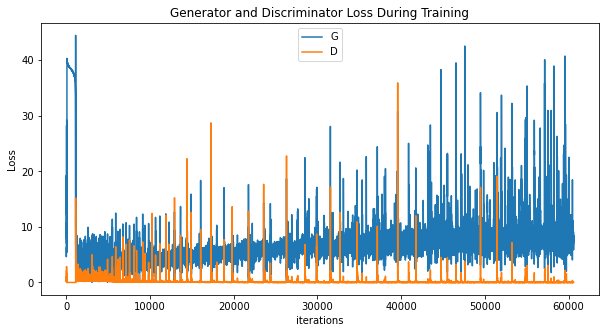

In [66]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Animation of generations over time

#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

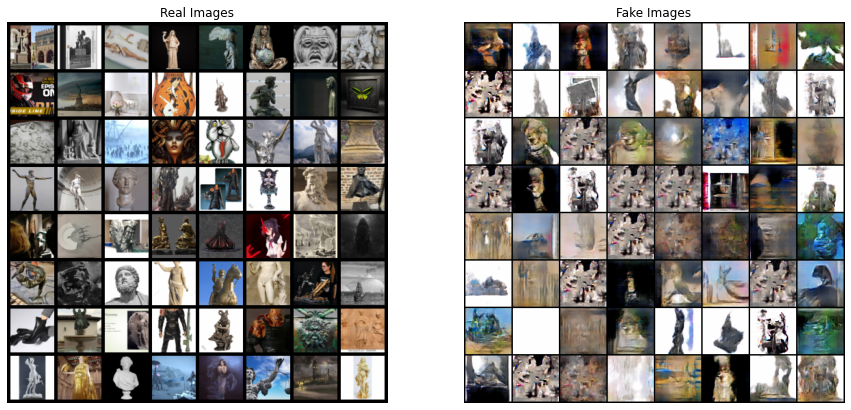

In [67]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()